In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, # GQN
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    # eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
    # aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [15]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], feed_dict)
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:22.0000 R:22.0000 rate:0.0440 aloss:0.7184 eloss:2.8131 aloss2:1.1073 exploreP:0.9978
Episode:1 meanR:21.5000 R:21.0000 rate:0.0420 aloss:0.7128 eloss:2.6730 aloss2:1.1590 exploreP:0.9958
Episode:2 meanR:19.0000 R:14.0000 rate:0.0280 aloss:0.7117 eloss:2.7066 aloss2:1.1486 exploreP:0.9944
Episode:3 meanR:19.2500 R:20.0000 rate:0.0400 aloss:0.7107 eloss:2.5809 aloss2:1.2066 exploreP:0.9924
Episode:4 meanR:20.4000 R:25.0000 rate:0.0500 aloss:0.7165 eloss:2.6580 aloss2:1.1731 exploreP:0.9900
Episode:5 meanR:23.8333 R:41.0000 rate:0.0820 aloss:0.7157 eloss:2.6402 aloss2:1.1937 exploreP:0.9859
Episode:6 meanR:22.2857 R:13.0000 rate:0.0260 aloss:0.7172 eloss:2.5791 aloss2:1.2236 exploreP:0.9847
Episode:7 meanR:21.2500 R:14.0000 rate:0.0280 aloss:0.7080 eloss:2.5681 aloss2:1.2211 exploreP:0.9833
Episode:8 meanR:21.5556 R:24.0000 rate:0.0480 aloss:0.7181 eloss:2.5598 aloss2:1.2289 exploreP:0.9810
Episode:9 meanR:26.3000 R:69.0000 rate:0.1380 aloss:0.7115 eloss:2.4207 aloss2:1.2

Episode:80 meanR:28.6296 R:15.0000 rate:0.0300 aloss:0.6810 eloss:1.2535 aloss2:2.3551 exploreP:0.7951
Episode:81 meanR:28.7439 R:38.0000 rate:0.0760 aloss:0.7159 eloss:1.2949 aloss2:2.3863 exploreP:0.7921
Episode:82 meanR:28.9759 R:48.0000 rate:0.0960 aloss:0.7149 eloss:1.2306 aloss2:2.4618 exploreP:0.7884
Episode:83 meanR:29.0952 R:39.0000 rate:0.0780 aloss:0.7086 eloss:1.1802 aloss2:2.5204 exploreP:0.7853
Episode:84 meanR:29.4235 R:57.0000 rate:0.1140 aloss:0.7114 eloss:1.1528 aloss2:2.5845 exploreP:0.7809
Episode:85 meanR:29.5349 R:39.0000 rate:0.0780 aloss:0.7142 eloss:1.1529 aloss2:2.6148 exploreP:0.7779
Episode:86 meanR:29.4253 R:20.0000 rate:0.0400 aloss:0.7251 eloss:1.1722 aloss2:2.6254 exploreP:0.7764
Episode:87 meanR:29.3068 R:19.0000 rate:0.0380 aloss:0.6889 eloss:1.0814 aloss2:2.6794 exploreP:0.7749
Episode:88 meanR:29.1124 R:12.0000 rate:0.0240 aloss:0.7409 eloss:1.0787 aloss2:2.7238 exploreP:0.7740
Episode:89 meanR:29.1778 R:35.0000 rate:0.0700 aloss:0.6986 eloss:1.0486 

Episode:159 meanR:38.4400 R:15.0000 rate:0.0300 aloss:0.8202 eloss:-0.9849 aloss2:7.8354 exploreP:0.5815
Episode:160 meanR:38.7100 R:62.0000 rate:0.1240 aloss:0.9129 eloss:-0.7579 aloss2:7.5231 exploreP:0.5779
Episode:161 meanR:38.7100 R:26.0000 rate:0.0520 aloss:0.8118 eloss:-1.0787 aloss2:7.9503 exploreP:0.5765
Episode:162 meanR:38.8700 R:36.0000 rate:0.0720 aloss:0.8689 eloss:-0.9842 aloss2:7.9654 exploreP:0.5744
Episode:163 meanR:38.7800 R:36.0000 rate:0.0720 aloss:0.9205 eloss:-0.9618 aloss2:7.9366 exploreP:0.5724
Episode:164 meanR:38.1800 R:61.0000 rate:0.1220 aloss:0.8499 eloss:-1.0737 aloss2:8.1506 exploreP:0.5690
Episode:165 meanR:38.9700 R:108.0000 rate:0.2160 aloss:0.8559 eloss:-1.2013 aloss2:8.4627 exploreP:0.5630
Episode:166 meanR:39.0100 R:33.0000 rate:0.0660 aloss:0.8440 eloss:-1.2425 aloss2:8.6047 exploreP:0.5611
Episode:167 meanR:39.1500 R:30.0000 rate:0.0600 aloss:0.8947 eloss:-1.0300 aloss2:8.7162 exploreP:0.5595
Episode:168 meanR:39.4500 R:52.0000 rate:0.1040 aloss:

Episode:237 meanR:79.3400 R:167.0000 rate:0.3340 aloss:0.9362 eloss:-6.5406 aloss2:31.8042 exploreP:0.2988
Episode:238 meanR:80.0400 R:97.0000 rate:0.1940 aloss:1.0031 eloss:-6.4559 aloss2:32.3525 exploreP:0.2960
Episode:239 meanR:81.0600 R:174.0000 rate:0.3480 aloss:0.9473 eloss:-7.2741 aloss2:33.1211 exploreP:0.2910
Episode:240 meanR:83.6100 R:285.0000 rate:0.5700 aloss:0.9181 eloss:-7.2198 aloss2:33.9810 exploreP:0.2831
Episode:241 meanR:86.0600 R:346.0000 rate:0.6920 aloss:0.9457 eloss:-6.6943 aloss2:35.1032 exploreP:0.2739
Episode:242 meanR:87.8000 R:210.0000 rate:0.4200 aloss:0.9090 eloss:-7.7299 aloss2:35.9014 exploreP:0.2684
Episode:243 meanR:91.5000 R:390.0000 rate:0.7800 aloss:0.8810 eloss:-8.0499 aloss2:36.9424 exploreP:0.2585
Episode:244 meanR:94.2600 R:320.0000 rate:0.6400 aloss:0.8732 eloss:-7.0081 aloss2:38.1483 exploreP:0.2507
Episode:245 meanR:95.9800 R:182.0000 rate:0.3640 aloss:0.8750 eloss:-7.2056 aloss2:38.8069 exploreP:0.2463
Episode:246 meanR:99.7400 R:500.0000 r

Episode:314 meanR:112.2000 R:49.0000 rate:0.0980 aloss:0.7943 eloss:3.3088 aloss2:45.5854 exploreP:0.1378
Episode:315 meanR:111.7100 R:20.0000 rate:0.0400 aloss:0.7575 eloss:-6.4244 aloss2:45.8046 exploreP:0.1375
Episode:316 meanR:112.1900 R:64.0000 rate:0.1280 aloss:0.8077 eloss:-8.6935 aloss2:46.6135 exploreP:0.1367
Episode:317 meanR:111.4400 R:12.0000 rate:0.0240 aloss:0.7613 eloss:-10.9233 aloss2:46.8976 exploreP:0.1365
Episode:318 meanR:110.7600 R:36.0000 rate:0.0720 aloss:0.7314 eloss:-9.8576 aloss2:46.6297 exploreP:0.1361
Episode:319 meanR:109.0500 R:31.0000 rate:0.0620 aloss:0.7510 eloss:-9.3813 aloss2:47.0231 exploreP:0.1357
Episode:320 meanR:106.4600 R:57.0000 rate:0.1140 aloss:0.7636 eloss:-7.8427 aloss2:46.9051 exploreP:0.1350
Episode:321 meanR:105.7800 R:43.0000 rate:0.0860 aloss:0.7578 eloss:-9.1158 aloss2:46.6277 exploreP:0.1344
Episode:322 meanR:105.4100 R:34.0000 rate:0.0680 aloss:0.7490 eloss:-9.3749 aloss2:46.5014 exploreP:0.1340
Episode:323 meanR:105.2200 R:52.0000 

Episode:392 meanR:42.6100 R:38.0000 rate:0.0760 aloss:0.7964 eloss:-8.6460 aloss2:49.1622 exploreP:0.1033
Episode:393 meanR:42.0100 R:38.0000 rate:0.0760 aloss:0.8771 eloss:-10.4939 aloss2:49.4078 exploreP:0.1029
Episode:394 meanR:41.2200 R:33.0000 rate:0.0660 aloss:0.7979 eloss:-8.7987 aloss2:49.5928 exploreP:0.1026
Episode:395 meanR:41.1800 R:31.0000 rate:0.0620 aloss:0.8306 eloss:-9.5914 aloss2:49.0604 exploreP:0.1023
Episode:396 meanR:40.7100 R:9.0000 rate:0.0180 aloss:0.7953 eloss:-10.9591 aloss2:50.0978 exploreP:0.1023
Episode:397 meanR:40.6300 R:34.0000 rate:0.0680 aloss:0.8168 eloss:-8.1560 aloss2:48.7584 exploreP:0.1019
Episode:398 meanR:40.4100 R:17.0000 rate:0.0340 aloss:0.8026 eloss:-11.0885 aloss2:49.7634 exploreP:0.1018
Episode:399 meanR:40.1300 R:19.0000 rate:0.0380 aloss:0.7954 eloss:-9.9559 aloss2:50.2476 exploreP:0.1016
Episode:400 meanR:39.8900 R:24.0000 rate:0.0480 aloss:0.8077 eloss:-9.2985 aloss2:51.0428 exploreP:0.1014
Episode:401 meanR:40.0800 R:43.0000 rate:0.0

Episode:470 meanR:37.3900 R:42.0000 rate:0.0840 aloss:0.7380 eloss:-9.2789 aloss2:51.9582 exploreP:0.0800
Episode:471 meanR:37.2000 R:28.0000 rate:0.0560 aloss:0.7997 eloss:-11.0580 aloss2:52.5505 exploreP:0.0798
Episode:472 meanR:37.1900 R:34.0000 rate:0.0680 aloss:0.7360 eloss:-9.7966 aloss2:51.8440 exploreP:0.0796
Episode:473 meanR:37.0500 R:24.0000 rate:0.0480 aloss:0.7174 eloss:-7.1662 aloss2:51.3447 exploreP:0.0794
Episode:474 meanR:37.0900 R:46.0000 rate:0.0920 aloss:0.7653 eloss:-10.2772 aloss2:52.5351 exploreP:0.0791
Episode:475 meanR:36.9800 R:34.0000 rate:0.0680 aloss:0.8029 eloss:-10.9670 aloss2:52.3456 exploreP:0.0789
Episode:476 meanR:36.8500 R:26.0000 rate:0.0520 aloss:0.8083 eloss:-10.1159 aloss2:53.4417 exploreP:0.0787
Episode:477 meanR:36.8900 R:47.0000 rate:0.0940 aloss:0.7482 eloss:-7.9608 aloss2:52.6607 exploreP:0.0784
Episode:478 meanR:36.8600 R:43.0000 rate:0.0860 aloss:0.7542 eloss:-10.0502 aloss2:52.4041 exploreP:0.0781
Episode:479 meanR:36.9800 R:41.0000 rate:

Episode:547 meanR:37.5300 R:38.0000 rate:0.0760 aloss:0.7294 eloss:-10.8291 aloss2:54.4338 exploreP:0.0621
Episode:548 meanR:37.6000 R:44.0000 rate:0.0880 aloss:0.7728 eloss:-8.8949 aloss2:54.1260 exploreP:0.0619
Episode:549 meanR:37.5200 R:26.0000 rate:0.0520 aloss:0.8348 eloss:-9.1928 aloss2:54.1700 exploreP:0.0618
Episode:550 meanR:37.3400 R:21.0000 rate:0.0420 aloss:0.8266 eloss:-11.7202 aloss2:55.3557 exploreP:0.0617
Episode:551 meanR:37.4100 R:37.0000 rate:0.0740 aloss:0.9168 eloss:-7.3976 aloss2:54.6091 exploreP:0.0615
Episode:552 meanR:37.4200 R:29.0000 rate:0.0580 aloss:0.7989 eloss:-1.2679 aloss2:55.0845 exploreP:0.0613
Episode:553 meanR:37.4500 R:46.0000 rate:0.0920 aloss:0.7843 eloss:-8.6983 aloss2:54.7524 exploreP:0.0611
Episode:554 meanR:37.7600 R:53.0000 rate:0.1060 aloss:0.8176 eloss:-10.3098 aloss2:55.2663 exploreP:0.0608
Episode:555 meanR:37.7500 R:35.0000 rate:0.0700 aloss:0.7832 eloss:-9.0728 aloss2:55.4851 exploreP:0.0606
Episode:556 meanR:37.8300 R:42.0000 rate:0.

Episode:624 meanR:39.2700 R:42.0000 rate:0.0840 aloss:0.8082 eloss:-11.8707 aloss2:57.0549 exploreP:0.0484
Episode:625 meanR:39.2200 R:43.0000 rate:0.0860 aloss:0.8431 eloss:-9.5209 aloss2:56.2129 exploreP:0.0482
Episode:626 meanR:39.3000 R:38.0000 rate:0.0760 aloss:0.8037 eloss:-11.1116 aloss2:57.4476 exploreP:0.0481
Episode:627 meanR:39.4300 R:47.0000 rate:0.0940 aloss:0.8023 eloss:-11.6566 aloss2:57.9839 exploreP:0.0479
Episode:628 meanR:39.5300 R:42.0000 rate:0.0840 aloss:0.8193 eloss:-8.6245 aloss2:57.6692 exploreP:0.0478
Episode:629 meanR:39.6300 R:47.0000 rate:0.0940 aloss:0.7870 eloss:-11.8753 aloss2:57.4005 exploreP:0.0476
Episode:630 meanR:39.8000 R:45.0000 rate:0.0900 aloss:0.9048 eloss:-9.6322 aloss2:57.1027 exploreP:0.0474
Episode:631 meanR:39.9600 R:41.0000 rate:0.0820 aloss:0.7743 eloss:-11.9614 aloss2:57.7003 exploreP:0.0473
Episode:632 meanR:40.0900 R:46.0000 rate:0.0920 aloss:0.8074 eloss:-10.0455 aloss2:56.9691 exploreP:0.0471
Episode:633 meanR:40.2800 R:51.0000 rate

Episode:701 meanR:45.1200 R:62.0000 rate:0.1240 aloss:0.7746 eloss:-10.4972 aloss2:60.5906 exploreP:0.0370
Episode:702 meanR:45.2100 R:61.0000 rate:0.1220 aloss:0.7591 eloss:-9.9145 aloss2:61.2719 exploreP:0.0368
Episode:703 meanR:45.4100 R:60.0000 rate:0.1200 aloss:0.7426 eloss:-11.6287 aloss2:61.1750 exploreP:0.0367
Episode:704 meanR:45.4600 R:45.0000 rate:0.0900 aloss:0.7356 eloss:-12.4223 aloss2:60.9838 exploreP:0.0366
Episode:705 meanR:45.4800 R:43.0000 rate:0.0860 aloss:0.7812 eloss:-8.5204 aloss2:60.8988 exploreP:0.0365
Episode:706 meanR:45.3500 R:34.0000 rate:0.0680 aloss:0.7121 eloss:-13.5929 aloss2:60.8919 exploreP:0.0364
Episode:707 meanR:45.4300 R:54.0000 rate:0.1080 aloss:0.7291 eloss:-11.7601 aloss2:60.9603 exploreP:0.0362
Episode:708 meanR:45.3000 R:31.0000 rate:0.0620 aloss:0.7168 eloss:-11.0935 aloss2:60.5700 exploreP:0.0361
Episode:709 meanR:45.2000 R:34.0000 rate:0.0680 aloss:0.7265 eloss:-11.5019 aloss2:60.8028 exploreP:0.0360
Episode:710 meanR:45.1000 R:31.0000 rat

Episode:778 meanR:77.8100 R:76.0000 rate:0.1520 aloss:0.6715 eloss:-11.3177 aloss2:65.4688 exploreP:0.0239
Episode:779 meanR:78.4600 R:115.0000 rate:0.2300 aloss:0.6555 eloss:-10.3265 aloss2:65.0680 exploreP:0.0237
Episode:780 meanR:79.6000 R:167.0000 rate:0.3340 aloss:0.6406 eloss:-10.4932 aloss2:65.8853 exploreP:0.0235
Episode:781 meanR:80.3800 R:117.0000 rate:0.2340 aloss:0.6646 eloss:-10.9695 aloss2:66.2250 exploreP:0.0233
Episode:782 meanR:80.9400 R:109.0000 rate:0.2180 aloss:0.6591 eloss:-10.9765 aloss2:65.8877 exploreP:0.0232
Episode:783 meanR:81.6300 R:110.0000 rate:0.2200 aloss:0.6748 eloss:-11.4321 aloss2:66.1354 exploreP:0.0230
Episode:784 meanR:81.7800 R:61.0000 rate:0.1220 aloss:0.6871 eloss:-10.7370 aloss2:66.2159 exploreP:0.0230
Episode:785 meanR:81.8500 R:59.0000 rate:0.1180 aloss:0.6773 eloss:-12.1885 aloss2:65.7696 exploreP:0.0229
Episode:786 meanR:82.1400 R:72.0000 rate:0.1440 aloss:0.7252 eloss:-11.0834 aloss2:65.8695 exploreP:0.0228
Episode:787 meanR:82.3400 R:72.0

Episode:855 meanR:102.4400 R:117.0000 rate:0.2340 aloss:0.6490 eloss:-11.5467 aloss2:68.9259 exploreP:0.0166
Episode:856 meanR:102.6300 R:84.0000 rate:0.1680 aloss:0.6837 eloss:-14.5615 aloss2:68.7935 exploreP:0.0166
Episode:857 meanR:102.4900 R:62.0000 rate:0.1240 aloss:0.7364 eloss:-9.6704 aloss2:69.0373 exploreP:0.0165
Episode:858 meanR:101.6000 R:66.0000 rate:0.1320 aloss:0.7406 eloss:-4.2465 aloss2:67.7631 exploreP:0.0165
Episode:859 meanR:101.3400 R:66.0000 rate:0.1320 aloss:0.7141 eloss:-12.9681 aloss2:68.3669 exploreP:0.0165
Episode:860 meanR:99.5400 R:71.0000 rate:0.1420 aloss:0.7194 eloss:-12.0038 aloss2:69.2171 exploreP:0.0164
Episode:861 meanR:99.2200 R:77.0000 rate:0.1540 aloss:0.6702 eloss:-12.2149 aloss2:68.8546 exploreP:0.0164
Episode:862 meanR:99.3300 R:112.0000 rate:0.2240 aloss:0.6396 eloss:-8.7273 aloss2:68.5632 exploreP:0.0163
Episode:863 meanR:100.6200 R:219.0000 rate:0.4380 aloss:0.6223 eloss:-11.9654 aloss2:68.6309 exploreP:0.0162
Episode:864 meanR:102.1300 R:24

Episode:932 meanR:95.5700 R:116.0000 rate:0.2320 aloss:0.6781 eloss:-11.5380 aloss2:72.1485 exploreP:0.0132
Episode:933 meanR:95.6200 R:112.0000 rate:0.2240 aloss:0.6527 eloss:-13.1716 aloss2:72.7828 exploreP:0.0132
Episode:934 meanR:95.6600 R:72.0000 rate:0.1440 aloss:0.6481 eloss:-12.7006 aloss2:72.8556 exploreP:0.0131
Episode:935 meanR:95.5400 R:77.0000 rate:0.1540 aloss:0.6735 eloss:-11.4947 aloss2:71.8583 exploreP:0.0131
Episode:936 meanR:95.6700 R:72.0000 rate:0.1440 aloss:0.6242 eloss:-12.8766 aloss2:73.1135 exploreP:0.0131
Episode:937 meanR:96.0500 R:97.0000 rate:0.1940 aloss:0.7167 eloss:-12.1896 aloss2:72.4690 exploreP:0.0131
Episode:938 meanR:95.9100 R:50.0000 rate:0.1000 aloss:0.6848 eloss:-8.6470 aloss2:72.5374 exploreP:0.0130
Episode:939 meanR:95.8300 R:68.0000 rate:0.1360 aloss:0.7038 eloss:-11.2625 aloss2:72.5545 exploreP:0.0130
Episode:940 meanR:96.1800 R:125.0000 rate:0.2500 aloss:0.6870 eloss:-11.2471 aloss2:73.2108 exploreP:0.0130
Episode:941 meanR:95.9800 R:105.000

Episode:1009 meanR:92.7500 R:117.0000 rate:0.2340 aloss:0.6558 eloss:-11.2766 aloss2:75.7707 exploreP:0.0115
Episode:1010 meanR:92.8600 R:92.0000 rate:0.1840 aloss:0.5975 eloss:-13.6796 aloss2:76.3832 exploreP:0.0115
Episode:1011 meanR:93.0200 R:96.0000 rate:0.1920 aloss:0.6038 eloss:-12.1608 aloss2:76.1835 exploreP:0.0115
Episode:1012 meanR:92.6200 R:102.0000 rate:0.2040 aloss:0.6331 eloss:-10.7108 aloss2:76.2818 exploreP:0.0115
Episode:1013 meanR:92.6500 R:116.0000 rate:0.2320 aloss:0.6789 eloss:-12.4166 aloss2:77.4270 exploreP:0.0115
Episode:1014 meanR:92.7700 R:86.0000 rate:0.1720 aloss:0.6740 eloss:-13.2311 aloss2:77.1210 exploreP:0.0115
Episode:1015 meanR:92.8900 R:83.0000 rate:0.1660 aloss:0.6054 eloss:-12.2545 aloss2:78.3362 exploreP:0.0115
Episode:1016 meanR:93.2700 R:114.0000 rate:0.2280 aloss:0.6296 eloss:-5.5692 aloss2:77.4348 exploreP:0.0114
Episode:1017 meanR:94.1000 R:133.0000 rate:0.2660 aloss:0.6125 eloss:-11.3328 aloss2:77.5749 exploreP:0.0114
Episode:1018 meanR:94.43

Episode:1085 meanR:99.7500 R:80.0000 rate:0.1600 aloss:0.5689 eloss:-13.5905 aloss2:79.7388 exploreP:0.0107
Episode:1086 meanR:99.7600 R:117.0000 rate:0.2340 aloss:0.5952 eloss:-13.9043 aloss2:79.7240 exploreP:0.0107
Episode:1087 meanR:99.8400 R:125.0000 rate:0.2500 aloss:0.5945 eloss:-15.3248 aloss2:79.1405 exploreP:0.0107
Episode:1088 meanR:100.3300 R:118.0000 rate:0.2360 aloss:0.6125 eloss:-14.2999 aloss2:78.9274 exploreP:0.0107
Episode:1089 meanR:100.5500 R:119.0000 rate:0.2380 aloss:0.6389 eloss:-12.3317 aloss2:79.3889 exploreP:0.0107
Episode:1090 meanR:100.8900 R:100.0000 rate:0.2000 aloss:0.7090 eloss:-7.7790 aloss2:79.4848 exploreP:0.0107
Episode:1091 meanR:101.0400 R:72.0000 rate:0.1440 aloss:0.6020 eloss:-9.5387 aloss2:79.2983 exploreP:0.0107
Episode:1092 meanR:100.3800 R:53.0000 rate:0.1060 aloss:0.5808 eloss:-14.7347 aloss2:79.1594 exploreP:0.0107
Episode:1093 meanR:100.1000 R:76.0000 rate:0.1520 aloss:0.6359 eloss:-14.0874 aloss2:81.1092 exploreP:0.0107
Episode:1094 meanR:

Episode:1161 meanR:83.6000 R:71.0000 rate:0.1420 aloss:0.5555 eloss:-14.6794 aloss2:86.0937 exploreP:0.0104
Episode:1162 meanR:83.1400 R:38.0000 rate:0.0760 aloss:0.6075 eloss:-17.1752 aloss2:85.0052 exploreP:0.0104
Episode:1163 meanR:82.8200 R:75.0000 rate:0.1500 aloss:0.5410 eloss:-13.2048 aloss2:85.6027 exploreP:0.0104
Episode:1164 meanR:82.1500 R:75.0000 rate:0.1500 aloss:0.4889 eloss:-15.4163 aloss2:85.0466 exploreP:0.0104
Episode:1165 meanR:82.2300 R:122.0000 rate:0.2440 aloss:0.5128 eloss:-15.8618 aloss2:85.9990 exploreP:0.0104
Episode:1166 meanR:82.4900 R:109.0000 rate:0.2180 aloss:0.5164 eloss:-12.2267 aloss2:83.8510 exploreP:0.0104
Episode:1167 meanR:82.4200 R:53.0000 rate:0.1060 aloss:0.5393 eloss:-7.7373 aloss2:81.8447 exploreP:0.0104
Episode:1168 meanR:82.1200 R:51.0000 rate:0.1020 aloss:0.5665 eloss:-14.3472 aloss2:85.7136 exploreP:0.0104
Episode:1169 meanR:81.8800 R:76.0000 rate:0.1520 aloss:0.5508 eloss:-17.2246 aloss2:85.8100 exploreP:0.0104
Episode:1170 meanR:81.3500 

Episode:1237 meanR:75.5900 R:89.0000 rate:0.1780 aloss:0.5156 eloss:-15.8730 aloss2:89.8757 exploreP:0.0102
Episode:1238 meanR:75.8100 R:103.0000 rate:0.2060 aloss:0.4988 eloss:-14.6654 aloss2:91.0752 exploreP:0.0102
Episode:1239 meanR:75.8000 R:90.0000 rate:0.1800 aloss:0.4814 eloss:-15.8823 aloss2:90.3455 exploreP:0.0102
Episode:1240 meanR:75.1800 R:61.0000 rate:0.1220 aloss:0.4740 eloss:-15.2174 aloss2:91.4385 exploreP:0.0102
Episode:1241 meanR:75.3800 R:73.0000 rate:0.1460 aloss:0.5070 eloss:-15.9074 aloss2:91.0565 exploreP:0.0102
Episode:1242 meanR:75.4500 R:54.0000 rate:0.1080 aloss:0.5340 eloss:-15.4817 aloss2:91.3996 exploreP:0.0102
Episode:1243 meanR:75.8500 R:100.0000 rate:0.2000 aloss:0.5154 eloss:-15.5456 aloss2:90.1812 exploreP:0.0102
Episode:1244 meanR:75.1500 R:49.0000 rate:0.0980 aloss:0.5051 eloss:-17.5150 aloss2:91.0538 exploreP:0.0102
Episode:1245 meanR:74.5100 R:57.0000 rate:0.1140 aloss:0.4866 eloss:-14.9151 aloss2:90.5948 exploreP:0.0102
Episode:1246 meanR:74.3800

Episode:1313 meanR:75.4600 R:89.0000 rate:0.1780 aloss:0.4333 eloss:-15.9390 aloss2:94.3378 exploreP:0.0101
Episode:1314 meanR:75.4300 R:88.0000 rate:0.1760 aloss:0.4698 eloss:-15.2301 aloss2:92.6015 exploreP:0.0101
Episode:1315 meanR:76.1900 R:180.0000 rate:0.3600 aloss:0.4951 eloss:-12.5849 aloss2:95.8487 exploreP:0.0101
Episode:1316 meanR:76.1200 R:97.0000 rate:0.1940 aloss:0.4597 eloss:-15.6514 aloss2:94.6237 exploreP:0.0101
Episode:1317 meanR:75.5300 R:41.0000 rate:0.0820 aloss:0.5079 eloss:-17.8677 aloss2:96.9408 exploreP:0.0101
Episode:1318 meanR:75.2000 R:66.0000 rate:0.1320 aloss:0.5273 eloss:-18.9126 aloss2:95.5818 exploreP:0.0101
Episode:1319 meanR:74.4800 R:43.0000 rate:0.0860 aloss:0.5875 eloss:-16.7588 aloss2:96.3409 exploreP:0.0101
Episode:1320 meanR:73.8000 R:41.0000 rate:0.0820 aloss:0.5884 eloss:-17.3777 aloss2:95.7609 exploreP:0.0101
Episode:1321 meanR:73.5200 R:49.0000 rate:0.0980 aloss:0.5729 eloss:-12.1827 aloss2:96.3880 exploreP:0.0101
Episode:1322 meanR:72.9800 

Episode:1389 meanR:68.8300 R:36.0000 rate:0.0720 aloss:0.4684 eloss:-10.8751 aloss2:92.8581 exploreP:0.0101
Episode:1390 meanR:68.6800 R:53.0000 rate:0.1060 aloss:0.5047 eloss:-7.9429 aloss2:95.8491 exploreP:0.0101
Episode:1391 meanR:68.6600 R:56.0000 rate:0.1120 aloss:0.5360 eloss:-15.6592 aloss2:92.6485 exploreP:0.0101
Episode:1392 meanR:68.2500 R:44.0000 rate:0.0880 aloss:0.5567 eloss:-13.0989 aloss2:96.4280 exploreP:0.0101
Episode:1393 meanR:67.8500 R:37.0000 rate:0.0740 aloss:0.4557 eloss:-15.8057 aloss2:97.3705 exploreP:0.0101
Episode:1394 meanR:68.0000 R:80.0000 rate:0.1600 aloss:0.4649 eloss:-18.6989 aloss2:99.8314 exploreP:0.0101
Episode:1395 meanR:67.8500 R:52.0000 rate:0.1040 aloss:0.5171 eloss:-16.9998 aloss2:99.1624 exploreP:0.0101
Episode:1396 meanR:67.7500 R:58.0000 rate:0.1160 aloss:0.4538 eloss:-16.1118 aloss2:98.7433 exploreP:0.0101
Episode:1397 meanR:67.3400 R:57.0000 rate:0.1140 aloss:0.4617 eloss:-15.4822 aloss2:97.5904 exploreP:0.0101
Episode:1398 meanR:67.1300 R:

Episode:1465 meanR:62.0300 R:41.0000 rate:0.0820 aloss:0.4544 eloss:-12.4115 aloss2:102.3142 exploreP:0.0100
Episode:1466 meanR:62.4900 R:98.0000 rate:0.1960 aloss:0.4241 eloss:-14.0887 aloss2:101.2315 exploreP:0.0100
Episode:1467 meanR:62.6900 R:70.0000 rate:0.1400 aloss:0.3941 eloss:-15.3026 aloss2:102.6281 exploreP:0.0100
Episode:1468 meanR:62.4800 R:56.0000 rate:0.1120 aloss:0.3998 eloss:-18.5553 aloss2:99.4551 exploreP:0.0100
Episode:1469 meanR:62.6900 R:90.0000 rate:0.1800 aloss:0.4179 eloss:-17.9212 aloss2:101.8649 exploreP:0.0100
Episode:1470 meanR:62.9000 R:62.0000 rate:0.1240 aloss:0.3948 eloss:-12.4458 aloss2:95.1114 exploreP:0.0100
Episode:1471 meanR:62.9500 R:61.0000 rate:0.1220 aloss:0.4415 eloss:-16.3725 aloss2:101.9466 exploreP:0.0100
Episode:1472 meanR:62.6600 R:43.0000 rate:0.0860 aloss:0.4377 eloss:-16.0195 aloss2:101.1399 exploreP:0.0100
Episode:1473 meanR:62.3400 R:63.0000 rate:0.1260 aloss:0.4520 eloss:-12.9685 aloss2:97.2693 exploreP:0.0100
Episode:1474 meanR:62.

Episode:1541 meanR:66.7900 R:108.0000 rate:0.2160 aloss:0.4443 eloss:-16.6734 aloss2:105.5784 exploreP:0.0100
Episode:1542 meanR:67.1800 R:78.0000 rate:0.1560 aloss:0.3213 eloss:-19.7769 aloss2:105.4655 exploreP:0.0100
Episode:1543 meanR:67.2200 R:59.0000 rate:0.1180 aloss:0.3581 eloss:-17.1192 aloss2:106.5696 exploreP:0.0100
Episode:1544 meanR:67.8200 R:117.0000 rate:0.2340 aloss:0.4206 eloss:-11.7860 aloss2:109.1527 exploreP:0.0100
Episode:1545 meanR:67.5100 R:37.0000 rate:0.0740 aloss:0.4929 eloss:-17.4155 aloss2:103.0147 exploreP:0.0100
Episode:1546 meanR:67.2700 R:70.0000 rate:0.1400 aloss:0.4330 eloss:-21.9198 aloss2:108.5533 exploreP:0.0100
Episode:1547 meanR:67.3700 R:57.0000 rate:0.1140 aloss:0.5007 eloss:-22.4212 aloss2:111.4469 exploreP:0.0100
Episode:1548 meanR:67.3000 R:46.0000 rate:0.0920 aloss:0.3757 eloss:-24.7850 aloss2:107.6177 exploreP:0.0100
Episode:1549 meanR:67.5400 R:80.0000 rate:0.1600 aloss:0.4330 eloss:-20.7060 aloss2:108.6609 exploreP:0.0100
Episode:1550 mean

Episode:1617 meanR:70.8900 R:58.0000 rate:0.1160 aloss:0.3844 eloss:-23.1201 aloss2:115.8650 exploreP:0.0100
Episode:1618 meanR:70.8600 R:36.0000 rate:0.0720 aloss:0.6877 eloss:-17.4508 aloss2:112.4392 exploreP:0.0100
Episode:1619 meanR:70.8800 R:41.0000 rate:0.0820 aloss:0.5378 eloss:-22.3502 aloss2:119.8812 exploreP:0.0100
Episode:1620 meanR:70.8500 R:47.0000 rate:0.0940 aloss:0.3618 eloss:-22.5892 aloss2:115.7694 exploreP:0.0100
Episode:1621 meanR:70.6200 R:43.0000 rate:0.0860 aloss:0.3993 eloss:-25.2586 aloss2:117.2538 exploreP:0.0100
Episode:1622 meanR:70.5100 R:72.0000 rate:0.1440 aloss:0.3608 eloss:-23.9473 aloss2:118.1082 exploreP:0.0100
Episode:1623 meanR:70.0000 R:70.0000 rate:0.1400 aloss:0.4798 eloss:7.9429 aloss2:114.0781 exploreP:0.0100
Episode:1624 meanR:69.6700 R:49.0000 rate:0.0980 aloss:0.4218 eloss:-19.9560 aloss2:114.6558 exploreP:0.0100
Episode:1625 meanR:69.7500 R:65.0000 rate:0.1300 aloss:0.3120 eloss:-21.4234 aloss2:115.1248 exploreP:0.0100
Episode:1626 meanR:69

Episode:1693 meanR:66.9400 R:57.0000 rate:0.1140 aloss:0.4165 eloss:-16.1811 aloss2:126.1618 exploreP:0.0100
Episode:1694 meanR:66.5200 R:43.0000 rate:0.0860 aloss:0.3970 eloss:-18.9506 aloss2:114.6360 exploreP:0.0100
Episode:1695 meanR:66.3400 R:48.0000 rate:0.0960 aloss:0.3391 eloss:-21.4920 aloss2:120.5909 exploreP:0.0100
Episode:1696 meanR:66.3900 R:64.0000 rate:0.1280 aloss:0.3353 eloss:-22.3767 aloss2:119.8007 exploreP:0.0100
Episode:1697 meanR:66.0800 R:55.0000 rate:0.1100 aloss:0.3387 eloss:-23.7241 aloss2:123.9710 exploreP:0.0100
Episode:1698 meanR:66.4000 R:123.0000 rate:0.2460 aloss:0.3063 eloss:-23.5380 aloss2:120.7946 exploreP:0.0100
Episode:1699 meanR:66.7800 R:125.0000 rate:0.2500 aloss:0.3127 eloss:-21.4277 aloss2:120.4389 exploreP:0.0100
Episode:1700 meanR:67.0700 R:105.0000 rate:0.2100 aloss:0.3276 eloss:-21.4285 aloss2:122.4319 exploreP:0.0100
Episode:1701 meanR:67.1600 R:53.0000 rate:0.1060 aloss:0.3841 eloss:-24.2395 aloss2:123.2973 exploreP:0.0100
Episode:1702 mea

Episode:1769 meanR:78.4600 R:46.0000 rate:0.0920 aloss:0.3276 eloss:-26.6040 aloss2:129.2044 exploreP:0.0100
Episode:1770 meanR:78.2300 R:45.0000 rate:0.0900 aloss:0.3430 eloss:-27.7049 aloss2:129.5375 exploreP:0.0100
Episode:1771 meanR:77.9800 R:63.0000 rate:0.1260 aloss:0.3030 eloss:-26.2188 aloss2:132.1999 exploreP:0.0100
Episode:1772 meanR:78.4100 R:82.0000 rate:0.1640 aloss:0.3329 eloss:-26.3526 aloss2:128.4272 exploreP:0.0100
Episode:1773 meanR:79.0300 R:100.0000 rate:0.2000 aloss:0.3312 eloss:-20.9117 aloss2:127.0992 exploreP:0.0100
Episode:1774 meanR:79.5300 R:93.0000 rate:0.1860 aloss:0.2911 eloss:-18.9649 aloss2:130.9195 exploreP:0.0100
Episode:1775 meanR:79.9800 R:87.0000 rate:0.1740 aloss:0.3321 eloss:-23.8081 aloss2:131.6971 exploreP:0.0100
Episode:1776 meanR:80.1600 R:70.0000 rate:0.1400 aloss:0.3221 eloss:-20.6956 aloss2:132.7359 exploreP:0.0100
Episode:1777 meanR:80.0800 R:74.0000 rate:0.1480 aloss:0.3328 eloss:-23.5427 aloss2:129.1872 exploreP:0.0100
Episode:1778 meanR

Episode:1845 meanR:79.0600 R:77.0000 rate:0.1540 aloss:0.2841 eloss:-23.9666 aloss2:131.1863 exploreP:0.0100
Episode:1846 meanR:78.6000 R:75.0000 rate:0.1500 aloss:0.3123 eloss:-23.6321 aloss2:133.5867 exploreP:0.0100
Episode:1847 meanR:78.3900 R:77.0000 rate:0.1540 aloss:0.3112 eloss:-27.8923 aloss2:135.2909 exploreP:0.0100
Episode:1848 meanR:78.3100 R:77.0000 rate:0.1540 aloss:0.3557 eloss:-28.6226 aloss2:137.6288 exploreP:0.0100
Episode:1849 meanR:77.7000 R:55.0000 rate:0.1100 aloss:0.3229 eloss:-27.1853 aloss2:138.3642 exploreP:0.0100
Episode:1850 meanR:77.6700 R:69.0000 rate:0.1380 aloss:0.2818 eloss:-30.4256 aloss2:136.2687 exploreP:0.0100
Episode:1851 meanR:77.5700 R:78.0000 rate:0.1560 aloss:0.2884 eloss:-27.3061 aloss2:135.5101 exploreP:0.0100
Episode:1852 meanR:77.2100 R:96.0000 rate:0.1920 aloss:0.2773 eloss:-25.6409 aloss2:135.7813 exploreP:0.0100
Episode:1853 meanR:77.1300 R:89.0000 rate:0.1780 aloss:0.2616 eloss:-25.3164 aloss2:139.1884 exploreP:0.0100
Episode:1854 meanR:

Episode:1921 meanR:63.1400 R:66.0000 rate:0.1320 aloss:0.3184 eloss:-24.4458 aloss2:141.3767 exploreP:0.0100
Episode:1922 meanR:62.5900 R:71.0000 rate:0.1420 aloss:0.2909 eloss:-22.7222 aloss2:142.9291 exploreP:0.0100
Episode:1923 meanR:61.7200 R:43.0000 rate:0.0860 aloss:0.3290 eloss:-15.5337 aloss2:141.9722 exploreP:0.0100
Episode:1924 meanR:61.5300 R:51.0000 rate:0.1020 aloss:0.3047 eloss:-30.1271 aloss2:141.2551 exploreP:0.0100
Episode:1925 meanR:61.4200 R:43.0000 rate:0.0860 aloss:0.3243 eloss:-26.9591 aloss2:137.2514 exploreP:0.0100
Episode:1926 meanR:61.4300 R:46.0000 rate:0.0920 aloss:0.2538 eloss:-30.6257 aloss2:136.0542 exploreP:0.0100
Episode:1927 meanR:61.6600 R:92.0000 rate:0.1840 aloss:0.2711 eloss:-26.3587 aloss2:140.7255 exploreP:0.0100
Episode:1928 meanR:61.8300 R:66.0000 rate:0.1320 aloss:0.2584 eloss:-25.1439 aloss2:135.3047 exploreP:0.0100
Episode:1929 meanR:62.0500 R:96.0000 rate:0.1920 aloss:0.2780 eloss:-12.9826 aloss2:135.9283 exploreP:0.0100
Episode:1930 meanR:

Episode:1997 meanR:55.5500 R:70.0000 rate:0.1400 aloss:0.3059 eloss:-25.0497 aloss2:149.2031 exploreP:0.0100
Episode:1998 meanR:55.4700 R:63.0000 rate:0.1260 aloss:0.3572 eloss:-28.3111 aloss2:143.0437 exploreP:0.0100
Episode:1999 meanR:55.4400 R:46.0000 rate:0.0920 aloss:0.3276 eloss:-29.3945 aloss2:147.0484 exploreP:0.0100
Episode:2000 meanR:55.2900 R:52.0000 rate:0.1040 aloss:0.3338 eloss:-30.1167 aloss2:142.6616 exploreP:0.0100
Episode:2001 meanR:55.4300 R:52.0000 rate:0.1040 aloss:0.3077 eloss:-26.8384 aloss2:142.6028 exploreP:0.0100
Episode:2002 meanR:55.3800 R:48.0000 rate:0.0960 aloss:0.3495 eloss:-27.6591 aloss2:139.4153 exploreP:0.0100
Episode:2003 meanR:55.5500 R:63.0000 rate:0.1260 aloss:0.3619 eloss:-27.6052 aloss2:147.7832 exploreP:0.0100
Episode:2004 meanR:55.2000 R:54.0000 rate:0.1080 aloss:0.3454 eloss:-26.2799 aloss2:145.9284 exploreP:0.0100
Episode:2005 meanR:54.8900 R:54.0000 rate:0.1080 aloss:0.5313 eloss:-28.5528 aloss2:138.7146 exploreP:0.0100
Episode:2006 meanR:

Episode:2073 meanR:50.4500 R:38.0000 rate:0.0760 aloss:0.3930 eloss:-32.5291 aloss2:155.0860 exploreP:0.0100
Episode:2074 meanR:50.5100 R:48.0000 rate:0.0960 aloss:0.5425 eloss:-19.3562 aloss2:150.3271 exploreP:0.0100
Episode:2075 meanR:50.4800 R:45.0000 rate:0.0900 aloss:0.5254 eloss:-30.5414 aloss2:148.2735 exploreP:0.0100
Episode:2076 meanR:50.3400 R:31.0000 rate:0.0620 aloss:0.4280 eloss:-29.1037 aloss2:154.8108 exploreP:0.0100
Episode:2077 meanR:50.5100 R:57.0000 rate:0.1140 aloss:0.3149 eloss:-30.9094 aloss2:149.5158 exploreP:0.0100
Episode:2078 meanR:50.6700 R:60.0000 rate:0.1200 aloss:0.3783 eloss:15.6064 aloss2:148.9079 exploreP:0.0100
Episode:2079 meanR:50.4900 R:61.0000 rate:0.1220 aloss:0.3304 eloss:-30.4002 aloss2:150.5610 exploreP:0.0100
Episode:2080 meanR:49.9500 R:40.0000 rate:0.0800 aloss:0.3388 eloss:-23.0294 aloss2:139.9604 exploreP:0.0100
Episode:2081 meanR:49.8800 R:33.0000 rate:0.0660 aloss:0.3530 eloss:-16.0500 aloss2:142.6493 exploreP:0.0100
Episode:2082 meanR:4

Episode:2149 meanR:51.6500 R:81.0000 rate:0.1620 aloss:0.3152 eloss:-35.5237 aloss2:149.2380 exploreP:0.0100
Episode:2150 meanR:51.7100 R:58.0000 rate:0.1160 aloss:0.3135 eloss:-22.6373 aloss2:152.7772 exploreP:0.0100
Episode:2151 meanR:51.6900 R:48.0000 rate:0.0960 aloss:0.3124 eloss:-26.3063 aloss2:150.6555 exploreP:0.0100
Episode:2152 meanR:51.3500 R:38.0000 rate:0.0760 aloss:0.3879 eloss:-33.6902 aloss2:157.6657 exploreP:0.0100
Episode:2153 meanR:51.5800 R:83.0000 rate:0.1660 aloss:0.4013 eloss:-27.0294 aloss2:154.7595 exploreP:0.0100
Episode:2154 meanR:51.7300 R:54.0000 rate:0.1080 aloss:0.3237 eloss:-21.1199 aloss2:160.5379 exploreP:0.0100
Episode:2155 meanR:52.2000 R:89.0000 rate:0.1780 aloss:0.3298 eloss:-25.6848 aloss2:150.3921 exploreP:0.0100
Episode:2156 meanR:52.4900 R:82.0000 rate:0.1640 aloss:0.2507 eloss:-20.4595 aloss2:151.7060 exploreP:0.0100
Episode:2157 meanR:52.5500 R:49.0000 rate:0.0980 aloss:0.2990 eloss:-24.2662 aloss2:145.0576 exploreP:0.0100
Episode:2158 meanR:

Episode:2225 meanR:56.9500 R:60.0000 rate:0.1200 aloss:0.3173 eloss:-38.8367 aloss2:152.4903 exploreP:0.0100
Episode:2226 meanR:56.9400 R:50.0000 rate:0.1000 aloss:0.3374 eloss:-19.9764 aloss2:155.5206 exploreP:0.0100
Episode:2227 meanR:56.6400 R:38.0000 rate:0.0760 aloss:0.3488 eloss:-24.9748 aloss2:149.4679 exploreP:0.0100
Episode:2228 meanR:56.6200 R:64.0000 rate:0.1280 aloss:0.3568 eloss:-27.0410 aloss2:154.7538 exploreP:0.0100
Episode:2229 meanR:56.6300 R:46.0000 rate:0.0920 aloss:0.3573 eloss:-25.9145 aloss2:158.5164 exploreP:0.0100
Episode:2230 meanR:56.9900 R:85.0000 rate:0.1700 aloss:0.3630 eloss:-25.4378 aloss2:155.5096 exploreP:0.0100
Episode:2231 meanR:57.3400 R:122.0000 rate:0.2440 aloss:0.3351 eloss:-24.5216 aloss2:154.0334 exploreP:0.0100
Episode:2232 meanR:57.4700 R:79.0000 rate:0.1580 aloss:0.2976 eloss:-30.7944 aloss2:161.0110 exploreP:0.0100
Episode:2233 meanR:57.8500 R:89.0000 rate:0.1780 aloss:0.2885 eloss:-27.7767 aloss2:158.8302 exploreP:0.0100
Episode:2234 meanR

Episode:2301 meanR:59.6300 R:54.0000 rate:0.1080 aloss:0.3380 eloss:-24.2387 aloss2:161.3059 exploreP:0.0100
Episode:2302 meanR:59.7600 R:55.0000 rate:0.1100 aloss:0.3341 eloss:-29.1374 aloss2:143.3518 exploreP:0.0100
Episode:2303 meanR:60.2100 R:101.0000 rate:0.2020 aloss:0.3219 eloss:-25.4576 aloss2:150.2847 exploreP:0.0100
Episode:2304 meanR:59.6900 R:49.0000 rate:0.0980 aloss:0.3012 eloss:-30.1659 aloss2:152.3490 exploreP:0.0100
Episode:2305 meanR:59.3800 R:50.0000 rate:0.1000 aloss:0.3046 eloss:-14.1952 aloss2:153.9174 exploreP:0.0100
Episode:2306 meanR:58.8500 R:41.0000 rate:0.0820 aloss:0.2844 eloss:-28.2433 aloss2:144.7788 exploreP:0.0100
Episode:2307 meanR:58.8700 R:65.0000 rate:0.1300 aloss:0.2721 eloss:-20.2456 aloss2:156.7777 exploreP:0.0100
Episode:2308 meanR:58.7700 R:43.0000 rate:0.0860 aloss:0.2950 eloss:-17.8044 aloss2:154.1288 exploreP:0.0100
Episode:2309 meanR:58.9700 R:55.0000 rate:0.1100 aloss:0.3027 eloss:-31.1287 aloss2:151.3783 exploreP:0.0100
Episode:2310 meanR

Episode:2377 meanR:54.2600 R:55.0000 rate:0.1100 aloss:0.3169 eloss:-23.7089 aloss2:157.3502 exploreP:0.0100
Episode:2378 meanR:54.1100 R:37.0000 rate:0.0740 aloss:0.3224 eloss:-32.0742 aloss2:140.7070 exploreP:0.0100
Episode:2379 meanR:53.8200 R:41.0000 rate:0.0820 aloss:0.3077 eloss:-29.7953 aloss2:153.3453 exploreP:0.0100
Episode:2380 meanR:53.8500 R:49.0000 rate:0.0980 aloss:0.3219 eloss:-26.3683 aloss2:150.2130 exploreP:0.0100
Episode:2381 meanR:53.6700 R:38.0000 rate:0.0760 aloss:0.3312 eloss:57.0015 aloss2:146.1876 exploreP:0.0100
Episode:2382 meanR:53.3200 R:38.0000 rate:0.0760 aloss:0.3141 eloss:-21.8623 aloss2:154.3855 exploreP:0.0100
Episode:2383 meanR:53.3800 R:47.0000 rate:0.0940 aloss:0.3160 eloss:-12.3698 aloss2:152.8623 exploreP:0.0100
Episode:2384 meanR:53.3900 R:43.0000 rate:0.0860 aloss:0.3056 eloss:-21.0817 aloss2:151.8217 exploreP:0.0100
Episode:2385 meanR:53.6500 R:71.0000 rate:0.1420 aloss:0.3104 eloss:-28.5766 aloss2:156.3112 exploreP:0.0100
Episode:2386 meanR:5

Episode:2453 meanR:53.4600 R:38.0000 rate:0.0760 aloss:0.2609 eloss:-23.8791 aloss2:166.9886 exploreP:0.0100
Episode:2454 meanR:53.4800 R:43.0000 rate:0.0860 aloss:0.2670 eloss:-21.1994 aloss2:143.3410 exploreP:0.0100
Episode:2455 meanR:53.6600 R:67.0000 rate:0.1340 aloss:0.2864 eloss:-18.1532 aloss2:155.9472 exploreP:0.0100
Episode:2456 meanR:53.8300 R:45.0000 rate:0.0900 aloss:0.2488 eloss:-11.2830 aloss2:162.1868 exploreP:0.0100
Episode:2457 meanR:53.7800 R:46.0000 rate:0.0920 aloss:0.2944 eloss:-23.1777 aloss2:152.2680 exploreP:0.0100
Episode:2458 meanR:53.9000 R:66.0000 rate:0.1320 aloss:0.2832 eloss:-0.3224 aloss2:154.8064 exploreP:0.0100
Episode:2459 meanR:54.1600 R:90.0000 rate:0.1800 aloss:0.2961 eloss:-26.9333 aloss2:157.0400 exploreP:0.0100
Episode:2460 meanR:54.1100 R:52.0000 rate:0.1040 aloss:0.2979 eloss:-24.7342 aloss2:147.4203 exploreP:0.0100
Episode:2461 meanR:54.0000 R:59.0000 rate:0.1180 aloss:0.3291 eloss:-23.8159 aloss2:148.3005 exploreP:0.0100
Episode:2462 meanR:5

Episode:2529 meanR:54.6100 R:67.0000 rate:0.1340 aloss:0.3414 eloss:5.1480 aloss2:152.6598 exploreP:0.0100
Episode:2530 meanR:54.6900 R:47.0000 rate:0.0940 aloss:0.2938 eloss:-13.6772 aloss2:154.5376 exploreP:0.0100
Episode:2531 meanR:54.7600 R:49.0000 rate:0.0980 aloss:0.2589 eloss:-10.5125 aloss2:154.3870 exploreP:0.0100
Episode:2532 meanR:54.9000 R:63.0000 rate:0.1260 aloss:0.2691 eloss:-22.3035 aloss2:148.6898 exploreP:0.0100
Episode:2533 meanR:54.7700 R:39.0000 rate:0.0780 aloss:0.2487 eloss:-15.2301 aloss2:158.3849 exploreP:0.0100
Episode:2534 meanR:55.1100 R:74.0000 rate:0.1480 aloss:0.2814 eloss:-17.4470 aloss2:141.5863 exploreP:0.0100
Episode:2535 meanR:55.2400 R:54.0000 rate:0.1080 aloss:0.2687 eloss:-19.3717 aloss2:146.2812 exploreP:0.0100
Episode:2536 meanR:55.3500 R:62.0000 rate:0.1240 aloss:0.2892 eloss:-23.6281 aloss2:150.1959 exploreP:0.0100
Episode:2537 meanR:55.2400 R:55.0000 rate:0.1100 aloss:0.2854 eloss:-17.8168 aloss2:151.9138 exploreP:0.0100
Episode:2538 meanR:55

Episode:2605 meanR:53.3100 R:38.0000 rate:0.0760 aloss:0.2948 eloss:-17.8124 aloss2:145.0928 exploreP:0.0100
Episode:2606 meanR:53.2800 R:49.0000 rate:0.0980 aloss:0.3258 eloss:-21.6479 aloss2:139.8902 exploreP:0.0100
Episode:2607 meanR:53.0300 R:38.0000 rate:0.0760 aloss:0.3093 eloss:-22.3388 aloss2:142.2445 exploreP:0.0100
Episode:2608 meanR:52.8100 R:50.0000 rate:0.1000 aloss:0.3024 eloss:-20.8311 aloss2:140.1062 exploreP:0.0100
Episode:2609 meanR:52.7200 R:46.0000 rate:0.0920 aloss:0.3244 eloss:-15.2973 aloss2:137.8449 exploreP:0.0100
Episode:2610 meanR:52.8400 R:48.0000 rate:0.0960 aloss:0.2874 eloss:-17.3143 aloss2:146.6939 exploreP:0.0100
Episode:2611 meanR:52.9700 R:64.0000 rate:0.1280 aloss:0.2698 eloss:20.2350 aloss2:145.9892 exploreP:0.0100
Episode:2612 meanR:52.6400 R:36.0000 rate:0.0720 aloss:0.3141 eloss:-17.1337 aloss2:136.1221 exploreP:0.0100
Episode:2613 meanR:52.7100 R:43.0000 rate:0.0860 aloss:0.3614 eloss:-13.4466 aloss2:144.3510 exploreP:0.0100
Episode:2614 meanR:5

Episode:2681 meanR:50.9800 R:44.0000 rate:0.0880 aloss:0.2191 eloss:-22.8960 aloss2:144.2747 exploreP:0.0100
Episode:2682 meanR:51.2400 R:66.0000 rate:0.1320 aloss:0.2402 eloss:-18.5068 aloss2:148.3963 exploreP:0.0100
Episode:2683 meanR:51.3500 R:73.0000 rate:0.1460 aloss:0.2185 eloss:-23.2540 aloss2:146.0826 exploreP:0.0100
Episode:2684 meanR:51.2000 R:49.0000 rate:0.0980 aloss:0.2794 eloss:22.4265 aloss2:145.8732 exploreP:0.0100
Episode:2685 meanR:51.1400 R:51.0000 rate:0.1020 aloss:0.2446 eloss:-23.7264 aloss2:145.1813 exploreP:0.0100
Episode:2686 meanR:51.2400 R:70.0000 rate:0.1400 aloss:0.2364 eloss:-13.0197 aloss2:133.5950 exploreP:0.0100
Episode:2687 meanR:51.4500 R:54.0000 rate:0.1080 aloss:0.2382 eloss:-23.1053 aloss2:137.2881 exploreP:0.0100
Episode:2688 meanR:51.2200 R:33.0000 rate:0.0660 aloss:0.2926 eloss:-23.1871 aloss2:135.0511 exploreP:0.0100
Episode:2689 meanR:51.6700 R:81.0000 rate:0.1620 aloss:0.2817 eloss:-9.6489 aloss2:142.7565 exploreP:0.0100
Episode:2690 meanR:51

Episode:2757 meanR:52.5000 R:57.0000 rate:0.1140 aloss:0.4086 eloss:-8.8064 aloss2:134.7758 exploreP:0.0100
Episode:2758 meanR:52.6200 R:51.0000 rate:0.1020 aloss:0.3009 eloss:-23.3317 aloss2:137.2538 exploreP:0.0100
Episode:2759 meanR:52.7800 R:57.0000 rate:0.1140 aloss:0.2785 eloss:-22.2553 aloss2:134.2263 exploreP:0.0100
Episode:2760 meanR:53.0500 R:100.0000 rate:0.2000 aloss:0.2299 eloss:-18.3030 aloss2:133.8336 exploreP:0.0100
Episode:2761 meanR:53.7600 R:108.0000 rate:0.2160 aloss:0.2486 eloss:-18.1221 aloss2:137.9341 exploreP:0.0100
Episode:2762 meanR:53.9900 R:57.0000 rate:0.1140 aloss:0.2402 eloss:-21.1247 aloss2:137.0608 exploreP:0.0100
Episode:2763 meanR:54.3100 R:67.0000 rate:0.1340 aloss:0.2721 eloss:-21.5211 aloss2:139.2151 exploreP:0.0100
Episode:2764 meanR:54.4100 R:85.0000 rate:0.1700 aloss:0.2876 eloss:-18.1641 aloss2:128.3773 exploreP:0.0100
Episode:2765 meanR:54.5600 R:50.0000 rate:0.1000 aloss:0.3933 eloss:-17.9240 aloss2:138.3504 exploreP:0.0100
Episode:2766 meanR

Episode:2833 meanR:63.5800 R:91.0000 rate:0.1820 aloss:0.2721 eloss:-22.4297 aloss2:133.7873 exploreP:0.0100
Episode:2834 meanR:63.1000 R:36.0000 rate:0.0720 aloss:0.3015 eloss:-25.5128 aloss2:122.8567 exploreP:0.0100
Episode:2835 meanR:63.0000 R:53.0000 rate:0.1060 aloss:0.3251 eloss:-24.7942 aloss2:131.3660 exploreP:0.0100
Episode:2836 meanR:62.9500 R:45.0000 rate:0.0900 aloss:0.3346 eloss:-26.0881 aloss2:135.3951 exploreP:0.0100
Episode:2837 meanR:62.9600 R:41.0000 rate:0.0820 aloss:0.2913 eloss:-21.4730 aloss2:131.2741 exploreP:0.0100
Episode:2838 meanR:62.8900 R:54.0000 rate:0.1080 aloss:0.2885 eloss:-12.0550 aloss2:134.5742 exploreP:0.0100
Episode:2839 meanR:63.1400 R:73.0000 rate:0.1460 aloss:0.2679 eloss:-23.9407 aloss2:131.9693 exploreP:0.0100
Episode:2840 meanR:63.3900 R:84.0000 rate:0.1680 aloss:0.2270 eloss:9.5007 aloss2:131.1546 exploreP:0.0100
Episode:2841 meanR:63.9700 R:102.0000 rate:0.2040 aloss:0.2325 eloss:-20.8489 aloss2:130.4458 exploreP:0.0100
Episode:2842 meanR:6

Episode:2909 meanR:67.1100 R:73.0000 rate:0.1460 aloss:0.2745 eloss:-21.8637 aloss2:137.5842 exploreP:0.0100
Episode:2910 meanR:66.4600 R:55.0000 rate:0.1100 aloss:0.1993 eloss:-22.3599 aloss2:135.5452 exploreP:0.0100
Episode:2911 meanR:66.5900 R:66.0000 rate:0.1320 aloss:0.2575 eloss:-24.8335 aloss2:126.1763 exploreP:0.0100
Episode:2912 meanR:66.4200 R:44.0000 rate:0.0880 aloss:0.2880 eloss:-24.7182 aloss2:133.9989 exploreP:0.0100
Episode:2913 meanR:66.7700 R:81.0000 rate:0.1620 aloss:0.3523 eloss:-17.0956 aloss2:121.5449 exploreP:0.0100
Episode:2914 meanR:66.7000 R:47.0000 rate:0.0940 aloss:0.2469 eloss:13.9002 aloss2:129.1630 exploreP:0.0100
Episode:2915 meanR:67.2500 R:94.0000 rate:0.1880 aloss:0.2528 eloss:-22.4251 aloss2:128.3459 exploreP:0.0100
Episode:2916 meanR:68.1300 R:128.0000 rate:0.2560 aloss:0.2965 eloss:-22.7596 aloss2:128.0080 exploreP:0.0100
Episode:2917 meanR:68.0500 R:49.0000 rate:0.0980 aloss:0.2389 eloss:-22.6569 aloss2:127.1290 exploreP:0.0100
Episode:2918 meanR:

Episode:2985 meanR:68.6200 R:81.0000 rate:0.1620 aloss:0.2224 eloss:-27.8663 aloss2:127.9396 exploreP:0.0100
Episode:2986 meanR:68.9200 R:85.0000 rate:0.1700 aloss:0.2199 eloss:-20.7664 aloss2:124.5855 exploreP:0.0100
Episode:2987 meanR:68.6600 R:76.0000 rate:0.1520 aloss:0.2408 eloss:-10.6390 aloss2:131.2263 exploreP:0.0100
Episode:2988 meanR:68.4000 R:37.0000 rate:0.0740 aloss:0.2916 eloss:-24.1193 aloss2:125.2250 exploreP:0.0100
Episode:2989 meanR:68.1000 R:56.0000 rate:0.1120 aloss:0.3226 eloss:-20.9594 aloss2:132.1665 exploreP:0.0100
Episode:2990 meanR:67.9000 R:47.0000 rate:0.0940 aloss:0.3132 eloss:-23.5942 aloss2:123.7085 exploreP:0.0100
Episode:2991 meanR:67.7000 R:51.0000 rate:0.1020 aloss:0.2539 eloss:-9.1939 aloss2:126.1027 exploreP:0.0100
Episode:2992 meanR:68.1500 R:106.0000 rate:0.2120 aloss:0.2086 eloss:-15.5787 aloss2:130.6009 exploreP:0.0100
Episode:2993 meanR:68.1100 R:66.0000 rate:0.1320 aloss:0.1990 eloss:-21.3908 aloss2:131.2763 exploreP:0.0100
Episode:2994 meanR:

Episode:3061 meanR:66.1300 R:64.0000 rate:0.1280 aloss:0.2146 eloss:-25.8682 aloss2:131.8022 exploreP:0.0100
Episode:3062 meanR:66.0300 R:43.0000 rate:0.0860 aloss:0.2339 eloss:-26.7369 aloss2:135.5753 exploreP:0.0100
Episode:3063 meanR:65.7500 R:38.0000 rate:0.0760 aloss:0.2603 eloss:-23.0870 aloss2:132.5762 exploreP:0.0100
Episode:3064 meanR:65.0700 R:48.0000 rate:0.0960 aloss:0.2753 eloss:-26.9421 aloss2:133.4932 exploreP:0.0100
Episode:3065 meanR:64.9300 R:45.0000 rate:0.0900 aloss:0.3103 eloss:-11.0562 aloss2:128.4356 exploreP:0.0100
Episode:3066 meanR:65.0000 R:61.0000 rate:0.1220 aloss:0.2503 eloss:-21.3840 aloss2:129.2745 exploreP:0.0100
Episode:3067 meanR:65.2700 R:69.0000 rate:0.1380 aloss:0.1934 eloss:-3.2808 aloss2:131.3866 exploreP:0.0100
Episode:3068 meanR:65.3000 R:60.0000 rate:0.1200 aloss:0.1939 eloss:-27.2144 aloss2:132.8916 exploreP:0.0100
Episode:3069 meanR:65.5100 R:70.0000 rate:0.1400 aloss:0.2056 eloss:-24.4702 aloss2:131.1612 exploreP:0.0100
Episode:3070 meanR:6

Episode:3137 meanR:62.7600 R:74.0000 rate:0.1480 aloss:0.2784 eloss:-23.2020 aloss2:134.5356 exploreP:0.0100
Episode:3138 meanR:63.0100 R:78.0000 rate:0.1560 aloss:0.2308 eloss:-25.8682 aloss2:135.0414 exploreP:0.0100
Episode:3139 meanR:63.0100 R:59.0000 rate:0.1180 aloss:0.1983 eloss:-27.6665 aloss2:141.6498 exploreP:0.0100
Episode:3140 meanR:62.8200 R:48.0000 rate:0.0960 aloss:0.1886 eloss:-29.1493 aloss2:135.9111 exploreP:0.0100
Episode:3141 meanR:62.6200 R:75.0000 rate:0.1500 aloss:0.1848 eloss:-22.1830 aloss2:134.4527 exploreP:0.0100
Episode:3142 meanR:62.3700 R:50.0000 rate:0.1000 aloss:0.2518 eloss:-30.0457 aloss2:133.4489 exploreP:0.0100
Episode:3143 meanR:62.5500 R:56.0000 rate:0.1120 aloss:0.2279 eloss:-26.9598 aloss2:142.4136 exploreP:0.0100
Episode:3144 meanR:62.7200 R:52.0000 rate:0.1040 aloss:0.2498 eloss:-27.8839 aloss2:136.8108 exploreP:0.0100
Episode:3145 meanR:62.8000 R:64.0000 rate:0.1280 aloss:0.2553 eloss:-23.5090 aloss2:144.0652 exploreP:0.0100
Episode:3146 meanR:

Episode:3213 meanR:61.0100 R:51.0000 rate:0.1020 aloss:0.2099 eloss:-22.7454 aloss2:135.5591 exploreP:0.0100
Episode:3214 meanR:61.0400 R:44.0000 rate:0.0880 aloss:0.2078 eloss:-26.6881 aloss2:140.8362 exploreP:0.0100
Episode:3215 meanR:60.9800 R:49.0000 rate:0.0980 aloss:0.2170 eloss:-17.4487 aloss2:138.6011 exploreP:0.0100
Episode:3216 meanR:61.0500 R:61.0000 rate:0.1220 aloss:0.2606 eloss:-27.6732 aloss2:139.9053 exploreP:0.0100
Episode:3217 meanR:60.8200 R:46.0000 rate:0.0920 aloss:0.2826 eloss:-31.7527 aloss2:141.8166 exploreP:0.0100
Episode:3218 meanR:60.6100 R:49.0000 rate:0.0980 aloss:0.2614 eloss:-14.9860 aloss2:129.4088 exploreP:0.0100
Episode:3219 meanR:60.9100 R:78.0000 rate:0.1560 aloss:0.1997 eloss:-29.9666 aloss2:136.6795 exploreP:0.0100
Episode:3220 meanR:61.0800 R:96.0000 rate:0.1920 aloss:0.2237 eloss:-19.8784 aloss2:144.2044 exploreP:0.0100
Episode:3221 meanR:60.9200 R:40.0000 rate:0.0800 aloss:0.2371 eloss:-27.1768 aloss2:134.1439 exploreP:0.0100
Episode:3222 meanR:

Episode:3289 meanR:61.4500 R:42.0000 rate:0.0840 aloss:0.2421 eloss:-32.5382 aloss2:138.2409 exploreP:0.0100
Episode:3290 meanR:61.3900 R:49.0000 rate:0.0980 aloss:0.2372 eloss:-32.4485 aloss2:137.9078 exploreP:0.0100
Episode:3291 meanR:61.2500 R:60.0000 rate:0.1200 aloss:0.2110 eloss:-28.3687 aloss2:140.7989 exploreP:0.0100
Episode:3292 meanR:61.6500 R:88.0000 rate:0.1760 aloss:0.1956 eloss:-28.2737 aloss2:140.2696 exploreP:0.0100
Episode:3293 meanR:62.1100 R:80.0000 rate:0.1600 aloss:0.2099 eloss:-0.2638 aloss2:129.7951 exploreP:0.0100
Episode:3294 meanR:61.8400 R:39.0000 rate:0.0780 aloss:0.3119 eloss:-31.3646 aloss2:140.1306 exploreP:0.0100
Episode:3295 meanR:61.5900 R:38.0000 rate:0.0760 aloss:0.2534 eloss:-31.4315 aloss2:139.9386 exploreP:0.0100
Episode:3296 meanR:61.1200 R:47.0000 rate:0.0940 aloss:0.2202 eloss:-29.4305 aloss2:131.5577 exploreP:0.0100
Episode:3297 meanR:61.7300 R:107.0000 rate:0.2140 aloss:0.2068 eloss:-28.4039 aloss2:139.8065 exploreP:0.0100
Episode:3298 meanR:

Episode:3365 meanR:58.8500 R:81.0000 rate:0.1620 aloss:0.2576 eloss:-27.8170 aloss2:148.9731 exploreP:0.0100
Episode:3366 meanR:59.0300 R:76.0000 rate:0.1520 aloss:0.2108 eloss:-23.3264 aloss2:151.8488 exploreP:0.0100
Episode:3367 meanR:59.0500 R:88.0000 rate:0.1760 aloss:0.2043 eloss:-30.6732 aloss2:149.7879 exploreP:0.0100
Episode:3368 meanR:58.4800 R:26.0000 rate:0.0520 aloss:0.1842 eloss:-34.1759 aloss2:150.6493 exploreP:0.0100
Episode:3369 meanR:58.7600 R:75.0000 rate:0.1500 aloss:0.1943 eloss:-29.1335 aloss2:152.7757 exploreP:0.0100
Episode:3370 meanR:58.7700 R:48.0000 rate:0.0960 aloss:0.2998 eloss:-29.1196 aloss2:139.6688 exploreP:0.0100
Episode:3371 meanR:59.0900 R:70.0000 rate:0.1400 aloss:0.2501 eloss:-31.8172 aloss2:136.6553 exploreP:0.0100
Episode:3372 meanR:58.6500 R:47.0000 rate:0.0940 aloss:0.1995 eloss:-28.4117 aloss2:149.2468 exploreP:0.0100
Episode:3373 meanR:58.6600 R:57.0000 rate:0.1140 aloss:0.1775 eloss:-29.9777 aloss2:145.7349 exploreP:0.0100
Episode:3374 meanR:

Episode:3441 meanR:61.1700 R:46.0000 rate:0.0920 aloss:0.1666 eloss:-32.3188 aloss2:150.2441 exploreP:0.0100
Episode:3442 meanR:61.0100 R:62.0000 rate:0.1240 aloss:0.2066 eloss:-33.3554 aloss2:152.0712 exploreP:0.0100
Episode:3443 meanR:60.9700 R:39.0000 rate:0.0780 aloss:0.2005 eloss:-27.0992 aloss2:147.7930 exploreP:0.0100
Episode:3444 meanR:60.7500 R:62.0000 rate:0.1240 aloss:0.1866 eloss:-31.8731 aloss2:154.1812 exploreP:0.0100
Episode:3445 meanR:60.7000 R:41.0000 rate:0.0820 aloss:0.2044 eloss:-27.9659 aloss2:153.8122 exploreP:0.0100
Episode:3446 meanR:61.2300 R:108.0000 rate:0.2160 aloss:0.1851 eloss:-32.5277 aloss2:147.0232 exploreP:0.0100
Episode:3447 meanR:61.1100 R:62.0000 rate:0.1240 aloss:0.1801 eloss:-34.7212 aloss2:159.0550 exploreP:0.0100
Episode:3448 meanR:61.1700 R:49.0000 rate:0.0980 aloss:0.1659 eloss:-32.1114 aloss2:170.5798 exploreP:0.0100
Episode:3449 meanR:61.0800 R:44.0000 rate:0.0880 aloss:0.1833 eloss:-32.3580 aloss2:156.6488 exploreP:0.0100
Episode:3450 meanR

Episode:3517 meanR:60.0800 R:40.0000 rate:0.0800 aloss:0.1960 eloss:-35.1450 aloss2:162.6546 exploreP:0.0100
Episode:3518 meanR:60.1600 R:48.0000 rate:0.0960 aloss:0.1914 eloss:-26.5625 aloss2:163.2473 exploreP:0.0100
Episode:3519 meanR:59.9400 R:46.0000 rate:0.0920 aloss:0.1794 eloss:-38.1164 aloss2:161.0532 exploreP:0.0100
Episode:3520 meanR:59.7400 R:51.0000 rate:0.1020 aloss:0.1943 eloss:-19.7663 aloss2:147.9898 exploreP:0.0100
Episode:3521 meanR:59.6700 R:76.0000 rate:0.1520 aloss:0.1945 eloss:-27.7132 aloss2:165.8987 exploreP:0.0100
Episode:3522 meanR:59.5900 R:52.0000 rate:0.1040 aloss:0.1713 eloss:-29.7643 aloss2:156.9256 exploreP:0.0100
Episode:3523 meanR:60.1200 R:93.0000 rate:0.1860 aloss:0.1711 eloss:-33.0136 aloss2:154.6187 exploreP:0.0100
Episode:3524 meanR:59.8000 R:39.0000 rate:0.0780 aloss:0.1733 eloss:-38.9736 aloss2:161.4344 exploreP:0.0100
Episode:3525 meanR:59.4700 R:42.0000 rate:0.0840 aloss:0.2020 eloss:-36.7537 aloss2:161.4177 exploreP:0.0100
Episode:3526 meanR:

Episode:3593 meanR:55.8100 R:40.0000 rate:0.0800 aloss:0.2171 eloss:-32.4037 aloss2:170.9002 exploreP:0.0100
Episode:3594 meanR:55.7800 R:48.0000 rate:0.0960 aloss:0.1659 eloss:-31.0069 aloss2:164.4673 exploreP:0.0100
Episode:3595 meanR:55.7500 R:66.0000 rate:0.1320 aloss:0.1846 eloss:-42.0475 aloss2:175.3305 exploreP:0.0100
Episode:3596 meanR:55.6900 R:46.0000 rate:0.0920 aloss:0.1937 eloss:-43.1142 aloss2:179.0764 exploreP:0.0100
Episode:3597 meanR:55.6400 R:65.0000 rate:0.1300 aloss:0.1917 eloss:-34.6142 aloss2:165.2813 exploreP:0.0100
Episode:3598 meanR:55.3500 R:56.0000 rate:0.1120 aloss:0.1925 eloss:-20.4955 aloss2:174.0899 exploreP:0.0100
Episode:3599 meanR:54.8800 R:44.0000 rate:0.0880 aloss:0.1818 eloss:-39.4819 aloss2:171.5584 exploreP:0.0100
Episode:3600 meanR:54.8400 R:53.0000 rate:0.1060 aloss:0.1639 eloss:-39.6039 aloss2:176.6997 exploreP:0.0100
Episode:3601 meanR:54.4500 R:44.0000 rate:0.0880 aloss:0.1619 eloss:-34.9026 aloss2:172.8031 exploreP:0.0100
Episode:3602 meanR:

Episode:3669 meanR:53.7400 R:49.0000 rate:0.0980 aloss:0.1747 eloss:-43.5487 aloss2:172.7066 exploreP:0.0100
Episode:3670 meanR:53.6800 R:67.0000 rate:0.1340 aloss:0.2359 eloss:-22.8224 aloss2:176.9380 exploreP:0.0100
Episode:3671 meanR:53.6300 R:51.0000 rate:0.1020 aloss:0.2491 eloss:-14.4641 aloss2:179.1693 exploreP:0.0100
Episode:3672 meanR:53.6300 R:50.0000 rate:0.1000 aloss:0.2043 eloss:-46.9354 aloss2:184.6511 exploreP:0.0100
Episode:3673 meanR:53.5900 R:42.0000 rate:0.0840 aloss:0.2146 eloss:-45.3307 aloss2:187.3020 exploreP:0.0100
Episode:3674 meanR:53.6500 R:60.0000 rate:0.1200 aloss:0.1650 eloss:-43.2932 aloss2:174.0969 exploreP:0.0100
Episode:3675 meanR:53.6700 R:44.0000 rate:0.0880 aloss:0.1779 eloss:-44.2798 aloss2:178.7647 exploreP:0.0100
Episode:3676 meanR:53.3900 R:42.0000 rate:0.0840 aloss:0.2041 eloss:-37.7732 aloss2:170.6245 exploreP:0.0100
Episode:3677 meanR:53.3300 R:39.0000 rate:0.0780 aloss:0.2021 eloss:-45.7757 aloss2:196.9106 exploreP:0.0100
Episode:3678 meanR:

Episode:3745 meanR:55.3500 R:42.0000 rate:0.0840 aloss:0.1528 eloss:-44.1684 aloss2:184.4678 exploreP:0.0100
Episode:3746 meanR:55.6600 R:71.0000 rate:0.1420 aloss:0.1621 eloss:-41.8986 aloss2:184.5895 exploreP:0.0100
Episode:3747 meanR:55.6000 R:40.0000 rate:0.0800 aloss:0.1744 eloss:-46.0809 aloss2:180.5858 exploreP:0.0100
Episode:3748 meanR:55.7300 R:63.0000 rate:0.1260 aloss:0.1668 eloss:-41.6907 aloss2:184.1286 exploreP:0.0100
Episode:3749 meanR:55.9000 R:60.0000 rate:0.1200 aloss:0.1693 eloss:-37.8375 aloss2:182.7471 exploreP:0.0100
Episode:3750 meanR:55.7700 R:51.0000 rate:0.1020 aloss:0.2003 eloss:-31.6908 aloss2:184.0883 exploreP:0.0100
Episode:3751 meanR:55.8500 R:49.0000 rate:0.0980 aloss:0.1678 eloss:-38.9905 aloss2:180.9903 exploreP:0.0100
Episode:3752 meanR:56.0500 R:62.0000 rate:0.1240 aloss:0.1662 eloss:-37.1138 aloss2:186.4793 exploreP:0.0100
Episode:3753 meanR:56.3500 R:77.0000 rate:0.1540 aloss:0.1680 eloss:-43.2996 aloss2:172.0450 exploreP:0.0100
Episode:3754 meanR:

Episode:3821 meanR:54.4200 R:47.0000 rate:0.0940 aloss:0.1766 eloss:-49.2619 aloss2:199.4590 exploreP:0.0100
Episode:3822 meanR:54.3400 R:63.0000 rate:0.1260 aloss:0.1786 eloss:-51.9242 aloss2:200.9866 exploreP:0.0100
Episode:3823 meanR:53.6800 R:47.0000 rate:0.0940 aloss:0.1643 eloss:-51.2200 aloss2:195.6909 exploreP:0.0100
Episode:3824 meanR:53.4500 R:52.0000 rate:0.1040 aloss:0.1905 eloss:-46.5013 aloss2:182.1333 exploreP:0.0100
Episode:3825 meanR:53.4900 R:53.0000 rate:0.1060 aloss:0.1849 eloss:-49.3796 aloss2:196.5802 exploreP:0.0100
Episode:3826 meanR:53.4000 R:87.0000 rate:0.1740 aloss:0.1872 eloss:-44.7611 aloss2:185.7591 exploreP:0.0100
Episode:3827 meanR:53.7400 R:81.0000 rate:0.1620 aloss:0.2005 eloss:-37.6982 aloss2:191.0490 exploreP:0.0100
Episode:3828 meanR:53.9400 R:60.0000 rate:0.1200 aloss:0.1924 eloss:-38.7501 aloss2:197.0919 exploreP:0.0100
Episode:3829 meanR:54.3100 R:88.0000 rate:0.1760 aloss:0.1923 eloss:-38.2792 aloss2:198.2905 exploreP:0.0100
Episode:3830 meanR:

Episode:3897 meanR:54.6800 R:68.0000 rate:0.1360 aloss:0.2047 eloss:-54.3414 aloss2:212.7926 exploreP:0.0100
Episode:3898 meanR:54.6200 R:46.0000 rate:0.0920 aloss:0.2059 eloss:-46.8599 aloss2:217.3947 exploreP:0.0100
Episode:3899 meanR:54.3900 R:51.0000 rate:0.1020 aloss:0.1851 eloss:-42.3874 aloss2:212.4380 exploreP:0.0100
Episode:3900 meanR:54.3400 R:36.0000 rate:0.0720 aloss:0.1597 eloss:-47.2530 aloss2:193.8515 exploreP:0.0100
Episode:3901 meanR:54.3800 R:38.0000 rate:0.0760 aloss:0.1828 eloss:-52.4274 aloss2:212.2418 exploreP:0.0100
Episode:3902 meanR:54.3900 R:44.0000 rate:0.0880 aloss:0.2071 eloss:-49.5903 aloss2:188.6788 exploreP:0.0100
Episode:3903 meanR:54.6600 R:70.0000 rate:0.1400 aloss:0.1888 eloss:-40.0252 aloss2:200.3507 exploreP:0.0100
Episode:3904 meanR:54.6700 R:40.0000 rate:0.0800 aloss:0.1870 eloss:-50.5778 aloss2:198.1061 exploreP:0.0100
Episode:3905 meanR:54.7500 R:48.0000 rate:0.0960 aloss:0.1767 eloss:-57.5353 aloss2:215.9132 exploreP:0.0100
Episode:3906 meanR:

Episode:3973 meanR:53.5600 R:41.0000 rate:0.0820 aloss:0.1845 eloss:-60.1660 aloss2:252.1268 exploreP:0.0100
Episode:3974 meanR:53.5400 R:48.0000 rate:0.0960 aloss:0.1918 eloss:-59.2063 aloss2:224.9344 exploreP:0.0100
Episode:3975 meanR:53.3800 R:40.0000 rate:0.0800 aloss:0.2108 eloss:-52.3537 aloss2:210.1221 exploreP:0.0100
Episode:3976 meanR:53.5000 R:58.0000 rate:0.1160 aloss:0.1965 eloss:-51.4683 aloss2:232.6155 exploreP:0.0100
Episode:3977 meanR:53.4100 R:47.0000 rate:0.0940 aloss:0.1667 eloss:-57.0994 aloss2:226.4081 exploreP:0.0100
Episode:3978 meanR:53.2100 R:44.0000 rate:0.0880 aloss:0.2029 eloss:-59.2838 aloss2:220.0477 exploreP:0.0100
Episode:3979 meanR:53.7400 R:87.0000 rate:0.1740 aloss:0.1953 eloss:-57.5335 aloss2:229.3053 exploreP:0.0100
Episode:3980 meanR:53.7500 R:39.0000 rate:0.0780 aloss:0.2308 eloss:-41.8659 aloss2:207.6175 exploreP:0.0100
Episode:3981 meanR:53.8000 R:49.0000 rate:0.0980 aloss:0.2128 eloss:-54.9651 aloss2:229.5515 exploreP:0.0100
Episode:3982 meanR:

Episode:4049 meanR:51.3900 R:40.0000 rate:0.0800 aloss:0.2362 eloss:-62.1158 aloss2:237.8243 exploreP:0.0100
Episode:4050 meanR:51.5300 R:53.0000 rate:0.1060 aloss:0.2231 eloss:-63.5529 aloss2:257.1704 exploreP:0.0100
Episode:4051 meanR:51.4300 R:64.0000 rate:0.1280 aloss:0.2317 eloss:-70.1318 aloss2:278.8531 exploreP:0.0100
Episode:4052 meanR:51.3200 R:36.0000 rate:0.0720 aloss:0.1862 eloss:-72.4904 aloss2:270.1140 exploreP:0.0100
Episode:4053 meanR:51.5400 R:65.0000 rate:0.1300 aloss:0.1907 eloss:-67.7455 aloss2:273.7116 exploreP:0.0100
Episode:4054 meanR:51.6500 R:51.0000 rate:0.1020 aloss:0.1998 eloss:-69.4896 aloss2:272.5220 exploreP:0.0100
Episode:4055 meanR:51.5900 R:55.0000 rate:0.1100 aloss:0.2253 eloss:-63.8955 aloss2:246.6647 exploreP:0.0100
Episode:4056 meanR:51.5800 R:54.0000 rate:0.1080 aloss:0.1870 eloss:-68.5672 aloss2:271.3707 exploreP:0.0100
Episode:4057 meanR:51.5000 R:45.0000 rate:0.0900 aloss:0.2091 eloss:-72.8442 aloss2:274.0563 exploreP:0.0100
Episode:4058 meanR:

Episode:4125 meanR:50.2400 R:34.0000 rate:0.0680 aloss:0.2147 eloss:-66.4458 aloss2:277.9304 exploreP:0.0100
Episode:4126 meanR:50.3500 R:52.0000 rate:0.1040 aloss:0.1959 eloss:-97.2155 aloss2:368.9216 exploreP:0.0100
Episode:4127 meanR:50.2600 R:35.0000 rate:0.0700 aloss:0.2105 eloss:-80.0372 aloss2:310.9004 exploreP:0.0100
Episode:4128 meanR:50.5300 R:72.0000 rate:0.1440 aloss:0.2102 eloss:-79.4915 aloss2:323.3257 exploreP:0.0100
Episode:4129 meanR:50.3800 R:37.0000 rate:0.0740 aloss:0.1948 eloss:-99.7950 aloss2:380.0625 exploreP:0.0100
Episode:4130 meanR:50.3300 R:51.0000 rate:0.1020 aloss:0.1957 eloss:-94.8538 aloss2:367.7782 exploreP:0.0100
Episode:4131 meanR:50.4200 R:55.0000 rate:0.1100 aloss:0.1990 eloss:-81.0716 aloss2:342.7411 exploreP:0.0100
Episode:4132 meanR:50.5100 R:48.0000 rate:0.0960 aloss:0.1841 eloss:-85.1973 aloss2:336.8085 exploreP:0.0100
Episode:4133 meanR:50.4800 R:38.0000 rate:0.0760 aloss:0.2000 eloss:-81.0140 aloss2:346.8373 exploreP:0.0100
Episode:4134 meanR:

Episode:4201 meanR:51.3600 R:68.0000 rate:0.1360 aloss:0.2146 eloss:-99.8790 aloss2:406.1950 exploreP:0.0100
Episode:4202 meanR:51.4700 R:48.0000 rate:0.0960 aloss:0.2197 eloss:-88.9846 aloss2:391.3757 exploreP:0.0100
Episode:4203 meanR:51.5700 R:61.0000 rate:0.1220 aloss:0.2202 eloss:-96.6308 aloss2:418.0484 exploreP:0.0100
Episode:4204 meanR:51.5900 R:38.0000 rate:0.0760 aloss:0.2075 eloss:-92.5248 aloss2:379.8415 exploreP:0.0100
Episode:4205 meanR:51.8400 R:67.0000 rate:0.1340 aloss:0.2216 eloss:-92.5822 aloss2:380.3550 exploreP:0.0100
Episode:4206 meanR:51.5900 R:33.0000 rate:0.0660 aloss:0.2217 eloss:-89.9312 aloss2:400.9240 exploreP:0.0100
Episode:4207 meanR:51.7600 R:54.0000 rate:0.1080 aloss:0.2184 eloss:-98.4454 aloss2:403.9569 exploreP:0.0100
Episode:4208 meanR:51.7800 R:59.0000 rate:0.1180 aloss:0.2047 eloss:-99.4743 aloss2:416.3221 exploreP:0.0100
Episode:4209 meanR:51.8600 R:59.0000 rate:0.1180 aloss:0.2194 eloss:-90.5645 aloss2:401.8934 exploreP:0.0100
Episode:4210 meanR:

Episode:4276 meanR:48.8800 R:39.0000 rate:0.0780 aloss:0.2695 eloss:-99.6220 aloss2:432.1395 exploreP:0.0100
Episode:4277 meanR:48.8100 R:31.0000 rate:0.0620 aloss:0.2178 eloss:-118.9868 aloss2:499.4642 exploreP:0.0100
Episode:4278 meanR:48.9300 R:48.0000 rate:0.0960 aloss:0.2351 eloss:-105.3211 aloss2:464.7204 exploreP:0.0100
Episode:4279 meanR:48.9500 R:52.0000 rate:0.1040 aloss:0.1965 eloss:-118.8897 aloss2:499.9837 exploreP:0.0100
Episode:4280 meanR:49.0600 R:71.0000 rate:0.1420 aloss:0.2333 eloss:-87.0893 aloss2:423.9766 exploreP:0.0100
Episode:4281 meanR:48.8700 R:31.0000 rate:0.0620 aloss:0.2316 eloss:-106.8796 aloss2:449.5482 exploreP:0.0100
Episode:4282 meanR:49.1500 R:78.0000 rate:0.1560 aloss:0.2236 eloss:-103.3528 aloss2:454.5379 exploreP:0.0100
Episode:4283 meanR:49.3900 R:74.0000 rate:0.1480 aloss:0.2348 eloss:-101.2527 aloss2:437.7506 exploreP:0.0100
Episode:4284 meanR:49.6100 R:67.0000 rate:0.1340 aloss:0.2079 eloss:-113.0482 aloss2:480.1844 exploreP:0.0100
Episode:4285

Episode:4351 meanR:50.1000 R:70.0000 rate:0.1400 aloss:0.2177 eloss:-103.8862 aloss2:525.8011 exploreP:0.0100
Episode:4352 meanR:50.2300 R:42.0000 rate:0.0840 aloss:0.2330 eloss:-121.3808 aloss2:574.8280 exploreP:0.0100
Episode:4353 meanR:50.2600 R:43.0000 rate:0.0860 aloss:0.1919 eloss:-116.5427 aloss2:572.0708 exploreP:0.0100
Episode:4354 meanR:50.0300 R:35.0000 rate:0.0700 aloss:0.2125 eloss:-108.6832 aloss2:531.1377 exploreP:0.0100
Episode:4355 meanR:50.1500 R:44.0000 rate:0.0880 aloss:0.2427 eloss:-113.4857 aloss2:523.9647 exploreP:0.0100
Episode:4356 meanR:50.2200 R:45.0000 rate:0.0900 aloss:0.2194 eloss:-84.1868 aloss2:521.4395 exploreP:0.0100
Episode:4357 meanR:50.0400 R:45.0000 rate:0.0900 aloss:0.2180 eloss:-114.9729 aloss2:514.1054 exploreP:0.0100
Episode:4358 meanR:50.0200 R:53.0000 rate:0.1060 aloss:0.2482 eloss:-115.2563 aloss2:547.6254 exploreP:0.0100
Episode:4359 meanR:49.8100 R:48.0000 rate:0.0960 aloss:0.2696 eloss:-92.7420 aloss2:462.8417 exploreP:0.0100
Episode:4360

Episode:4426 meanR:48.1600 R:31.0000 rate:0.0620 aloss:0.2352 eloss:-108.8155 aloss2:580.0411 exploreP:0.0100
Episode:4427 meanR:47.8200 R:45.0000 rate:0.0900 aloss:0.2405 eloss:-103.7439 aloss2:585.0065 exploreP:0.0100
Episode:4428 meanR:47.9100 R:38.0000 rate:0.0760 aloss:0.2074 eloss:-122.4445 aloss2:579.9142 exploreP:0.0100
Episode:4429 meanR:48.1700 R:77.0000 rate:0.1540 aloss:0.2441 eloss:-107.2322 aloss2:517.1229 exploreP:0.0100
Episode:4430 meanR:48.1000 R:35.0000 rate:0.0700 aloss:0.2597 eloss:-111.6185 aloss2:567.7581 exploreP:0.0100
Episode:4431 meanR:47.8200 R:41.0000 rate:0.0820 aloss:0.2073 eloss:-129.6776 aloss2:610.1329 exploreP:0.0100
Episode:4432 meanR:47.7300 R:45.0000 rate:0.0900 aloss:0.2350 eloss:-100.6456 aloss2:577.7953 exploreP:0.0100
Episode:4433 meanR:47.7200 R:35.0000 rate:0.0700 aloss:0.2741 eloss:-112.5868 aloss2:565.8001 exploreP:0.0100
Episode:4434 meanR:47.5900 R:42.0000 rate:0.0840 aloss:0.2544 eloss:-108.0879 aloss2:576.3209 exploreP:0.0100
Episode:44

Episode:4501 meanR:48.8700 R:87.0000 rate:0.1740 aloss:0.2717 eloss:-109.3902 aloss2:578.5774 exploreP:0.0100
Episode:4502 meanR:48.9000 R:38.0000 rate:0.0760 aloss:0.2436 eloss:-110.6373 aloss2:573.0620 exploreP:0.0100
Episode:4503 meanR:49.1500 R:60.0000 rate:0.1200 aloss:0.2326 eloss:-128.2875 aloss2:664.3898 exploreP:0.0100
Episode:4504 meanR:49.1900 R:45.0000 rate:0.0900 aloss:0.2562 eloss:-91.8258 aloss2:605.2116 exploreP:0.0100
Episode:4505 meanR:49.1000 R:33.0000 rate:0.0660 aloss:0.2372 eloss:-120.2307 aloss2:626.4391 exploreP:0.0100
Episode:4506 meanR:48.8700 R:42.0000 rate:0.0840 aloss:0.2434 eloss:-105.9428 aloss2:579.7171 exploreP:0.0100
Episode:4507 meanR:48.8600 R:46.0000 rate:0.0920 aloss:0.2426 eloss:-102.3339 aloss2:587.4386 exploreP:0.0100
Episode:4508 meanR:48.9400 R:48.0000 rate:0.0960 aloss:0.2412 eloss:-120.3328 aloss2:591.0023 exploreP:0.0100
Episode:4509 meanR:48.8400 R:37.0000 rate:0.0740 aloss:0.2481 eloss:-115.6074 aloss2:588.2151 exploreP:0.0100
Episode:451

Episode:4576 meanR:49.7700 R:49.0000 rate:0.0980 aloss:0.2381 eloss:-125.8564 aloss2:699.7332 exploreP:0.0100
Episode:4577 meanR:49.6100 R:53.0000 rate:0.1060 aloss:0.2286 eloss:-128.2090 aloss2:698.6640 exploreP:0.0100
Episode:4578 meanR:49.7500 R:52.0000 rate:0.1040 aloss:0.2383 eloss:-106.6965 aloss2:614.9128 exploreP:0.0100
Episode:4579 meanR:50.0000 R:57.0000 rate:0.1140 aloss:0.2573 eloss:-121.5611 aloss2:699.5871 exploreP:0.0100
Episode:4580 meanR:49.4600 R:35.0000 rate:0.0700 aloss:0.2492 eloss:-127.0479 aloss2:684.5403 exploreP:0.0100
Episode:4581 meanR:49.3500 R:45.0000 rate:0.0900 aloss:0.2326 eloss:-98.8863 aloss2:611.6995 exploreP:0.0100
Episode:4582 meanR:48.9800 R:36.0000 rate:0.0720 aloss:0.2497 eloss:-147.7203 aloss2:733.5683 exploreP:0.0100
Episode:4583 meanR:48.7500 R:45.0000 rate:0.0900 aloss:0.2454 eloss:-121.5245 aloss2:659.0100 exploreP:0.0100
Episode:4584 meanR:48.7000 R:65.0000 rate:0.1300 aloss:0.2576 eloss:-99.9845 aloss2:613.8907 exploreP:0.0100
Episode:4585

Episode:4651 meanR:47.6300 R:66.0000 rate:0.1320 aloss:0.2739 eloss:-92.8277 aloss2:650.6459 exploreP:0.0100
Episode:4652 meanR:47.6400 R:51.0000 rate:0.1020 aloss:0.2498 eloss:-124.0051 aloss2:680.6232 exploreP:0.0100
Episode:4653 meanR:47.4600 R:38.0000 rate:0.0760 aloss:0.2513 eloss:-108.7445 aloss2:638.7808 exploreP:0.0100
Episode:4654 meanR:47.7500 R:65.0000 rate:0.1300 aloss:0.2524 eloss:-122.9945 aloss2:663.7258 exploreP:0.0100
Episode:4655 meanR:47.7200 R:33.0000 rate:0.0660 aloss:0.2711 eloss:-144.2230 aloss2:750.8055 exploreP:0.0100
Episode:4656 meanR:47.8300 R:44.0000 rate:0.0880 aloss:0.2394 eloss:-135.7274 aloss2:701.2067 exploreP:0.0100
Episode:4657 meanR:47.7100 R:45.0000 rate:0.0900 aloss:0.2653 eloss:-131.0828 aloss2:732.3865 exploreP:0.0100
Episode:4658 meanR:47.6000 R:36.0000 rate:0.0720 aloss:0.3144 eloss:-98.7831 aloss2:610.7224 exploreP:0.0100
Episode:4659 meanR:47.3900 R:31.0000 rate:0.0620 aloss:0.2464 eloss:-126.6512 aloss2:685.8430 exploreP:0.0100
Episode:4660

Episode:4726 meanR:48.5000 R:44.0000 rate:0.0880 aloss:0.2302 eloss:-100.9036 aloss2:628.5832 exploreP:0.0100
Episode:4727 meanR:48.4800 R:41.0000 rate:0.0820 aloss:0.2320 eloss:-129.2021 aloss2:720.0098 exploreP:0.0100
Episode:4728 meanR:48.5400 R:53.0000 rate:0.1060 aloss:0.2724 eloss:-124.5165 aloss2:706.1522 exploreP:0.0100
Episode:4729 meanR:48.2300 R:33.0000 rate:0.0660 aloss:0.2479 eloss:-108.4207 aloss2:691.1227 exploreP:0.0100
Episode:4730 meanR:48.1700 R:46.0000 rate:0.0920 aloss:0.2251 eloss:-129.4069 aloss2:726.1361 exploreP:0.0100
Episode:4731 meanR:48.1600 R:38.0000 rate:0.0760 aloss:0.2565 eloss:-101.2588 aloss2:657.5661 exploreP:0.0100
Episode:4732 meanR:48.5300 R:73.0000 rate:0.1460 aloss:0.2857 eloss:-99.0933 aloss2:631.3013 exploreP:0.0100
Episode:4733 meanR:48.1700 R:32.0000 rate:0.0640 aloss:0.2458 eloss:-125.2024 aloss2:648.8882 exploreP:0.0100
Episode:4734 meanR:48.3400 R:64.0000 rate:0.1280 aloss:0.2553 eloss:-139.4689 aloss2:757.2314 exploreP:0.0100
Episode:473

Episode:4801 meanR:47.1600 R:33.0000 rate:0.0660 aloss:0.2461 eloss:-142.1792 aloss2:767.9650 exploreP:0.0100
Episode:4802 meanR:47.7000 R:96.0000 rate:0.1920 aloss:0.2385 eloss:-125.7257 aloss2:730.8600 exploreP:0.0100
Episode:4803 meanR:47.8200 R:55.0000 rate:0.1100 aloss:0.2467 eloss:-122.9751 aloss2:702.8126 exploreP:0.0100
Episode:4804 meanR:47.7800 R:43.0000 rate:0.0860 aloss:0.2618 eloss:-136.8727 aloss2:744.2481 exploreP:0.0100
Episode:4805 meanR:47.8700 R:59.0000 rate:0.1180 aloss:0.3066 eloss:-79.4362 aloss2:701.1172 exploreP:0.0100
Episode:4806 meanR:48.1700 R:75.0000 rate:0.1500 aloss:0.2364 eloss:-143.5359 aloss2:780.7893 exploreP:0.0100
Episode:4807 meanR:48.0400 R:36.0000 rate:0.0720 aloss:0.2151 eloss:-132.1070 aloss2:709.5978 exploreP:0.0100
Episode:4808 meanR:48.0200 R:35.0000 rate:0.0700 aloss:0.2255 eloss:-130.0072 aloss2:783.0607 exploreP:0.0100
Episode:4809 meanR:48.0000 R:31.0000 rate:0.0620 aloss:0.2250 eloss:-135.8258 aloss2:793.8577 exploreP:0.0100
Episode:481

Episode:4876 meanR:49.6000 R:74.0000 rate:0.1480 aloss:0.2532 eloss:-121.6115 aloss2:729.3345 exploreP:0.0100
Episode:4877 meanR:49.4800 R:32.0000 rate:0.0640 aloss:0.3041 eloss:-133.2375 aloss2:740.4723 exploreP:0.0100
Episode:4878 meanR:49.5000 R:35.0000 rate:0.0700 aloss:0.1949 eloss:-92.5962 aloss2:829.6401 exploreP:0.0100
Episode:4879 meanR:49.4500 R:39.0000 rate:0.0780 aloss:0.2603 eloss:-127.0163 aloss2:703.8810 exploreP:0.0100
Episode:4880 meanR:49.9000 R:85.0000 rate:0.1700 aloss:0.3011 eloss:-119.6898 aloss2:742.8729 exploreP:0.0100
Episode:4881 meanR:49.7900 R:44.0000 rate:0.0880 aloss:0.2297 eloss:-97.0626 aloss2:765.6383 exploreP:0.0100
Episode:4882 meanR:49.6400 R:38.0000 rate:0.0760 aloss:0.2033 eloss:-122.2421 aloss2:772.2399 exploreP:0.0100
Episode:4883 meanR:49.7200 R:49.0000 rate:0.0980 aloss:0.2248 eloss:-131.0474 aloss2:712.7925 exploreP:0.0100
Episode:4884 meanR:49.4900 R:29.0000 rate:0.0580 aloss:0.2819 eloss:-8.7233 aloss2:796.4318 exploreP:0.0100
Episode:4885 m

Episode:4951 meanR:50.1700 R:28.0000 rate:0.0560 aloss:0.2162 eloss:-158.6959 aloss2:827.7022 exploreP:0.0100
Episode:4952 meanR:50.0300 R:33.0000 rate:0.0660 aloss:0.2377 eloss:-106.4614 aloss2:702.4912 exploreP:0.0100
Episode:4953 meanR:49.6800 R:69.0000 rate:0.1380 aloss:0.2599 eloss:-141.8936 aloss2:766.0963 exploreP:0.0100
Episode:4954 meanR:50.0500 R:74.0000 rate:0.1480 aloss:0.2552 eloss:-103.1851 aloss2:731.9861 exploreP:0.0100
Episode:4955 meanR:49.5200 R:39.0000 rate:0.0780 aloss:0.2685 eloss:-83.9507 aloss2:715.2565 exploreP:0.0100
Episode:4956 meanR:49.4000 R:39.0000 rate:0.0780 aloss:0.2509 eloss:-136.4015 aloss2:759.2606 exploreP:0.0100
Episode:4957 meanR:49.3200 R:31.0000 rate:0.0620 aloss:0.2446 eloss:-127.7740 aloss2:767.4752 exploreP:0.0100
Episode:4958 meanR:49.3200 R:35.0000 rate:0.0700 aloss:0.2572 eloss:-137.1854 aloss2:734.9261 exploreP:0.0100
Episode:4959 meanR:49.1200 R:64.0000 rate:0.1280 aloss:0.2446 eloss:-97.3924 aloss2:798.3638 exploreP:0.0100
Episode:4960

Episode:5026 meanR:46.4400 R:35.0000 rate:0.0700 aloss:0.2566 eloss:-100.3574 aloss2:792.4462 exploreP:0.0100
Episode:5027 meanR:46.4200 R:65.0000 rate:0.1300 aloss:0.2380 eloss:-105.8303 aloss2:739.6193 exploreP:0.0100
Episode:5028 meanR:46.4000 R:60.0000 rate:0.1200 aloss:0.2697 eloss:-84.0486 aloss2:710.4303 exploreP:0.0100
Episode:5029 meanR:46.1800 R:29.0000 rate:0.0580 aloss:0.2967 eloss:-119.7465 aloss2:666.3081 exploreP:0.0100
Episode:5030 meanR:46.5900 R:81.0000 rate:0.1620 aloss:0.2574 eloss:-129.2619 aloss2:720.1322 exploreP:0.0100
Episode:5031 meanR:46.6300 R:35.0000 rate:0.0700 aloss:0.2540 eloss:-135.5395 aloss2:708.2341 exploreP:0.0100
Episode:5032 meanR:46.5700 R:29.0000 rate:0.0580 aloss:0.3797 eloss:-89.9855 aloss2:647.1673 exploreP:0.0100
Episode:5033 meanR:46.5200 R:28.0000 rate:0.0560 aloss:0.2641 eloss:-139.1211 aloss2:699.6947 exploreP:0.0100
Episode:5034 meanR:46.4900 R:32.0000 rate:0.0640 aloss:0.2470 eloss:-98.5970 aloss2:752.3082 exploreP:0.0100
Episode:5035 

Episode:5101 meanR:45.1200 R:40.0000 rate:0.0800 aloss:0.2016 eloss:-155.3070 aloss2:751.3842 exploreP:0.0100
Episode:5102 meanR:45.3000 R:50.0000 rate:0.1000 aloss:0.2315 eloss:-148.2727 aloss2:758.2343 exploreP:0.0100
Episode:5103 meanR:45.2700 R:28.0000 rate:0.0560 aloss:0.2483 eloss:-103.8407 aloss2:765.5650 exploreP:0.0100
Episode:5104 meanR:45.4500 R:57.0000 rate:0.1140 aloss:0.2418 eloss:-112.8950 aloss2:762.1084 exploreP:0.0100
Episode:5105 meanR:45.4500 R:43.0000 rate:0.0860 aloss:0.2218 eloss:-137.2848 aloss2:764.9075 exploreP:0.0100
Episode:5106 meanR:45.3000 R:36.0000 rate:0.0720 aloss:0.2477 eloss:-124.5356 aloss2:795.1220 exploreP:0.0100
Episode:5107 meanR:45.3100 R:30.0000 rate:0.0600 aloss:0.1972 eloss:-160.7923 aloss2:787.2202 exploreP:0.0100
Episode:5108 meanR:45.2800 R:40.0000 rate:0.0800 aloss:0.2288 eloss:-134.2740 aloss2:725.5700 exploreP:0.0100
Episode:5109 meanR:45.2000 R:30.0000 rate:0.0600 aloss:0.2984 eloss:-73.2531 aloss2:648.9286 exploreP:0.0100
Episode:511

Episode:5176 meanR:42.2100 R:30.0000 rate:0.0600 aloss:0.2740 eloss:-109.2673 aloss2:598.6339 exploreP:0.0100
Episode:5177 meanR:42.2500 R:34.0000 rate:0.0680 aloss:0.2296 eloss:-109.4525 aloss2:787.1270 exploreP:0.0100
Episode:5178 meanR:42.4300 R:75.0000 rate:0.1500 aloss:0.2547 eloss:-119.0681 aloss2:765.8329 exploreP:0.0100
Episode:5179 meanR:42.6800 R:62.0000 rate:0.1240 aloss:0.2653 eloss:-91.1045 aloss2:776.1765 exploreP:0.0100
Episode:5180 meanR:42.5900 R:25.0000 rate:0.0500 aloss:0.2500 eloss:-147.3035 aloss2:776.2381 exploreP:0.0100
Episode:5181 meanR:42.8000 R:50.0000 rate:0.1000 aloss:0.2454 eloss:-148.3487 aloss2:778.1278 exploreP:0.0100
Episode:5182 meanR:42.8200 R:41.0000 rate:0.0820 aloss:0.2356 eloss:-113.8951 aloss2:744.4234 exploreP:0.0100
Episode:5183 meanR:42.3500 R:30.0000 rate:0.0600 aloss:0.2410 eloss:-139.4489 aloss2:705.7897 exploreP:0.0100
Episode:5184 meanR:42.3200 R:35.0000 rate:0.0700 aloss:0.3304 eloss:-114.5214 aloss2:642.2901 exploreP:0.0100
Episode:518

Episode:5251 meanR:42.6300 R:31.0000 rate:0.0620 aloss:0.2151 eloss:-132.0365 aloss2:818.3410 exploreP:0.0100
Episode:5252 meanR:42.2600 R:24.0000 rate:0.0480 aloss:0.2057 eloss:-162.7800 aloss2:774.4084 exploreP:0.0100
Episode:5253 meanR:42.0000 R:30.0000 rate:0.0600 aloss:0.2257 eloss:-143.1353 aloss2:751.8826 exploreP:0.0100
Episode:5254 meanR:42.0100 R:30.0000 rate:0.0600 aloss:0.2686 eloss:-116.5788 aloss2:768.9523 exploreP:0.0100
Episode:5255 meanR:41.7400 R:27.0000 rate:0.0540 aloss:0.2661 eloss:-132.2869 aloss2:689.9308 exploreP:0.0100
Episode:5256 meanR:41.6900 R:26.0000 rate:0.0520 aloss:0.2305 eloss:-135.3405 aloss2:706.7065 exploreP:0.0100
Episode:5257 meanR:41.8400 R:60.0000 rate:0.1200 aloss:0.2743 eloss:-144.3200 aloss2:757.1035 exploreP:0.0100
Episode:5258 meanR:41.8500 R:35.0000 rate:0.0700 aloss:0.2734 eloss:-137.4287 aloss2:739.8409 exploreP:0.0100
Episode:5259 meanR:41.7700 R:27.0000 rate:0.0540 aloss:0.2411 eloss:-153.8318 aloss2:763.4254 exploreP:0.0100
Episode:52

Episode:5326 meanR:40.3000 R:26.0000 rate:0.0520 aloss:0.2422 eloss:-148.5368 aloss2:768.3036 exploreP:0.0100
Episode:5327 meanR:39.9600 R:26.0000 rate:0.0520 aloss:0.2239 eloss:-155.3331 aloss2:770.9925 exploreP:0.0100
Episode:5328 meanR:39.9100 R:30.0000 rate:0.0600 aloss:0.2695 eloss:-142.6623 aloss2:765.8671 exploreP:0.0100
Episode:5329 meanR:39.8400 R:26.0000 rate:0.0520 aloss:0.2525 eloss:-159.0782 aloss2:826.3584 exploreP:0.0100
Episode:5330 meanR:39.8600 R:41.0000 rate:0.0820 aloss:0.2689 eloss:-64.7336 aloss2:806.7894 exploreP:0.0100
Episode:5331 meanR:39.8600 R:41.0000 rate:0.0820 aloss:0.2596 eloss:-135.0677 aloss2:728.4584 exploreP:0.0100
Episode:5332 meanR:39.5100 R:37.0000 rate:0.0740 aloss:0.2326 eloss:-139.2420 aloss2:740.8365 exploreP:0.0100
Episode:5333 meanR:39.2900 R:28.0000 rate:0.0560 aloss:0.2236 eloss:-134.1785 aloss2:728.1404 exploreP:0.0100
Episode:5334 meanR:39.1900 R:38.0000 rate:0.0760 aloss:0.2363 eloss:-137.0517 aloss2:790.3342 exploreP:0.0100
Episode:533

Episode:5401 meanR:40.5500 R:60.0000 rate:0.1200 aloss:0.3020 eloss:-135.3136 aloss2:735.7527 exploreP:0.0100
Episode:5402 meanR:40.6800 R:46.0000 rate:0.0920 aloss:0.2901 eloss:-145.4141 aloss2:771.7164 exploreP:0.0100
Episode:5403 meanR:40.8100 R:43.0000 rate:0.0860 aloss:0.3583 eloss:-104.5729 aloss2:713.9365 exploreP:0.0100
Episode:5404 meanR:40.9500 R:50.0000 rate:0.1000 aloss:0.2548 eloss:-118.0287 aloss2:697.1975 exploreP:0.0100
Episode:5405 meanR:40.9000 R:38.0000 rate:0.0760 aloss:0.2710 eloss:-144.5690 aloss2:748.4634 exploreP:0.0100
Episode:5406 meanR:40.5200 R:28.0000 rate:0.0560 aloss:0.3015 eloss:-139.1527 aloss2:717.3477 exploreP:0.0100
Episode:5407 meanR:40.7200 R:54.0000 rate:0.1080 aloss:0.5047 eloss:-126.3642 aloss2:735.3400 exploreP:0.0100
Episode:5408 meanR:40.7800 R:34.0000 rate:0.0680 aloss:0.3446 eloss:-101.0801 aloss2:706.2456 exploreP:0.0100
Episode:5409 meanR:40.8000 R:40.0000 rate:0.0800 aloss:0.6138 eloss:-91.2128 aloss2:642.9874 exploreP:0.0100
Episode:541

Episode:5476 meanR:42.7600 R:44.0000 rate:0.0880 aloss:0.2339 eloss:-152.2371 aloss2:756.7343 exploreP:0.0100
Episode:5477 meanR:42.7100 R:35.0000 rate:0.0700 aloss:0.2622 eloss:-117.0654 aloss2:752.0237 exploreP:0.0100
Episode:5478 meanR:42.4400 R:26.0000 rate:0.0520 aloss:0.2260 eloss:-148.7581 aloss2:753.6677 exploreP:0.0100
Episode:5479 meanR:42.3100 R:34.0000 rate:0.0680 aloss:0.2505 eloss:-139.6522 aloss2:753.8084 exploreP:0.0100
Episode:5480 meanR:42.2100 R:31.0000 rate:0.0620 aloss:0.2885 eloss:-104.6827 aloss2:704.7460 exploreP:0.0100
Episode:5481 meanR:42.1700 R:30.0000 rate:0.0600 aloss:0.2906 eloss:-102.9462 aloss2:739.5272 exploreP:0.0100
Episode:5482 meanR:41.9600 R:30.0000 rate:0.0600 aloss:0.2343 eloss:-153.3507 aloss2:788.1393 exploreP:0.0100
Episode:5483 meanR:42.1400 R:44.0000 rate:0.0880 aloss:0.2775 eloss:-135.3270 aloss2:780.1951 exploreP:0.0100
Episode:5484 meanR:42.1400 R:26.0000 rate:0.0520 aloss:0.2552 eloss:-123.6807 aloss2:786.6248 exploreP:0.0100
Episode:54

Episode:5551 meanR:42.9400 R:27.0000 rate:0.0540 aloss:0.2278 eloss:-150.4140 aloss2:741.5797 exploreP:0.0100
Episode:5552 meanR:43.0000 R:38.0000 rate:0.0760 aloss:0.2584 eloss:-136.0916 aloss2:777.5976 exploreP:0.0100
Episode:5553 meanR:42.9800 R:38.0000 rate:0.0760 aloss:0.2708 eloss:-128.8348 aloss2:787.8929 exploreP:0.0100
Episode:5554 meanR:42.9300 R:59.0000 rate:0.1180 aloss:0.2384 eloss:-131.4072 aloss2:757.1577 exploreP:0.0100
Episode:5555 meanR:43.0600 R:43.0000 rate:0.0860 aloss:0.2655 eloss:-130.1438 aloss2:780.6434 exploreP:0.0100
Episode:5556 meanR:43.6000 R:87.0000 rate:0.1740 aloss:0.2258 eloss:-155.4239 aloss2:768.6866 exploreP:0.0100
Episode:5557 meanR:43.3800 R:36.0000 rate:0.0720 aloss:0.3167 eloss:-140.6604 aloss2:796.7745 exploreP:0.0100
Episode:5558 meanR:43.2400 R:38.0000 rate:0.0760 aloss:0.3171 eloss:-121.6633 aloss2:728.8735 exploreP:0.0100
Episode:5559 meanR:42.9000 R:33.0000 rate:0.0660 aloss:0.2759 eloss:-158.5883 aloss2:801.6780 exploreP:0.0100
Episode:55

Episode:5626 meanR:42.7700 R:59.0000 rate:0.1180 aloss:0.2101 eloss:-156.5432 aloss2:808.2841 exploreP:0.0100
Episode:5627 meanR:42.8100 R:51.0000 rate:0.1020 aloss:0.2769 eloss:-132.9982 aloss2:799.3011 exploreP:0.0100
Episode:5628 meanR:42.7500 R:37.0000 rate:0.0740 aloss:0.2441 eloss:-136.1443 aloss2:752.2369 exploreP:0.0100
Episode:5629 meanR:42.8000 R:37.0000 rate:0.0740 aloss:0.2908 eloss:-150.8165 aloss2:785.6561 exploreP:0.0100
Episode:5630 meanR:42.6100 R:38.0000 rate:0.0760 aloss:0.2380 eloss:-135.8515 aloss2:753.3680 exploreP:0.0100
Episode:5631 meanR:42.4100 R:30.0000 rate:0.0600 aloss:0.2155 eloss:-136.8464 aloss2:747.0832 exploreP:0.0100
Episode:5632 meanR:42.2400 R:31.0000 rate:0.0620 aloss:0.2273 eloss:-155.9749 aloss2:792.7795 exploreP:0.0100
Episode:5633 meanR:42.0100 R:32.0000 rate:0.0640 aloss:0.2780 eloss:-116.8149 aloss2:763.6914 exploreP:0.0100
Episode:5634 meanR:42.0900 R:42.0000 rate:0.0840 aloss:0.2232 eloss:-149.7939 aloss2:789.7415 exploreP:0.0100
Episode:56

Episode:5701 meanR:41.7600 R:62.0000 rate:0.1240 aloss:0.2888 eloss:-152.0752 aloss2:780.1913 exploreP:0.0100
Episode:5702 meanR:41.6500 R:41.0000 rate:0.0820 aloss:0.2634 eloss:-144.8625 aloss2:809.1273 exploreP:0.0100
Episode:5703 meanR:41.8400 R:65.0000 rate:0.1300 aloss:0.2474 eloss:-140.9267 aloss2:778.5944 exploreP:0.0100
Episode:5704 meanR:41.6400 R:26.0000 rate:0.0520 aloss:0.3571 eloss:-120.2375 aloss2:788.3701 exploreP:0.0100
Episode:5705 meanR:41.6800 R:38.0000 rate:0.0760 aloss:0.2385 eloss:-143.6540 aloss2:776.2519 exploreP:0.0100
Episode:5706 meanR:41.9300 R:53.0000 rate:0.1060 aloss:0.2615 eloss:-141.2778 aloss2:777.7516 exploreP:0.0100
Episode:5707 meanR:42.1000 R:51.0000 rate:0.1020 aloss:0.2222 eloss:-151.2442 aloss2:775.1385 exploreP:0.0100
Episode:5708 meanR:42.0200 R:34.0000 rate:0.0680 aloss:0.3306 eloss:-102.9428 aloss2:757.7396 exploreP:0.0100
Episode:5709 meanR:42.1200 R:46.0000 rate:0.0920 aloss:0.2279 eloss:-150.6323 aloss2:798.0418 exploreP:0.0100
Episode:57

Episode:5776 meanR:42.7600 R:40.0000 rate:0.0800 aloss:0.2780 eloss:-145.8188 aloss2:755.3480 exploreP:0.0100
Episode:5777 meanR:42.9400 R:59.0000 rate:0.1180 aloss:0.3577 eloss:-128.7915 aloss2:798.6678 exploreP:0.0100
Episode:5778 meanR:42.8600 R:38.0000 rate:0.0760 aloss:0.3105 eloss:-139.5209 aloss2:820.4307 exploreP:0.0100
Episode:5779 meanR:42.7900 R:28.0000 rate:0.0560 aloss:0.2216 eloss:-126.4988 aloss2:751.0936 exploreP:0.0100
Episode:5780 meanR:42.7800 R:27.0000 rate:0.0540 aloss:0.1966 eloss:-153.2176 aloss2:751.8101 exploreP:0.0100
Episode:5781 meanR:42.7400 R:26.0000 rate:0.0520 aloss:0.2230 eloss:-159.8728 aloss2:784.2537 exploreP:0.0100
Episode:5782 meanR:43.0100 R:57.0000 rate:0.1140 aloss:0.2914 eloss:-145.4967 aloss2:775.5359 exploreP:0.0100
Episode:5783 meanR:42.9800 R:42.0000 rate:0.0840 aloss:0.3162 eloss:-78.4832 aloss2:708.6424 exploreP:0.0100
Episode:5784 meanR:42.9700 R:33.0000 rate:0.0660 aloss:0.3418 eloss:-124.3662 aloss2:777.6055 exploreP:0.0100
Episode:578

Episode:5851 meanR:41.0600 R:32.0000 rate:0.0640 aloss:0.2434 eloss:-132.3920 aloss2:754.7743 exploreP:0.0100
Episode:5852 meanR:41.2700 R:46.0000 rate:0.0920 aloss:0.2072 eloss:-155.0071 aloss2:776.4527 exploreP:0.0100
Episode:5853 meanR:41.3500 R:38.0000 rate:0.0760 aloss:0.2411 eloss:-157.8954 aloss2:780.3762 exploreP:0.0100
Episode:5854 meanR:41.3000 R:50.0000 rate:0.1000 aloss:0.3211 eloss:-133.9523 aloss2:792.4908 exploreP:0.0100
Episode:5855 meanR:41.0900 R:27.0000 rate:0.0540 aloss:0.4496 eloss:-105.7753 aloss2:764.7036 exploreP:0.0100
Episode:5856 meanR:41.0500 R:36.0000 rate:0.0720 aloss:0.2959 eloss:-120.8959 aloss2:760.9068 exploreP:0.0100
Episode:5857 meanR:41.1300 R:37.0000 rate:0.0740 aloss:0.2299 eloss:-153.8390 aloss2:761.5900 exploreP:0.0100
Episode:5858 meanR:41.2000 R:34.0000 rate:0.0680 aloss:0.4354 eloss:-136.0474 aloss2:812.7924 exploreP:0.0100
Episode:5859 meanR:41.1800 R:32.0000 rate:0.0640 aloss:0.2556 eloss:-148.1184 aloss2:782.6865 exploreP:0.0100
Episode:58

Episode:5926 meanR:40.9000 R:41.0000 rate:0.0820 aloss:0.2378 eloss:-156.9671 aloss2:804.1843 exploreP:0.0100
Episode:5927 meanR:40.8800 R:32.0000 rate:0.0640 aloss:0.2383 eloss:-153.8401 aloss2:789.8804 exploreP:0.0100
Episode:5928 meanR:40.7600 R:30.0000 rate:0.0600 aloss:0.2166 eloss:-124.6031 aloss2:760.3750 exploreP:0.0100
Episode:5929 meanR:40.6200 R:27.0000 rate:0.0540 aloss:0.2021 eloss:-154.0391 aloss2:800.9825 exploreP:0.0100
Episode:5930 meanR:40.4800 R:35.0000 rate:0.0700 aloss:0.3603 eloss:-119.2763 aloss2:789.7194 exploreP:0.0100
Episode:5931 meanR:40.2600 R:26.0000 rate:0.0520 aloss:0.2387 eloss:-139.7732 aloss2:770.8052 exploreP:0.0100
Episode:5932 meanR:40.1600 R:30.0000 rate:0.0600 aloss:0.2253 eloss:-132.2858 aloss2:754.5928 exploreP:0.0100
Episode:5933 meanR:40.2800 R:38.0000 rate:0.0760 aloss:0.2018 eloss:-154.9721 aloss2:793.7501 exploreP:0.0100
Episode:5934 meanR:40.4100 R:60.0000 rate:0.1200 aloss:0.3087 eloss:-149.1402 aloss2:813.3312 exploreP:0.0100
Episode:59

Episode:6001 meanR:43.0500 R:45.0000 rate:0.0900 aloss:0.1925 eloss:-153.9767 aloss2:791.6957 exploreP:0.0100
Episode:6002 meanR:43.0100 R:38.0000 rate:0.0760 aloss:0.1839 eloss:-150.7119 aloss2:773.8471 exploreP:0.0100
Episode:6003 meanR:43.2500 R:59.0000 rate:0.1180 aloss:0.2454 eloss:-134.5363 aloss2:788.8943 exploreP:0.0100
Episode:6004 meanR:43.2400 R:30.0000 rate:0.0600 aloss:0.1834 eloss:-129.9573 aloss2:746.2145 exploreP:0.0100
Episode:6005 meanR:43.3900 R:45.0000 rate:0.0900 aloss:0.2314 eloss:-134.4051 aloss2:782.7146 exploreP:0.0100
Episode:6006 meanR:43.3400 R:47.0000 rate:0.0940 aloss:0.1689 eloss:-165.3630 aloss2:792.3760 exploreP:0.0100
Episode:6007 meanR:43.4400 R:37.0000 rate:0.0740 aloss:0.1963 eloss:-146.1543 aloss2:784.0909 exploreP:0.0100
Episode:6008 meanR:43.1400 R:34.0000 rate:0.0680 aloss:0.2022 eloss:-116.9663 aloss2:763.2890 exploreP:0.0100
Episode:6009 meanR:42.8700 R:30.0000 rate:0.0600 aloss:0.1747 eloss:-128.7121 aloss2:758.3244 exploreP:0.0100
Episode:60

Episode:6076 meanR:44.9200 R:31.0000 rate:0.0620 aloss:0.1919 eloss:-149.7972 aloss2:790.3400 exploreP:0.0100
Episode:6077 meanR:44.5100 R:31.0000 rate:0.0620 aloss:0.2559 eloss:-147.0680 aloss2:817.3103 exploreP:0.0100
Episode:6078 meanR:44.2200 R:33.0000 rate:0.0660 aloss:0.2143 eloss:-147.4675 aloss2:782.7170 exploreP:0.0100
Episode:6079 meanR:44.2500 R:36.0000 rate:0.0720 aloss:0.2163 eloss:-142.5371 aloss2:794.9568 exploreP:0.0100
Episode:6080 meanR:44.2700 R:57.0000 rate:0.1140 aloss:0.1876 eloss:-141.7890 aloss2:800.1846 exploreP:0.0100
Episode:6081 meanR:44.2600 R:42.0000 rate:0.0840 aloss:0.2943 eloss:-145.4195 aloss2:820.4409 exploreP:0.0100
Episode:6082 meanR:44.3300 R:34.0000 rate:0.0680 aloss:0.1881 eloss:-151.2175 aloss2:806.0249 exploreP:0.0100
Episode:6083 meanR:44.4100 R:48.0000 rate:0.0960 aloss:0.2235 eloss:-121.5053 aloss2:765.2226 exploreP:0.0100
Episode:6084 meanR:44.0300 R:47.0000 rate:0.0940 aloss:0.3066 eloss:-130.0787 aloss2:799.5833 exploreP:0.0100
Episode:60

Episode:6151 meanR:45.8000 R:57.0000 rate:0.1140 aloss:0.2315 eloss:-140.9029 aloss2:817.4549 exploreP:0.0100
Episode:6152 meanR:45.6000 R:46.0000 rate:0.0920 aloss:0.2184 eloss:-125.5079 aloss2:795.0254 exploreP:0.0100
Episode:6153 meanR:45.8600 R:60.0000 rate:0.1200 aloss:0.1552 eloss:-126.9006 aloss2:777.1385 exploreP:0.0100
Episode:6154 meanR:45.9700 R:44.0000 rate:0.0880 aloss:0.1844 eloss:-136.5668 aloss2:790.1687 exploreP:0.0100
Episode:6155 meanR:46.0500 R:45.0000 rate:0.0900 aloss:0.2101 eloss:-147.1365 aloss2:823.3160 exploreP:0.0100
Episode:6156 meanR:46.3200 R:64.0000 rate:0.1280 aloss:0.1555 eloss:-157.5081 aloss2:801.5588 exploreP:0.0100
Episode:6157 meanR:46.1900 R:34.0000 rate:0.0680 aloss:0.2837 eloss:-109.2074 aloss2:788.4701 exploreP:0.0100
Episode:6158 meanR:46.2700 R:53.0000 rate:0.1060 aloss:0.1670 eloss:-153.5884 aloss2:802.7752 exploreP:0.0100
Episode:6159 meanR:46.1300 R:62.0000 rate:0.1240 aloss:0.1586 eloss:-149.5072 aloss2:792.4505 exploreP:0.0100
Episode:61

Episode:6226 meanR:46.0100 R:36.0000 rate:0.0720 aloss:0.1572 eloss:-136.6582 aloss2:775.6545 exploreP:0.0100
Episode:6227 meanR:46.2500 R:64.0000 rate:0.1280 aloss:0.2127 eloss:-137.8826 aloss2:802.1921 exploreP:0.0100
Episode:6228 meanR:46.3600 R:45.0000 rate:0.0900 aloss:0.2164 eloss:-157.2939 aloss2:816.5491 exploreP:0.0100
Episode:6229 meanR:46.2400 R:34.0000 rate:0.0680 aloss:0.1637 eloss:-148.5966 aloss2:797.8763 exploreP:0.0100
Episode:6230 meanR:46.3800 R:47.0000 rate:0.0940 aloss:0.1932 eloss:-151.6393 aloss2:823.1011 exploreP:0.0100
Episode:6231 meanR:46.3600 R:63.0000 rate:0.1260 aloss:0.1988 eloss:-148.0055 aloss2:810.1052 exploreP:0.0100
Episode:6232 meanR:46.3600 R:43.0000 rate:0.0860 aloss:0.1830 eloss:-138.5563 aloss2:787.5729 exploreP:0.0100
Episode:6233 meanR:46.5200 R:61.0000 rate:0.1220 aloss:0.2245 eloss:-152.5539 aloss2:808.3235 exploreP:0.0100
Episode:6234 meanR:46.3200 R:39.0000 rate:0.0780 aloss:0.1936 eloss:-110.9433 aloss2:758.4632 exploreP:0.0100
Episode:62

Episode:6301 meanR:48.0000 R:53.0000 rate:0.1060 aloss:0.1855 eloss:-144.2896 aloss2:809.9471 exploreP:0.0100
Episode:6302 meanR:48.0700 R:39.0000 rate:0.0780 aloss:0.1468 eloss:-153.9351 aloss2:800.6388 exploreP:0.0100
Episode:6303 meanR:48.1800 R:56.0000 rate:0.1120 aloss:0.1758 eloss:-134.8156 aloss2:786.2915 exploreP:0.0100
Episode:6304 meanR:48.6900 R:93.0000 rate:0.1860 aloss:0.1491 eloss:-152.3360 aloss2:797.4416 exploreP:0.0100
Episode:6305 meanR:48.7400 R:42.0000 rate:0.0840 aloss:0.1695 eloss:-140.5732 aloss2:810.3844 exploreP:0.0100
Episode:6306 meanR:48.7200 R:35.0000 rate:0.0700 aloss:0.2475 eloss:-158.7085 aloss2:839.7930 exploreP:0.0100
Episode:6307 meanR:48.8400 R:76.0000 rate:0.1520 aloss:0.1671 eloss:-146.3593 aloss2:809.7065 exploreP:0.0100
Episode:6308 meanR:49.2100 R:78.0000 rate:0.1560 aloss:0.2023 eloss:-127.9482 aloss2:783.2241 exploreP:0.0100
Episode:6309 meanR:48.9400 R:36.0000 rate:0.0720 aloss:0.1479 eloss:-141.7445 aloss2:789.3494 exploreP:0.0100
Episode:63

Episode:6376 meanR:49.7100 R:44.0000 rate:0.0880 aloss:0.1373 eloss:-156.9500 aloss2:807.4422 exploreP:0.0100
Episode:6377 meanR:49.7300 R:33.0000 rate:0.0660 aloss:0.1658 eloss:-153.5420 aloss2:796.1843 exploreP:0.0100
Episode:6378 meanR:49.8400 R:41.0000 rate:0.0820 aloss:0.1647 eloss:-121.3937 aloss2:764.5583 exploreP:0.0100
Episode:6379 meanR:50.1700 R:77.0000 rate:0.1540 aloss:0.1852 eloss:-146.7364 aloss2:817.4761 exploreP:0.0100
Episode:6380 meanR:49.9900 R:49.0000 rate:0.0980 aloss:0.2146 eloss:-136.0631 aloss2:812.0133 exploreP:0.0100
Episode:6381 meanR:49.8100 R:35.0000 rate:0.0700 aloss:0.1906 eloss:-137.7203 aloss2:786.3369 exploreP:0.0100
Episode:6382 meanR:50.1800 R:74.0000 rate:0.1480 aloss:0.1971 eloss:-145.9765 aloss2:812.7236 exploreP:0.0100
Episode:6383 meanR:50.1600 R:37.0000 rate:0.0740 aloss:0.2115 eloss:-161.7250 aloss2:809.1097 exploreP:0.0100
Episode:6384 meanR:49.9200 R:39.0000 rate:0.0780 aloss:0.1962 eloss:-165.7809 aloss2:829.1108 exploreP:0.0100
Episode:63

Episode:6451 meanR:50.4700 R:45.0000 rate:0.0900 aloss:0.2232 eloss:-147.2168 aloss2:830.7204 exploreP:0.0100
Episode:6452 meanR:50.3300 R:29.0000 rate:0.0580 aloss:0.1905 eloss:-167.9768 aloss2:849.8569 exploreP:0.0100
Episode:6453 meanR:50.0900 R:33.0000 rate:0.0660 aloss:0.1370 eloss:-144.9478 aloss2:812.3092 exploreP:0.0100
Episode:6454 meanR:50.0900 R:41.0000 rate:0.0820 aloss:0.1814 eloss:-141.5444 aloss2:809.4467 exploreP:0.0100
Episode:6455 meanR:50.5000 R:77.0000 rate:0.1540 aloss:0.2055 eloss:-148.6390 aloss2:829.9590 exploreP:0.0100
Episode:6456 meanR:50.5200 R:41.0000 rate:0.0820 aloss:0.2475 eloss:-141.9411 aloss2:845.1570 exploreP:0.0100
Episode:6457 meanR:50.4300 R:57.0000 rate:0.1140 aloss:0.2205 eloss:-131.5800 aloss2:823.5056 exploreP:0.0100
Episode:6458 meanR:50.1500 R:49.0000 rate:0.0980 aloss:0.2515 eloss:-128.0480 aloss2:814.8670 exploreP:0.0100
Episode:6459 meanR:49.7500 R:29.0000 rate:0.0580 aloss:0.1424 eloss:-158.3093 aloss2:830.1711 exploreP:0.0100
Episode:64

Episode:6526 meanR:50.4700 R:64.0000 rate:0.1280 aloss:0.1790 eloss:-138.2698 aloss2:805.3301 exploreP:0.0100
Episode:6527 meanR:50.3200 R:48.0000 rate:0.0960 aloss:0.2355 eloss:-154.6662 aloss2:829.0278 exploreP:0.0100
Episode:6528 meanR:50.2500 R:45.0000 rate:0.0900 aloss:0.1423 eloss:-151.6753 aloss2:815.0097 exploreP:0.0100
Episode:6529 meanR:50.0400 R:51.0000 rate:0.1020 aloss:0.1324 eloss:-141.9180 aloss2:807.2329 exploreP:0.0100
Episode:6530 meanR:50.2300 R:54.0000 rate:0.1080 aloss:0.1517 eloss:-142.7905 aloss2:813.4428 exploreP:0.0100
Episode:6531 meanR:50.2200 R:44.0000 rate:0.0880 aloss:0.1677 eloss:-159.7776 aloss2:819.1754 exploreP:0.0100
Episode:6532 meanR:50.2800 R:44.0000 rate:0.0880 aloss:0.1907 eloss:-164.3389 aloss2:845.8904 exploreP:0.0100
Episode:6533 meanR:50.3800 R:45.0000 rate:0.0900 aloss:0.1655 eloss:-165.7123 aloss2:844.5012 exploreP:0.0100
Episode:6534 meanR:50.2400 R:57.0000 rate:0.1140 aloss:0.1863 eloss:-133.1127 aloss2:816.2156 exploreP:0.0100
Episode:65

Episode:6601 meanR:51.7500 R:38.0000 rate:0.0760 aloss:0.1373 eloss:-149.8977 aloss2:819.7812 exploreP:0.0100
Episode:6602 meanR:51.8100 R:43.0000 rate:0.0860 aloss:0.1406 eloss:-153.9482 aloss2:807.4027 exploreP:0.0100
Episode:6603 meanR:51.8000 R:53.0000 rate:0.1060 aloss:0.1686 eloss:-147.1006 aloss2:817.1140 exploreP:0.0100
Episode:6604 meanR:51.7900 R:33.0000 rate:0.0660 aloss:0.2201 eloss:-150.7218 aloss2:850.5952 exploreP:0.0100
Episode:6605 meanR:51.8000 R:36.0000 rate:0.0720 aloss:0.1715 eloss:-121.1479 aloss2:758.5750 exploreP:0.0100
Episode:6606 meanR:51.5100 R:53.0000 rate:0.1060 aloss:0.1858 eloss:-152.4750 aloss2:831.0294 exploreP:0.0100
Episode:6607 meanR:51.5200 R:73.0000 rate:0.1460 aloss:0.1934 eloss:-140.3573 aloss2:813.9272 exploreP:0.0100
Episode:6608 meanR:51.2300 R:70.0000 rate:0.1400 aloss:0.1367 eloss:-162.6808 aloss2:837.8106 exploreP:0.0100
Episode:6609 meanR:51.2000 R:39.0000 rate:0.0780 aloss:0.1557 eloss:-158.7559 aloss2:823.5814 exploreP:0.0100
Episode:66

Episode:6676 meanR:50.4200 R:33.0000 rate:0.0660 aloss:0.1209 eloss:-144.0663 aloss2:806.6705 exploreP:0.0100
Episode:6677 meanR:50.7500 R:84.0000 rate:0.1680 aloss:0.1692 eloss:-131.9530 aloss2:810.8134 exploreP:0.0100
Episode:6678 meanR:50.3700 R:35.0000 rate:0.0700 aloss:0.1077 eloss:-157.1718 aloss2:813.4944 exploreP:0.0100
Episode:6679 meanR:50.0900 R:35.0000 rate:0.0700 aloss:0.1215 eloss:-163.3129 aloss2:840.4020 exploreP:0.0100
Episode:6680 meanR:50.3900 R:81.0000 rate:0.1620 aloss:0.1226 eloss:-156.3831 aloss2:826.7316 exploreP:0.0100
Episode:6681 meanR:50.6800 R:70.0000 rate:0.1400 aloss:0.1890 eloss:-143.4697 aloss2:826.5462 exploreP:0.0100
Episode:6682 meanR:50.4800 R:35.0000 rate:0.0700 aloss:0.2124 eloss:-146.7819 aloss2:827.8907 exploreP:0.0100
Episode:6683 meanR:50.3000 R:31.0000 rate:0.0620 aloss:0.1157 eloss:-165.2746 aloss2:851.8693 exploreP:0.0100
Episode:6684 meanR:50.1300 R:39.0000 rate:0.0780 aloss:0.1842 eloss:-156.8500 aloss2:856.7275 exploreP:0.0100
Episode:66

Episode:6751 meanR:49.9600 R:31.0000 rate:0.0620 aloss:0.1210 eloss:-142.5094 aloss2:823.8959 exploreP:0.0100
Episode:6752 meanR:50.4100 R:84.0000 rate:0.1680 aloss:0.1460 eloss:-147.8918 aloss2:836.8849 exploreP:0.0100
Episode:6753 meanR:50.3200 R:32.0000 rate:0.0640 aloss:0.1352 eloss:-115.7542 aloss2:788.1542 exploreP:0.0100
Episode:6754 meanR:50.5200 R:57.0000 rate:0.1140 aloss:0.3501 eloss:-118.8637 aloss2:840.1960 exploreP:0.0100
Episode:6755 meanR:50.4700 R:45.0000 rate:0.0900 aloss:0.1566 eloss:-157.6145 aloss2:843.3559 exploreP:0.0100
Episode:6756 meanR:50.1700 R:43.0000 rate:0.0860 aloss:0.1199 eloss:-156.7864 aloss2:853.9563 exploreP:0.0100
Episode:6757 meanR:50.1300 R:45.0000 rate:0.0900 aloss:0.1390 eloss:-136.4654 aloss2:811.6686 exploreP:0.0100
Episode:6758 meanR:50.0900 R:29.0000 rate:0.0580 aloss:0.1875 eloss:-112.9790 aloss2:799.7159 exploreP:0.0100
Episode:6759 meanR:50.4400 R:79.0000 rate:0.1580 aloss:0.1258 eloss:-158.1312 aloss2:839.6812 exploreP:0.0100
Episode:67

Episode:6826 meanR:50.0300 R:41.0000 rate:0.0820 aloss:0.1421 eloss:-153.6192 aloss2:859.3621 exploreP:0.0100
Episode:6827 meanR:49.8000 R:35.0000 rate:0.0700 aloss:0.1501 eloss:-110.9724 aloss2:793.7187 exploreP:0.0100
Episode:6828 meanR:49.6400 R:43.0000 rate:0.0860 aloss:0.1546 eloss:-163.1090 aloss2:861.6953 exploreP:0.0100
Episode:6829 meanR:50.1300 R:80.0000 rate:0.1600 aloss:0.1672 eloss:-150.9051 aloss2:852.4284 exploreP:0.0100
Episode:6830 meanR:50.3600 R:54.0000 rate:0.1080 aloss:0.1471 eloss:-149.5707 aloss2:853.1630 exploreP:0.0100
Episode:6831 meanR:50.4600 R:42.0000 rate:0.0840 aloss:0.1210 eloss:-113.4917 aloss2:804.5112 exploreP:0.0100
Episode:6832 meanR:50.3300 R:31.0000 rate:0.0620 aloss:0.1070 eloss:-148.2882 aloss2:839.8320 exploreP:0.0100
Episode:6833 meanR:50.0900 R:48.0000 rate:0.0960 aloss:0.1974 eloss:-149.2124 aloss2:852.3469 exploreP:0.0100
Episode:6834 meanR:49.9800 R:58.0000 rate:0.1160 aloss:0.2284 eloss:-148.5697 aloss2:861.5547 exploreP:0.0100
Episode:68

Episode:6901 meanR:48.6500 R:35.0000 rate:0.0700 aloss:0.1957 eloss:-160.9320 aloss2:882.8182 exploreP:0.0100
Episode:6902 meanR:48.7000 R:39.0000 rate:0.0780 aloss:0.1631 eloss:-163.4661 aloss2:860.6530 exploreP:0.0100
Episode:6903 meanR:48.7700 R:47.0000 rate:0.0940 aloss:0.1408 eloss:-134.4161 aloss2:840.0799 exploreP:0.0100
Episode:6904 meanR:48.6700 R:35.0000 rate:0.0700 aloss:0.1113 eloss:-165.1954 aloss2:863.2951 exploreP:0.0100
Episode:6905 meanR:48.7700 R:46.0000 rate:0.0920 aloss:0.2172 eloss:-154.5298 aloss2:860.6476 exploreP:0.0100
Episode:6906 meanR:48.8400 R:48.0000 rate:0.0960 aloss:0.1529 eloss:-156.3138 aloss2:870.2858 exploreP:0.0100
Episode:6907 meanR:48.9500 R:57.0000 rate:0.1140 aloss:0.1516 eloss:-161.1465 aloss2:873.4854 exploreP:0.0100
Episode:6908 meanR:48.8400 R:38.0000 rate:0.0760 aloss:0.1983 eloss:-143.4330 aloss2:818.0168 exploreP:0.0100
Episode:6909 meanR:48.6500 R:57.0000 rate:0.1140 aloss:0.1456 eloss:-145.5721 aloss2:864.5350 exploreP:0.0100
Episode:69

Episode:6976 meanR:50.3200 R:37.0000 rate:0.0740 aloss:0.1375 eloss:-156.1769 aloss2:873.3148 exploreP:0.0100
Episode:6977 meanR:50.3400 R:37.0000 rate:0.0740 aloss:0.1379 eloss:-162.6587 aloss2:888.0107 exploreP:0.0100
Episode:6978 meanR:50.3900 R:67.0000 rate:0.1340 aloss:0.1621 eloss:-141.7973 aloss2:850.0409 exploreP:0.0100
Episode:6979 meanR:50.3600 R:33.0000 rate:0.0660 aloss:0.1570 eloss:-126.0656 aloss2:838.2625 exploreP:0.0100
Episode:6980 meanR:50.1300 R:35.0000 rate:0.0700 aloss:0.1210 eloss:-166.3866 aloss2:879.6547 exploreP:0.0100
Episode:6981 meanR:50.0000 R:37.0000 rate:0.0740 aloss:0.1281 eloss:-162.5522 aloss2:879.4613 exploreP:0.0100
Episode:6982 meanR:50.0900 R:57.0000 rate:0.1140 aloss:0.1622 eloss:-165.6773 aloss2:851.1085 exploreP:0.0100
Episode:6983 meanR:50.0900 R:45.0000 rate:0.0900 aloss:0.1864 eloss:-132.7511 aloss2:868.2429 exploreP:0.0100
Episode:6984 meanR:50.3500 R:71.0000 rate:0.1420 aloss:0.1530 eloss:-152.5345 aloss2:867.5697 exploreP:0.0100
Episode:69

Episode:7051 meanR:50.1200 R:30.0000 rate:0.0600 aloss:0.1003 eloss:-151.5955 aloss2:852.2333 exploreP:0.0100
Episode:7052 meanR:49.8300 R:51.0000 rate:0.1020 aloss:0.0966 eloss:-153.3810 aloss2:875.5651 exploreP:0.0100
Episode:7053 meanR:49.9300 R:43.0000 rate:0.0860 aloss:0.1310 eloss:-141.2479 aloss2:862.4501 exploreP:0.0100
Episode:7054 meanR:50.0000 R:47.0000 rate:0.0940 aloss:0.1660 eloss:-135.6494 aloss2:869.0546 exploreP:0.0100
Episode:7055 meanR:50.3800 R:80.0000 rate:0.1600 aloss:0.1566 eloss:-146.7660 aloss2:853.4445 exploreP:0.0100
Episode:7056 meanR:50.3100 R:39.0000 rate:0.0780 aloss:0.1388 eloss:-158.4784 aloss2:860.5092 exploreP:0.0100
Episode:7057 meanR:50.2900 R:35.0000 rate:0.0700 aloss:0.1007 eloss:-145.3626 aloss2:842.3098 exploreP:0.0100
Episode:7058 meanR:50.4100 R:49.0000 rate:0.0980 aloss:0.1408 eloss:-157.9324 aloss2:879.8916 exploreP:0.0100
Episode:7059 meanR:49.9300 R:42.0000 rate:0.0840 aloss:0.1518 eloss:-136.3624 aloss2:864.6891 exploreP:0.0100
Episode:70

Episode:7126 meanR:49.6600 R:90.0000 rate:0.1800 aloss:0.1428 eloss:-147.1521 aloss2:855.8855 exploreP:0.0100
Episode:7127 meanR:49.4300 R:28.0000 rate:0.0560 aloss:0.1447 eloss:-106.0099 aloss2:834.2141 exploreP:0.0100
Episode:7128 meanR:49.1000 R:49.0000 rate:0.0980 aloss:0.1754 eloss:-124.9252 aloss2:814.1136 exploreP:0.0100
Episode:7129 meanR:49.1000 R:40.0000 rate:0.0800 aloss:0.1204 eloss:-146.1528 aloss2:870.7333 exploreP:0.0100
Episode:7130 meanR:48.5900 R:41.0000 rate:0.0820 aloss:0.1920 eloss:-148.0874 aloss2:873.0760 exploreP:0.0100
Episode:7131 meanR:48.9100 R:102.0000 rate:0.2040 aloss:0.1334 eloss:-157.4582 aloss2:881.8284 exploreP:0.0100
Episode:7132 meanR:49.2800 R:72.0000 rate:0.1440 aloss:0.1455 eloss:-141.3856 aloss2:847.0532 exploreP:0.0100
Episode:7133 meanR:49.4200 R:51.0000 rate:0.1020 aloss:0.1122 eloss:-155.2069 aloss2:875.2776 exploreP:0.0100
Episode:7134 meanR:49.4300 R:33.0000 rate:0.0660 aloss:0.1263 eloss:-136.8500 aloss2:829.5077 exploreP:0.0100
Episode:7

Episode:7201 meanR:49.6400 R:44.0000 rate:0.0880 aloss:0.1178 eloss:-148.5293 aloss2:880.3757 exploreP:0.0100
Episode:7202 meanR:49.5100 R:34.0000 rate:0.0680 aloss:0.1298 eloss:-177.1670 aloss2:912.6841 exploreP:0.0100
Episode:7203 meanR:49.0800 R:40.0000 rate:0.0800 aloss:0.1105 eloss:-165.8367 aloss2:904.6051 exploreP:0.0100
Episode:7204 meanR:49.1400 R:39.0000 rate:0.0780 aloss:0.0854 eloss:-146.4582 aloss2:879.9016 exploreP:0.0100
Episode:7205 meanR:49.3400 R:52.0000 rate:0.1040 aloss:0.1134 eloss:-135.5770 aloss2:845.8962 exploreP:0.0100
Episode:7206 meanR:49.6600 R:79.0000 rate:0.1580 aloss:0.1299 eloss:-152.6148 aloss2:868.7559 exploreP:0.0100
Episode:7207 meanR:49.9100 R:60.0000 rate:0.1200 aloss:0.1177 eloss:-151.6761 aloss2:867.3853 exploreP:0.0100
Episode:7208 meanR:49.8100 R:33.0000 rate:0.0660 aloss:0.1015 eloss:-131.2425 aloss2:843.7610 exploreP:0.0100
Episode:7209 meanR:49.7100 R:26.0000 rate:0.0520 aloss:0.1336 eloss:-134.6983 aloss2:850.2911 exploreP:0.0100
Episode:72

Episode:7276 meanR:46.9800 R:42.0000 rate:0.0840 aloss:0.0899 eloss:-156.3830 aloss2:868.9415 exploreP:0.0100
Episode:7277 meanR:47.0500 R:40.0000 rate:0.0800 aloss:0.1143 eloss:-165.7123 aloss2:903.2473 exploreP:0.0100
Episode:7278 meanR:47.2600 R:86.0000 rate:0.1720 aloss:0.1052 eloss:-156.0108 aloss2:882.1246 exploreP:0.0100
Episode:7279 meanR:47.2500 R:38.0000 rate:0.0760 aloss:0.1067 eloss:-163.3848 aloss2:893.5870 exploreP:0.0100
Episode:7280 meanR:47.2300 R:33.0000 rate:0.0660 aloss:0.1270 eloss:-123.0676 aloss2:878.4136 exploreP:0.0100
Episode:7281 meanR:47.5600 R:64.0000 rate:0.1280 aloss:0.1334 eloss:-159.5427 aloss2:892.4463 exploreP:0.0100
Episode:7282 meanR:47.7100 R:59.0000 rate:0.1180 aloss:0.1222 eloss:-161.5713 aloss2:896.3552 exploreP:0.0100
Episode:7283 meanR:47.5700 R:36.0000 rate:0.0720 aloss:0.1371 eloss:-114.3796 aloss2:810.3137 exploreP:0.0100
Episode:7284 meanR:47.6000 R:41.0000 rate:0.0820 aloss:0.1396 eloss:-167.4145 aloss2:907.8827 exploreP:0.0100
Episode:72

Episode:7351 meanR:50.3100 R:51.0000 rate:0.1020 aloss:0.1173 eloss:-144.3347 aloss2:862.2070 exploreP:0.0100
Episode:7352 meanR:50.4100 R:41.0000 rate:0.0820 aloss:0.1181 eloss:-144.7186 aloss2:885.7286 exploreP:0.0100
Episode:7353 meanR:50.2900 R:32.0000 rate:0.0640 aloss:0.1240 eloss:-165.4248 aloss2:891.7087 exploreP:0.0100
Episode:7354 meanR:49.8900 R:31.0000 rate:0.0620 aloss:0.1616 eloss:-97.3988 aloss2:784.0792 exploreP:0.0100
Episode:7355 meanR:50.2600 R:82.0000 rate:0.1640 aloss:0.1251 eloss:-120.9632 aloss2:842.7967 exploreP:0.0100
Episode:7356 meanR:50.1600 R:36.0000 rate:0.0720 aloss:0.1168 eloss:-168.8076 aloss2:909.7897 exploreP:0.0100
Episode:7357 meanR:50.3000 R:43.0000 rate:0.0860 aloss:0.1157 eloss:-157.6412 aloss2:884.4700 exploreP:0.0100
Episode:7358 meanR:50.0200 R:27.0000 rate:0.0540 aloss:0.1399 eloss:-148.0020 aloss2:881.5454 exploreP:0.0100
Episode:7359 meanR:50.4200 R:77.0000 rate:0.1540 aloss:0.1326 eloss:-162.2377 aloss2:892.3799 exploreP:0.0100
Episode:736

Episode:7426 meanR:46.4700 R:40.0000 rate:0.0800 aloss:0.1380 eloss:-137.1457 aloss2:851.2977 exploreP:0.0100
Episode:7427 meanR:46.3000 R:49.0000 rate:0.0980 aloss:0.1341 eloss:-113.4298 aloss2:821.7003 exploreP:0.0100
Episode:7428 meanR:46.2200 R:42.0000 rate:0.0840 aloss:0.1051 eloss:-162.0828 aloss2:868.5680 exploreP:0.0100
Episode:7429 meanR:46.3900 R:58.0000 rate:0.1160 aloss:0.1153 eloss:-157.0827 aloss2:875.0129 exploreP:0.0100
Episode:7430 meanR:46.5500 R:51.0000 rate:0.1020 aloss:0.1530 eloss:-162.8702 aloss2:896.5112 exploreP:0.0100
Episode:7431 meanR:46.3400 R:30.0000 rate:0.0600 aloss:0.1167 eloss:-152.2767 aloss2:866.4506 exploreP:0.0100
Episode:7432 meanR:46.3500 R:70.0000 rate:0.1400 aloss:0.1772 eloss:-131.5809 aloss2:843.8345 exploreP:0.0100
Episode:7433 meanR:46.2600 R:36.0000 rate:0.0720 aloss:0.1446 eloss:-162.3027 aloss2:898.5098 exploreP:0.0100
Episode:7434 meanR:46.2000 R:35.0000 rate:0.0700 aloss:0.1038 eloss:-167.3627 aloss2:894.2651 exploreP:0.0100
Episode:74

Episode:7501 meanR:46.9400 R:35.0000 rate:0.0700 aloss:0.1392 eloss:-133.9767 aloss2:850.1469 exploreP:0.0100
Episode:7502 meanR:46.8500 R:38.0000 rate:0.0760 aloss:0.1753 eloss:-152.7380 aloss2:886.4237 exploreP:0.0100
Episode:7503 meanR:46.8000 R:58.0000 rate:0.1160 aloss:0.1080 eloss:-158.2921 aloss2:877.8665 exploreP:0.0100
Episode:7504 meanR:46.9000 R:53.0000 rate:0.1060 aloss:0.1318 eloss:-158.6849 aloss2:896.1179 exploreP:0.0100
Episode:7505 meanR:46.8200 R:48.0000 rate:0.0960 aloss:0.1239 eloss:-96.6950 aloss2:823.1863 exploreP:0.0100
Episode:7506 meanR:46.8600 R:44.0000 rate:0.0880 aloss:0.1340 eloss:-139.0709 aloss2:851.9838 exploreP:0.0100
Episode:7507 meanR:46.9300 R:47.0000 rate:0.0940 aloss:0.1352 eloss:-160.0146 aloss2:873.9667 exploreP:0.0100
Episode:7508 meanR:46.9900 R:42.0000 rate:0.0840 aloss:0.1388 eloss:-150.7589 aloss2:878.4445 exploreP:0.0100
Episode:7509 meanR:46.8400 R:50.0000 rate:0.1000 aloss:0.1257 eloss:-170.3209 aloss2:898.7202 exploreP:0.0100
Episode:751

Episode:7576 meanR:48.6800 R:86.0000 rate:0.1720 aloss:0.1295 eloss:-161.5986 aloss2:883.9615 exploreP:0.0100
Episode:7577 meanR:48.6800 R:36.0000 rate:0.0720 aloss:0.1364 eloss:-149.9650 aloss2:885.4017 exploreP:0.0100
Episode:7578 meanR:48.5100 R:62.0000 rate:0.1240 aloss:0.1217 eloss:-165.4444 aloss2:894.3756 exploreP:0.0100
Episode:7579 meanR:48.4000 R:26.0000 rate:0.0520 aloss:0.1040 eloss:-124.7080 aloss2:833.8405 exploreP:0.0100
Episode:7580 meanR:48.4400 R:53.0000 rate:0.1060 aloss:0.0983 eloss:-166.5995 aloss2:886.6790 exploreP:0.0100
Episode:7581 meanR:48.7600 R:87.0000 rate:0.1740 aloss:0.1088 eloss:-158.6403 aloss2:886.2586 exploreP:0.0100
Episode:7582 meanR:48.7500 R:34.0000 rate:0.0680 aloss:0.1071 eloss:-127.9652 aloss2:820.7151 exploreP:0.0100
Episode:7583 meanR:48.4500 R:44.0000 rate:0.0880 aloss:0.1081 eloss:-146.2498 aloss2:873.0858 exploreP:0.0100
Episode:7584 meanR:48.4700 R:43.0000 rate:0.0860 aloss:0.1167 eloss:-152.6357 aloss2:890.6528 exploreP:0.0100
Episode:75

Episode:7651 meanR:48.2800 R:31.0000 rate:0.0620 aloss:0.1124 eloss:-156.3804 aloss2:890.8383 exploreP:0.0100
Episode:7652 meanR:48.2400 R:41.0000 rate:0.0820 aloss:0.1201 eloss:-160.4135 aloss2:885.4545 exploreP:0.0100
Episode:7653 meanR:48.1100 R:33.0000 rate:0.0660 aloss:0.1215 eloss:-134.5697 aloss2:875.8898 exploreP:0.0100
Episode:7654 meanR:48.0700 R:32.0000 rate:0.0640 aloss:0.1414 eloss:-126.1724 aloss2:834.3769 exploreP:0.0100
Episode:7655 meanR:47.6300 R:34.0000 rate:0.0680 aloss:0.1270 eloss:-153.8715 aloss2:888.3766 exploreP:0.0100
Episode:7656 meanR:47.5600 R:37.0000 rate:0.0740 aloss:0.1117 eloss:-159.1509 aloss2:886.8617 exploreP:0.0100
Episode:7657 meanR:47.4400 R:37.0000 rate:0.0740 aloss:0.1099 eloss:-165.2280 aloss2:893.0463 exploreP:0.0100
Episode:7658 meanR:47.2800 R:39.0000 rate:0.0780 aloss:0.1182 eloss:-157.2234 aloss2:899.1152 exploreP:0.0100
Episode:7659 meanR:47.5800 R:65.0000 rate:0.1300 aloss:0.1040 eloss:-164.4674 aloss2:876.4868 exploreP:0.0100
Episode:76

Episode:7726 meanR:46.1100 R:71.0000 rate:0.1420 aloss:0.1271 eloss:-158.0565 aloss2:885.6144 exploreP:0.0100
Episode:7727 meanR:45.9600 R:39.0000 rate:0.0780 aloss:0.1197 eloss:-170.7953 aloss2:901.4844 exploreP:0.0100
Episode:7728 meanR:45.9100 R:39.0000 rate:0.0780 aloss:0.0978 eloss:-156.8811 aloss2:882.6794 exploreP:0.0100
Episode:7729 meanR:45.7700 R:29.0000 rate:0.0580 aloss:0.0912 eloss:-163.3858 aloss2:905.8970 exploreP:0.0100
Episode:7730 meanR:45.7100 R:39.0000 rate:0.0780 aloss:0.0975 eloss:-163.3175 aloss2:897.8655 exploreP:0.0100
Episode:7731 meanR:45.3200 R:36.0000 rate:0.0720 aloss:0.1224 eloss:-156.7734 aloss2:888.4817 exploreP:0.0100
Episode:7732 meanR:45.3800 R:47.0000 rate:0.0940 aloss:0.0999 eloss:-157.2500 aloss2:888.6167 exploreP:0.0100
Episode:7733 meanR:45.4000 R:43.0000 rate:0.0860 aloss:0.1162 eloss:-148.3615 aloss2:877.5774 exploreP:0.0100
Episode:7734 meanR:45.2600 R:27.0000 rate:0.0540 aloss:0.1004 eloss:-149.9547 aloss2:881.9619 exploreP:0.0100
Episode:77

Episode:7801 meanR:47.0600 R:43.0000 rate:0.0860 aloss:0.1175 eloss:-127.9784 aloss2:860.8957 exploreP:0.0100
Episode:7802 meanR:47.4200 R:61.0000 rate:0.1220 aloss:0.1279 eloss:-170.1744 aloss2:912.7894 exploreP:0.0100
Episode:7803 meanR:47.0000 R:32.0000 rate:0.0640 aloss:0.1144 eloss:-146.0606 aloss2:902.1371 exploreP:0.0100
Episode:7804 meanR:46.5600 R:33.0000 rate:0.0660 aloss:0.1110 eloss:-173.3892 aloss2:900.9412 exploreP:0.0100
Episode:7805 meanR:46.5800 R:37.0000 rate:0.0740 aloss:0.1470 eloss:-101.8215 aloss2:840.0682 exploreP:0.0100
Episode:7806 meanR:46.4300 R:30.0000 rate:0.0600 aloss:0.1382 eloss:-172.2852 aloss2:894.3293 exploreP:0.0100
Episode:7807 meanR:46.3700 R:35.0000 rate:0.0700 aloss:0.1517 eloss:-148.5158 aloss2:887.5205 exploreP:0.0100
Episode:7808 meanR:46.2600 R:35.0000 rate:0.0700 aloss:0.1324 eloss:-171.6365 aloss2:899.2449 exploreP:0.0100
Episode:7809 meanR:46.5200 R:73.0000 rate:0.1460 aloss:0.1297 eloss:-154.8837 aloss2:884.0999 exploreP:0.0100
Episode:78

Episode:7876 meanR:46.2100 R:61.0000 rate:0.1220 aloss:0.1159 eloss:-176.2722 aloss2:919.6720 exploreP:0.0100
Episode:7877 meanR:46.2700 R:48.0000 rate:0.0960 aloss:0.1200 eloss:-166.8816 aloss2:913.1236 exploreP:0.0100
Episode:7878 meanR:46.7600 R:90.0000 rate:0.1800 aloss:0.1162 eloss:-160.0337 aloss2:904.6468 exploreP:0.0100
Episode:7879 meanR:46.8000 R:41.0000 rate:0.0820 aloss:0.1160 eloss:-155.2078 aloss2:891.6553 exploreP:0.0100
Episode:7880 meanR:46.6300 R:37.0000 rate:0.0740 aloss:0.0900 eloss:-176.5686 aloss2:930.9764 exploreP:0.0100
Episode:7881 meanR:46.9100 R:56.0000 rate:0.1120 aloss:0.1338 eloss:-136.6067 aloss2:858.1204 exploreP:0.0100
Episode:7882 meanR:47.1000 R:49.0000 rate:0.0980 aloss:0.1091 eloss:-151.1878 aloss2:895.1404 exploreP:0.0100
Episode:7883 meanR:46.7700 R:37.0000 rate:0.0740 aloss:0.1191 eloss:-128.6337 aloss2:882.0651 exploreP:0.0100
Episode:7884 meanR:46.7700 R:31.0000 rate:0.0620 aloss:0.1151 eloss:-151.5060 aloss2:899.9257 exploreP:0.0100
Episode:78

Episode:7951 meanR:48.0100 R:51.0000 rate:0.1020 aloss:0.1144 eloss:-161.1439 aloss2:929.1069 exploreP:0.0100
Episode:7952 meanR:48.2200 R:62.0000 rate:0.1240 aloss:0.1304 eloss:-138.5121 aloss2:880.5468 exploreP:0.0100
Episode:7953 meanR:48.4100 R:87.0000 rate:0.1740 aloss:0.1121 eloss:-170.0222 aloss2:929.7746 exploreP:0.0100
Episode:7954 meanR:48.5800 R:77.0000 rate:0.1540 aloss:0.1275 eloss:-133.8779 aloss2:873.9265 exploreP:0.0100
Episode:7955 meanR:48.5100 R:40.0000 rate:0.0800 aloss:0.1373 eloss:-155.4355 aloss2:899.7557 exploreP:0.0100
Episode:7956 meanR:48.2900 R:43.0000 rate:0.0860 aloss:0.0969 eloss:-174.3824 aloss2:918.2275 exploreP:0.0100
Episode:7957 meanR:48.5100 R:59.0000 rate:0.1180 aloss:0.1233 eloss:-169.7389 aloss2:910.4713 exploreP:0.0100
Episode:7958 meanR:48.5000 R:31.0000 rate:0.0620 aloss:0.1317 eloss:-166.7139 aloss2:900.1705 exploreP:0.0100
Episode:7959 meanR:48.5900 R:47.0000 rate:0.0940 aloss:0.1125 eloss:-145.0733 aloss2:917.3707 exploreP:0.0100
Episode:79

Episode:8026 meanR:50.0900 R:62.0000 rate:0.1240 aloss:0.1056 eloss:-139.9429 aloss2:893.4407 exploreP:0.0100
Episode:8027 meanR:50.1600 R:51.0000 rate:0.1020 aloss:0.1193 eloss:-171.8493 aloss2:929.8614 exploreP:0.0100
Episode:8028 meanR:50.3500 R:64.0000 rate:0.1280 aloss:0.1209 eloss:-153.0498 aloss2:918.7382 exploreP:0.0100
Episode:8029 meanR:50.5400 R:79.0000 rate:0.1580 aloss:0.1187 eloss:-159.4288 aloss2:924.1504 exploreP:0.0100
Episode:8030 meanR:50.6800 R:59.0000 rate:0.1180 aloss:0.1139 eloss:-169.1688 aloss2:919.5964 exploreP:0.0100
Episode:8031 meanR:50.6900 R:42.0000 rate:0.0840 aloss:0.1287 eloss:-149.2837 aloss2:913.7476 exploreP:0.0100
Episode:8032 meanR:50.9100 R:53.0000 rate:0.1060 aloss:0.1252 eloss:-181.6270 aloss2:941.8724 exploreP:0.0100
Episode:8033 meanR:50.8100 R:49.0000 rate:0.0980 aloss:0.1226 eloss:-168.1382 aloss2:931.3899 exploreP:0.0100
Episode:8034 meanR:50.4500 R:38.0000 rate:0.0760 aloss:0.1331 eloss:-153.7700 aloss2:901.9298 exploreP:0.0100
Episode:80

Episode:8101 meanR:50.6900 R:30.0000 rate:0.0600 aloss:0.1484 eloss:68.5230 aloss2:916.3323 exploreP:0.0100
Episode:8102 meanR:50.5700 R:59.0000 rate:0.1180 aloss:0.1171 eloss:80.4262 aloss2:883.5388 exploreP:0.0100
Episode:8103 meanR:50.6900 R:40.0000 rate:0.0800 aloss:0.1199 eloss:-147.9691 aloss2:861.0563 exploreP:0.0100
Episode:8104 meanR:50.8100 R:49.0000 rate:0.0980 aloss:0.1163 eloss:6.1793 aloss2:889.3998 exploreP:0.0100
Episode:8105 meanR:50.5700 R:43.0000 rate:0.0860 aloss:0.1022 eloss:-150.2797 aloss2:871.2325 exploreP:0.0100
Episode:8106 meanR:50.1400 R:54.0000 rate:0.1080 aloss:0.0962 eloss:-38.2543 aloss2:895.1203 exploreP:0.0100
Episode:8107 meanR:50.1000 R:69.0000 rate:0.1380 aloss:0.1138 eloss:41.7741 aloss2:898.5700 exploreP:0.0100
Episode:8108 meanR:50.1100 R:46.0000 rate:0.0920 aloss:0.1449 eloss:7.4100 aloss2:872.3982 exploreP:0.0100
Episode:8109 meanR:50.1400 R:73.0000 rate:0.1460 aloss:0.1064 eloss:-151.0159 aloss2:871.3364 exploreP:0.0100
Episode:8110 meanR:50.4

Episode:8176 meanR:49.8000 R:72.0000 rate:0.1440 aloss:0.1198 eloss:28.1271 aloss2:875.6005 exploreP:0.0100
Episode:8177 meanR:50.6100 R:131.0000 rate:0.2620 aloss:0.1249 eloss:-65.6004 aloss2:867.9195 exploreP:0.0100
Episode:8178 meanR:50.3300 R:52.0000 rate:0.1040 aloss:0.1305 eloss:306.1206 aloss2:880.9735 exploreP:0.0100
Episode:8179 meanR:50.3200 R:43.0000 rate:0.0860 aloss:0.1192 eloss:-131.3633 aloss2:838.2664 exploreP:0.0100
Episode:8180 meanR:50.3500 R:54.0000 rate:0.1080 aloss:0.1358 eloss:-129.0297 aloss2:795.5058 exploreP:0.0100
Episode:8181 meanR:50.7700 R:76.0000 rate:0.1520 aloss:0.1193 eloss:68.0529 aloss2:859.3787 exploreP:0.0100
Episode:8182 meanR:50.8500 R:39.0000 rate:0.0780 aloss:0.1380 eloss:24.0958 aloss2:844.2101 exploreP:0.0100
Episode:8183 meanR:51.0200 R:65.0000 rate:0.1300 aloss:0.1365 eloss:200.7811 aloss2:889.3074 exploreP:0.0100
Episode:8184 meanR:50.7200 R:35.0000 rate:0.0700 aloss:0.0854 eloss:-157.9209 aloss2:839.2792 exploreP:0.0100
Episode:8185 meanR

Episode:8252 meanR:50.3000 R:80.0000 rate:0.1600 aloss:0.1416 eloss:-96.2357 aloss2:817.4874 exploreP:0.0100
Episode:8253 meanR:50.4300 R:55.0000 rate:0.1100 aloss:0.1073 eloss:-65.8983 aloss2:847.5381 exploreP:0.0100
Episode:8254 meanR:50.9000 R:98.0000 rate:0.1960 aloss:0.1157 eloss:-57.0909 aloss2:831.2355 exploreP:0.0100
Episode:8255 meanR:50.8900 R:40.0000 rate:0.0800 aloss:0.1088 eloss:-7.1454 aloss2:800.3782 exploreP:0.0100
Episode:8256 meanR:50.8600 R:59.0000 rate:0.1180 aloss:0.0991 eloss:-71.1651 aloss2:846.1334 exploreP:0.0100
Episode:8257 meanR:51.2200 R:65.0000 rate:0.1300 aloss:0.0842 eloss:39.0506 aloss2:835.5410 exploreP:0.0100
Episode:8258 meanR:51.0400 R:37.0000 rate:0.0740 aloss:0.0895 eloss:-137.2258 aloss2:775.1327 exploreP:0.0100
Episode:8259 meanR:51.1400 R:42.0000 rate:0.0840 aloss:0.0887 eloss:65.2906 aloss2:754.7622 exploreP:0.0100
Episode:8260 meanR:52.0700 R:128.0000 rate:0.2560 aloss:0.1070 eloss:-162.0917 aloss2:815.5778 exploreP:0.0100
Episode:8261 meanR:

Episode:8328 meanR:52.4400 R:44.0000 rate:0.0880 aloss:0.1422 eloss:-53.7389 aloss2:801.4761 exploreP:0.0100
Episode:8329 meanR:52.4300 R:41.0000 rate:0.0820 aloss:0.1520 eloss:-119.0878 aloss2:795.9843 exploreP:0.0100
Episode:8330 meanR:52.0400 R:37.0000 rate:0.0740 aloss:0.1372 eloss:-159.0390 aloss2:788.6576 exploreP:0.0100
Episode:8331 meanR:51.8700 R:38.0000 rate:0.0760 aloss:0.1372 eloss:5.9603 aloss2:760.8392 exploreP:0.0100
Episode:8332 meanR:52.1200 R:63.0000 rate:0.1260 aloss:0.1487 eloss:137.6568 aloss2:817.7029 exploreP:0.0100
Episode:8333 meanR:52.2100 R:50.0000 rate:0.1000 aloss:0.1423 eloss:-66.5720 aloss2:814.8869 exploreP:0.0100
Episode:8334 meanR:52.1400 R:35.0000 rate:0.0700 aloss:0.1509 eloss:-25.1598 aloss2:810.3503 exploreP:0.0100
Episode:8335 meanR:51.8300 R:41.0000 rate:0.0820 aloss:0.1343 eloss:-79.0936 aloss2:802.3174 exploreP:0.0100
Episode:8336 meanR:51.7700 R:37.0000 rate:0.0740 aloss:0.1403 eloss:10.0951 aloss2:757.0570 exploreP:0.0100
Episode:8337 meanR:5

Episode:8404 meanR:50.3300 R:38.0000 rate:0.0760 aloss:0.1299 eloss:16.7257 aloss2:761.9106 exploreP:0.0100
Episode:8405 meanR:50.1500 R:39.0000 rate:0.0780 aloss:0.1272 eloss:88.8294 aloss2:768.2541 exploreP:0.0100
Episode:8406 meanR:50.1100 R:74.0000 rate:0.1480 aloss:0.1210 eloss:40.5169 aloss2:772.7486 exploreP:0.0100
Episode:8407 meanR:50.3400 R:80.0000 rate:0.1600 aloss:0.1228 eloss:-46.6067 aloss2:783.7928 exploreP:0.0100
Episode:8408 meanR:50.4200 R:63.0000 rate:0.1260 aloss:0.1103 eloss:-44.8138 aloss2:774.4834 exploreP:0.0100
Episode:8409 meanR:50.4600 R:48.0000 rate:0.0960 aloss:0.1195 eloss:-125.9054 aloss2:757.4997 exploreP:0.0100
Episode:8410 meanR:50.3500 R:33.0000 rate:0.0660 aloss:0.1081 eloss:-143.8192 aloss2:727.1550 exploreP:0.0100
Episode:8411 meanR:50.3400 R:39.0000 rate:0.0780 aloss:0.1199 eloss:-154.8303 aloss2:750.0975 exploreP:0.0100
Episode:8412 meanR:50.4200 R:43.0000 rate:0.0860 aloss:0.0908 eloss:141.2573 aloss2:768.8175 exploreP:0.0100
Episode:8413 meanR:

Episode:8480 meanR:47.1200 R:64.0000 rate:0.1280 aloss:0.1242 eloss:-42.9562 aloss2:712.8129 exploreP:0.0100
Episode:8481 meanR:47.0000 R:36.0000 rate:0.0720 aloss:0.1241 eloss:-162.2301 aloss2:739.4645 exploreP:0.0100
Episode:8482 meanR:47.0700 R:49.0000 rate:0.0980 aloss:0.1105 eloss:-139.0511 aloss2:714.9186 exploreP:0.0100
Episode:8483 meanR:47.3500 R:67.0000 rate:0.1340 aloss:0.1246 eloss:-7.4417 aloss2:727.2407 exploreP:0.0100
Episode:8484 meanR:47.1400 R:31.0000 rate:0.0620 aloss:0.1080 eloss:86.2910 aloss2:761.9991 exploreP:0.0100
Episode:8485 meanR:47.0900 R:53.0000 rate:0.1060 aloss:0.0836 eloss:-34.3815 aloss2:713.1520 exploreP:0.0100
Episode:8486 meanR:46.8900 R:48.0000 rate:0.0960 aloss:0.1286 eloss:-30.7439 aloss2:728.4849 exploreP:0.0100
Episode:8487 meanR:47.1200 R:62.0000 rate:0.1240 aloss:0.0994 eloss:-113.3695 aloss2:747.2728 exploreP:0.0100
Episode:8488 meanR:47.4200 R:64.0000 rate:0.1280 aloss:0.0891 eloss:-113.4337 aloss2:740.3135 exploreP:0.0100
Episode:8489 mean

Episode:8556 meanR:48.2900 R:38.0000 rate:0.0760 aloss:0.1208 eloss:-7.7001 aloss2:691.8926 exploreP:0.0100
Episode:8557 meanR:48.3000 R:35.0000 rate:0.0700 aloss:0.0952 eloss:-155.2604 aloss2:700.7107 exploreP:0.0100
Episode:8558 meanR:48.2500 R:38.0000 rate:0.0760 aloss:0.1363 eloss:2.5900 aloss2:713.5345 exploreP:0.0100
Episode:8559 meanR:48.2800 R:39.0000 rate:0.0780 aloss:0.1097 eloss:-164.3934 aloss2:709.1240 exploreP:0.0100
Episode:8560 meanR:48.2400 R:41.0000 rate:0.0820 aloss:0.0973 eloss:-162.6286 aloss2:725.2640 exploreP:0.0100
Episode:8561 meanR:48.4500 R:60.0000 rate:0.1200 aloss:0.1152 eloss:96.0309 aloss2:716.3715 exploreP:0.0100
Episode:8562 meanR:47.9800 R:35.0000 rate:0.0700 aloss:0.1214 eloss:-16.1362 aloss2:680.4368 exploreP:0.0100
Episode:8563 meanR:48.2400 R:61.0000 rate:0.1220 aloss:0.1128 eloss:1.4615 aloss2:681.6904 exploreP:0.0100
Episode:8564 meanR:48.5400 R:63.0000 rate:0.1260 aloss:0.1247 eloss:-45.7528 aloss2:699.4758 exploreP:0.0100
Episode:8565 meanR:48.

Episode:8632 meanR:50.7800 R:56.0000 rate:0.1120 aloss:0.1148 eloss:-95.8788 aloss2:668.6439 exploreP:0.0100
Episode:8633 meanR:50.8800 R:39.0000 rate:0.0780 aloss:0.1092 eloss:-145.1389 aloss2:668.3026 exploreP:0.0100
Episode:8634 meanR:51.1000 R:65.0000 rate:0.1300 aloss:0.1154 eloss:-120.0824 aloss2:676.4301 exploreP:0.0100
Episode:8635 meanR:50.9900 R:45.0000 rate:0.0900 aloss:0.1222 eloss:69.7316 aloss2:712.0771 exploreP:0.0100
Episode:8636 meanR:50.6200 R:47.0000 rate:0.0940 aloss:0.1137 eloss:-81.5296 aloss2:677.9745 exploreP:0.0100
Episode:8637 meanR:51.0900 R:75.0000 rate:0.1500 aloss:0.1056 eloss:876.9494 aloss2:684.7893 exploreP:0.0100
Episode:8638 meanR:51.0400 R:33.0000 rate:0.0660 aloss:0.1095 eloss:-150.3282 aloss2:672.8914 exploreP:0.0100
Episode:8639 meanR:50.7200 R:43.0000 rate:0.0860 aloss:0.1374 eloss:128.6712 aloss2:683.1293 exploreP:0.0100
Episode:8640 meanR:50.7400 R:55.0000 rate:0.1100 aloss:0.1007 eloss:36.4895 aloss2:681.6401 exploreP:0.0100
Episode:8641 meanR

Episode:8708 meanR:50.9900 R:29.0000 rate:0.0580 aloss:0.0982 eloss:-79.6524 aloss2:672.2593 exploreP:0.0100
Episode:8709 meanR:51.2100 R:69.0000 rate:0.1380 aloss:0.1141 eloss:-100.0479 aloss2:664.3541 exploreP:0.0100
Episode:8710 meanR:51.5500 R:71.0000 rate:0.1420 aloss:0.1298 eloss:40.8952 aloss2:676.1504 exploreP:0.0100
Episode:8711 meanR:50.6800 R:33.0000 rate:0.0660 aloss:0.1155 eloss:-149.7445 aloss2:652.1741 exploreP:0.0100
Episode:8712 meanR:50.7600 R:71.0000 rate:0.1420 aloss:0.1172 eloss:-71.0975 aloss2:661.4719 exploreP:0.0100
Episode:8713 meanR:50.7300 R:44.0000 rate:0.0880 aloss:0.1371 eloss:82.8993 aloss2:641.7812 exploreP:0.0100
Episode:8714 meanR:50.7200 R:55.0000 rate:0.1100 aloss:0.1108 eloss:-138.0260 aloss2:631.9827 exploreP:0.0100
Episode:8715 meanR:50.4300 R:37.0000 rate:0.0740 aloss:0.1128 eloss:59.0926 aloss2:677.4061 exploreP:0.0100
Episode:8716 meanR:49.9100 R:43.0000 rate:0.0860 aloss:0.1318 eloss:-147.5752 aloss2:649.9869 exploreP:0.0100
Episode:8717 meanR

Episode:8784 meanR:47.4600 R:50.0000 rate:0.1000 aloss:0.1079 eloss:-107.6565 aloss2:628.0799 exploreP:0.0100
Episode:8785 meanR:47.4100 R:42.0000 rate:0.0840 aloss:0.1188 eloss:-27.1776 aloss2:641.3784 exploreP:0.0100
Episode:8786 meanR:47.4200 R:38.0000 rate:0.0760 aloss:0.1028 eloss:-119.5187 aloss2:587.5799 exploreP:0.0100
Episode:8787 meanR:47.4300 R:33.0000 rate:0.0660 aloss:0.1107 eloss:-94.2649 aloss2:640.2887 exploreP:0.0100
Episode:8788 meanR:47.2000 R:35.0000 rate:0.0700 aloss:0.1117 eloss:-143.8644 aloss2:635.8182 exploreP:0.0100
Episode:8789 meanR:47.0100 R:38.0000 rate:0.0760 aloss:0.1173 eloss:92.1181 aloss2:656.7281 exploreP:0.0100
Episode:8790 meanR:47.2600 R:69.0000 rate:0.1380 aloss:0.1089 eloss:-92.5300 aloss2:609.9360 exploreP:0.0100
Episode:8791 meanR:47.9100 R:96.0000 rate:0.1920 aloss:0.1047 eloss:-98.3149 aloss2:621.0792 exploreP:0.0100
Episode:8792 meanR:48.1800 R:61.0000 rate:0.1220 aloss:0.1051 eloss:-53.3114 aloss2:637.3824 exploreP:0.0100
Episode:8793 mean

Episode:8859 meanR:49.8100 R:65.0000 rate:0.1300 aloss:0.1037 eloss:-41.7119 aloss2:629.7230 exploreP:0.0100
Episode:8860 meanR:49.8400 R:56.0000 rate:0.1120 aloss:0.1232 eloss:-61.9524 aloss2:612.5121 exploreP:0.0100
Episode:8861 meanR:49.4500 R:37.0000 rate:0.0740 aloss:0.1391 eloss:-72.5765 aloss2:631.2074 exploreP:0.0100
Episode:8862 meanR:49.0100 R:46.0000 rate:0.0920 aloss:0.1129 eloss:-116.8288 aloss2:561.3539 exploreP:0.0100
Episode:8863 meanR:48.9900 R:35.0000 rate:0.0700 aloss:0.0973 eloss:-88.7704 aloss2:611.8646 exploreP:0.0100
Episode:8864 meanR:48.9600 R:70.0000 rate:0.1400 aloss:0.1248 eloss:-12.4102 aloss2:607.4118 exploreP:0.0100
Episode:8865 meanR:49.2300 R:76.0000 rate:0.1520 aloss:0.1514 eloss:-63.0800 aloss2:592.4617 exploreP:0.0100
Episode:8866 meanR:49.2500 R:35.0000 rate:0.0700 aloss:0.1106 eloss:-86.7486 aloss2:595.6765 exploreP:0.0100
Episode:8867 meanR:49.5100 R:68.0000 rate:0.1360 aloss:0.0963 eloss:-13.2082 aloss2:611.2163 exploreP:0.0100
Episode:8868 meanR

Episode:8935 meanR:48.5900 R:45.0000 rate:0.0900 aloss:0.1380 eloss:-84.2102 aloss2:597.7227 exploreP:0.0100
Episode:8936 meanR:49.0800 R:86.0000 rate:0.1720 aloss:0.1274 eloss:-129.9230 aloss2:601.9793 exploreP:0.0100
Episode:8937 meanR:49.1800 R:41.0000 rate:0.0820 aloss:0.1235 eloss:-113.9758 aloss2:546.4738 exploreP:0.0100
Episode:8938 meanR:48.7900 R:40.0000 rate:0.0800 aloss:0.1244 eloss:-59.1450 aloss2:593.8408 exploreP:0.0100
Episode:8939 meanR:49.2200 R:74.0000 rate:0.1480 aloss:0.1299 eloss:-131.4828 aloss2:589.8444 exploreP:0.0100
Episode:8940 meanR:49.2000 R:38.0000 rate:0.0760 aloss:0.1349 eloss:-124.9476 aloss2:585.7681 exploreP:0.0100
Episode:8941 meanR:49.2100 R:49.0000 rate:0.0980 aloss:0.1254 eloss:-94.9522 aloss2:583.9874 exploreP:0.0100
Episode:8942 meanR:49.1000 R:41.0000 rate:0.0820 aloss:0.1172 eloss:-133.2823 aloss2:574.3306 exploreP:0.0100
Episode:8943 meanR:48.9200 R:41.0000 rate:0.0820 aloss:0.1221 eloss:-139.0223 aloss2:588.0189 exploreP:0.0100
Episode:8944 

Episode:9010 meanR:48.4900 R:31.0000 rate:0.0620 aloss:0.1216 eloss:-48.4626 aloss2:567.3130 exploreP:0.0100
Episode:9011 meanR:48.4000 R:30.0000 rate:0.0600 aloss:0.1184 eloss:-37.0393 aloss2:581.7903 exploreP:0.0100
Episode:9012 meanR:48.0900 R:40.0000 rate:0.0800 aloss:0.1050 eloss:-77.3102 aloss2:543.2469 exploreP:0.0100
Episode:9013 meanR:47.5700 R:34.0000 rate:0.0680 aloss:0.1142 eloss:-72.2596 aloss2:569.5044 exploreP:0.0100
Episode:9014 meanR:47.5600 R:35.0000 rate:0.0700 aloss:0.0909 eloss:-46.7483 aloss2:554.7806 exploreP:0.0100
Episode:9015 meanR:47.6100 R:45.0000 rate:0.0900 aloss:0.1104 eloss:-21.7852 aloss2:572.3611 exploreP:0.0100
Episode:9016 meanR:47.4300 R:57.0000 rate:0.1140 aloss:0.1281 eloss:-42.3899 aloss2:571.0661 exploreP:0.0100
Episode:9017 meanR:47.4100 R:41.0000 rate:0.0820 aloss:0.0889 eloss:-84.1484 aloss2:541.8595 exploreP:0.0100
Episode:9018 meanR:47.3000 R:31.0000 rate:0.0620 aloss:0.1094 eloss:-32.8003 aloss2:557.2097 exploreP:0.0100
Episode:9019 meanR:

Episode:9086 meanR:48.6400 R:43.0000 rate:0.0860 aloss:0.0994 eloss:-125.8474 aloss2:541.0133 exploreP:0.0100
Episode:9087 meanR:48.8000 R:55.0000 rate:0.1100 aloss:0.1284 eloss:-73.5883 aloss2:531.7335 exploreP:0.0100
Episode:9088 meanR:48.9700 R:65.0000 rate:0.1300 aloss:0.1302 eloss:-121.6665 aloss2:542.9699 exploreP:0.0100
Episode:9089 meanR:49.2400 R:57.0000 rate:0.1140 aloss:0.1047 eloss:-131.6558 aloss2:545.0892 exploreP:0.0100
Episode:9090 meanR:49.1400 R:35.0000 rate:0.0700 aloss:0.1154 eloss:-135.4258 aloss2:543.0762 exploreP:0.0100
Episode:9091 meanR:48.8800 R:35.0000 rate:0.0700 aloss:0.1432 eloss:-59.1563 aloss2:546.1806 exploreP:0.0100
Episode:9092 meanR:48.6900 R:33.0000 rate:0.0660 aloss:0.1809 eloss:148.8816 aloss2:576.1758 exploreP:0.0100
Episode:9093 meanR:48.8700 R:84.0000 rate:0.1680 aloss:0.1473 eloss:10.4597 aloss2:548.5618 exploreP:0.0100
Episode:9094 meanR:49.2800 R:72.0000 rate:0.1440 aloss:0.1129 eloss:-81.6069 aloss2:557.1474 exploreP:0.0100
Episode:9095 mea

Episode:9161 meanR:49.5500 R:72.0000 rate:0.1440 aloss:0.1924 eloss:-89.5320 aloss2:556.4551 exploreP:0.0100
Episode:9162 meanR:49.5000 R:38.0000 rate:0.0760 aloss:0.2277 eloss:-87.3394 aloss2:546.1924 exploreP:0.0100
Episode:9163 meanR:49.1800 R:39.0000 rate:0.0780 aloss:0.1960 eloss:12.7737 aloss2:559.9516 exploreP:0.0100
Episode:9164 meanR:49.0900 R:63.0000 rate:0.1260 aloss:0.1943 eloss:-113.9009 aloss2:549.8477 exploreP:0.0100
Episode:9165 meanR:48.5500 R:43.0000 rate:0.0860 aloss:0.1757 eloss:-3.8453 aloss2:563.9275 exploreP:0.0100
Episode:9166 meanR:48.4400 R:72.0000 rate:0.1440 aloss:0.1799 eloss:-132.5243 aloss2:540.5381 exploreP:0.0100
Episode:9167 meanR:48.4400 R:40.0000 rate:0.0800 aloss:0.2177 eloss:-120.8251 aloss2:545.2103 exploreP:0.0100
Episode:9168 meanR:48.3400 R:28.0000 rate:0.0560 aloss:0.2188 eloss:-13.1323 aloss2:559.4545 exploreP:0.0100
Episode:9169 meanR:48.1900 R:31.0000 rate:0.0620 aloss:0.2140 eloss:-79.2801 aloss2:529.9523 exploreP:0.0100
Episode:9170 meanR

Episode:9237 meanR:50.2900 R:37.0000 rate:0.0740 aloss:0.4295 eloss:-49.2547 aloss2:533.2651 exploreP:0.0100
Episode:9238 meanR:50.3700 R:47.0000 rate:0.0940 aloss:0.3224 eloss:-106.8990 aloss2:533.6601 exploreP:0.0100
Episode:9239 meanR:50.4900 R:84.0000 rate:0.1680 aloss:0.3328 eloss:-85.5526 aloss2:527.3002 exploreP:0.0100
Episode:9240 meanR:50.2600 R:35.0000 rate:0.0700 aloss:0.3379 eloss:7.2601 aloss2:515.1868 exploreP:0.0100
Episode:9241 meanR:50.3500 R:63.0000 rate:0.1260 aloss:0.2991 eloss:-11.1792 aloss2:537.2139 exploreP:0.0100
Episode:9242 meanR:50.2000 R:41.0000 rate:0.0820 aloss:0.3262 eloss:-17.6382 aloss2:541.1549 exploreP:0.0100
Episode:9243 meanR:50.2100 R:36.0000 rate:0.0720 aloss:0.2825 eloss:-123.8817 aloss2:528.1724 exploreP:0.0100
Episode:9244 meanR:50.3900 R:51.0000 rate:0.1020 aloss:0.2871 eloss:-48.6413 aloss2:512.5746 exploreP:0.0100
Episode:9245 meanR:50.5000 R:48.0000 rate:0.0960 aloss:0.3245 eloss:387.4825 aloss2:541.8427 exploreP:0.0100
Episode:9246 meanR:

Episode:9313 meanR:52.1900 R:56.0000 rate:0.1120 aloss:0.1900 eloss:-41.1055 aloss2:481.2092 exploreP:0.0100
Episode:9314 meanR:52.1200 R:52.0000 rate:0.1040 aloss:0.2096 eloss:-56.8880 aloss2:510.6966 exploreP:0.0100
Episode:9315 meanR:51.8200 R:27.0000 rate:0.0540 aloss:0.1845 eloss:-45.9392 aloss2:468.9838 exploreP:0.0100
Episode:9316 meanR:51.7500 R:44.0000 rate:0.0880 aloss:0.2175 eloss:-15.7486 aloss2:501.8481 exploreP:0.0100
Episode:9317 meanR:51.6000 R:54.0000 rate:0.1080 aloss:0.1995 eloss:-48.0823 aloss2:506.5688 exploreP:0.0100
Episode:9318 meanR:51.4800 R:38.0000 rate:0.0760 aloss:0.1999 eloss:-58.5492 aloss2:495.1231 exploreP:0.0100
Episode:9319 meanR:51.6400 R:60.0000 rate:0.1200 aloss:0.2178 eloss:38.1016 aloss2:485.4731 exploreP:0.0100
Episode:9320 meanR:51.1400 R:31.0000 rate:0.0620 aloss:0.1421 eloss:-37.8082 aloss2:504.6555 exploreP:0.0100
Episode:9321 meanR:51.1100 R:39.0000 rate:0.0780 aloss:0.1991 eloss:39.4468 aloss2:524.1379 exploreP:0.0100
Episode:9322 meanR:51

Episode:9389 meanR:49.6800 R:39.0000 rate:0.0780 aloss:0.1032 eloss:-112.3484 aloss2:472.2341 exploreP:0.0100
Episode:9390 meanR:50.1100 R:73.0000 rate:0.1460 aloss:0.1714 eloss:-28.9423 aloss2:437.1390 exploreP:0.0100
Episode:9391 meanR:49.8100 R:52.0000 rate:0.1040 aloss:0.1376 eloss:-56.8061 aloss2:467.8105 exploreP:0.0100
Episode:9392 meanR:49.9100 R:51.0000 rate:0.1020 aloss:0.1070 eloss:-108.4476 aloss2:480.9055 exploreP:0.0100
Episode:9393 meanR:49.8700 R:35.0000 rate:0.0700 aloss:0.1619 eloss:-70.3781 aloss2:481.4949 exploreP:0.0100
Episode:9394 meanR:49.4800 R:84.0000 rate:0.1680 aloss:0.1379 eloss:387.8563 aloss2:482.4698 exploreP:0.0100
Episode:9395 meanR:49.8100 R:67.0000 rate:0.1340 aloss:0.1148 eloss:-47.4946 aloss2:474.6689 exploreP:0.0100
Episode:9396 meanR:50.1500 R:75.0000 rate:0.1500 aloss:0.1196 eloss:-37.2290 aloss2:486.7557 exploreP:0.0100
Episode:9397 meanR:49.9600 R:30.0000 rate:0.0600 aloss:0.0994 eloss:-109.8028 aloss2:462.6767 exploreP:0.0100
Episode:9398 mea

Episode:9465 meanR:46.9900 R:44.0000 rate:0.0880 aloss:0.1217 eloss:-54.3155 aloss2:465.3653 exploreP:0.0100
Episode:9466 meanR:46.6900 R:45.0000 rate:0.0900 aloss:0.1261 eloss:-31.5926 aloss2:460.5063 exploreP:0.0100
Episode:9467 meanR:46.5900 R:42.0000 rate:0.0840 aloss:0.1424 eloss:-72.3187 aloss2:441.3665 exploreP:0.0100
Episode:9468 meanR:47.0100 R:68.0000 rate:0.1360 aloss:0.1170 eloss:-103.2057 aloss2:467.1979 exploreP:0.0100
Episode:9469 meanR:47.0900 R:40.0000 rate:0.0800 aloss:0.1130 eloss:-40.4877 aloss2:451.1448 exploreP:0.0100
Episode:9470 meanR:47.5100 R:100.0000 rate:0.2000 aloss:0.1321 eloss:-48.8394 aloss2:451.1786 exploreP:0.0100
Episode:9471 meanR:47.5000 R:35.0000 rate:0.0700 aloss:0.1278 eloss:-47.5076 aloss2:452.7979 exploreP:0.0100
Episode:9472 meanR:47.5000 R:39.0000 rate:0.0780 aloss:0.1672 eloss:32.9363 aloss2:430.7958 exploreP:0.0100
Episode:9473 meanR:47.1600 R:33.0000 rate:0.0660 aloss:0.1310 eloss:-72.8854 aloss2:463.0596 exploreP:0.0100
Episode:9474 meanR

Episode:9541 meanR:46.7900 R:39.0000 rate:0.0780 aloss:0.1049 eloss:-74.9522 aloss2:431.7162 exploreP:0.0100
Episode:9542 meanR:47.0500 R:68.0000 rate:0.1360 aloss:0.1375 eloss:67.5529 aloss2:445.6760 exploreP:0.0100
Episode:9543 meanR:47.0400 R:55.0000 rate:0.1100 aloss:0.0982 eloss:-20.1922 aloss2:422.1837 exploreP:0.0100
Episode:9544 meanR:46.8500 R:59.0000 rate:0.1180 aloss:0.1387 eloss:7.4530 aloss2:420.4010 exploreP:0.0100
Episode:9545 meanR:46.7500 R:33.0000 rate:0.0660 aloss:0.1057 eloss:17.4343 aloss2:429.8564 exploreP:0.0100
Episode:9546 meanR:47.2500 R:81.0000 rate:0.1620 aloss:0.1188 eloss:-39.1410 aloss2:429.3886 exploreP:0.0100
Episode:9547 meanR:47.0600 R:44.0000 rate:0.0880 aloss:0.1167 eloss:-22.0821 aloss2:434.6698 exploreP:0.0100
Episode:9548 meanR:47.2200 R:74.0000 rate:0.1480 aloss:0.0969 eloss:12.5486 aloss2:435.1035 exploreP:0.0100
Episode:9549 meanR:47.1300 R:32.0000 rate:0.0640 aloss:0.0979 eloss:-57.4060 aloss2:423.2237 exploreP:0.0100
Episode:9550 meanR:47.14

Episode:9617 meanR:46.4400 R:55.0000 rate:0.1100 aloss:0.1314 eloss:-46.0425 aloss2:396.9998 exploreP:0.0100
Episode:9618 meanR:46.9400 R:92.0000 rate:0.1840 aloss:0.1281 eloss:-35.1413 aloss2:413.1577 exploreP:0.0100
Episode:9619 meanR:47.5900 R:97.0000 rate:0.1940 aloss:0.1392 eloss:-54.2500 aloss2:399.7037 exploreP:0.0100
Episode:9620 meanR:47.5200 R:35.0000 rate:0.0700 aloss:0.1252 eloss:-29.2268 aloss2:372.6707 exploreP:0.0100
Episode:9621 meanR:47.5200 R:42.0000 rate:0.0840 aloss:0.1200 eloss:-68.1503 aloss2:403.3376 exploreP:0.0100
Episode:9622 meanR:47.3800 R:50.0000 rate:0.1000 aloss:0.1492 eloss:37.4891 aloss2:392.8519 exploreP:0.0100
Episode:9623 meanR:47.1900 R:47.0000 rate:0.0940 aloss:0.1494 eloss:-62.7237 aloss2:390.7262 exploreP:0.0100
Episode:9624 meanR:47.2700 R:43.0000 rate:0.0860 aloss:0.1202 eloss:-48.4219 aloss2:402.5483 exploreP:0.0100
Episode:9625 meanR:46.9000 R:33.0000 rate:0.0660 aloss:0.1312 eloss:-70.6510 aloss2:403.7278 exploreP:0.0100
Episode:9626 meanR:4

Episode:9693 meanR:49.8400 R:38.0000 rate:0.0760 aloss:0.1249 eloss:-6.8721 aloss2:374.7587 exploreP:0.0100
Episode:9694 meanR:49.8400 R:45.0000 rate:0.0900 aloss:0.1103 eloss:-27.2089 aloss2:382.7014 exploreP:0.0100
Episode:9695 meanR:50.2700 R:89.0000 rate:0.1780 aloss:0.1046 eloss:-51.3803 aloss2:386.9214 exploreP:0.0100
Episode:9696 meanR:50.5800 R:66.0000 rate:0.1320 aloss:0.1031 eloss:-58.5659 aloss2:370.9619 exploreP:0.0100
Episode:9697 meanR:50.1900 R:45.0000 rate:0.0900 aloss:0.1201 eloss:-30.9261 aloss2:365.9490 exploreP:0.0100
Episode:9698 meanR:50.1800 R:35.0000 rate:0.0700 aloss:0.1381 eloss:-44.4914 aloss2:365.1006 exploreP:0.0100
Episode:9699 meanR:50.1200 R:42.0000 rate:0.0840 aloss:0.0808 eloss:-50.8702 aloss2:379.9514 exploreP:0.0100
Episode:9700 meanR:50.2000 R:37.0000 rate:0.0740 aloss:0.1273 eloss:-71.8945 aloss2:361.0260 exploreP:0.0100
Episode:9701 meanR:50.2100 R:61.0000 rate:0.1220 aloss:0.1181 eloss:-36.0431 aloss2:377.7983 exploreP:0.0100
Episode:9702 meanR:5

Episode:9769 meanR:50.6200 R:100.0000 rate:0.2000 aloss:0.1501 eloss:221.1047 aloss2:361.5786 exploreP:0.0100
Episode:9770 meanR:50.8200 R:73.0000 rate:0.1460 aloss:0.1031 eloss:-67.1308 aloss2:364.2327 exploreP:0.0100
Episode:9771 meanR:50.7500 R:82.0000 rate:0.1640 aloss:0.1058 eloss:-31.6359 aloss2:358.4871 exploreP:0.0100
Episode:9772 meanR:50.7400 R:42.0000 rate:0.0840 aloss:0.1174 eloss:-34.7914 aloss2:363.7582 exploreP:0.0100
Episode:9773 meanR:50.7500 R:32.0000 rate:0.0640 aloss:0.0854 eloss:-55.4860 aloss2:355.3832 exploreP:0.0100
Episode:9774 meanR:50.8100 R:38.0000 rate:0.0760 aloss:0.0950 eloss:-8.2229 aloss2:379.9377 exploreP:0.0100
Episode:9775 meanR:50.7700 R:35.0000 rate:0.0700 aloss:0.0885 eloss:-76.4712 aloss2:364.6074 exploreP:0.0100
Episode:9776 meanR:51.1000 R:74.0000 rate:0.1480 aloss:0.1054 eloss:-36.9642 aloss2:369.7638 exploreP:0.0100
Episode:9777 meanR:51.2500 R:52.0000 rate:0.1040 aloss:0.1082 eloss:-39.5003 aloss2:357.3892 exploreP:0.0100
Episode:9778 meanR:

Episode:9845 meanR:50.8300 R:52.0000 rate:0.1040 aloss:0.1211 eloss:-53.2101 aloss2:350.9959 exploreP:0.0100
Episode:9846 meanR:50.3900 R:31.0000 rate:0.0620 aloss:0.1043 eloss:-69.3053 aloss2:361.4171 exploreP:0.0100
Episode:9847 meanR:50.8700 R:97.0000 rate:0.1940 aloss:0.1452 eloss:-36.3148 aloss2:347.9019 exploreP:0.0100
Episode:9848 meanR:50.7000 R:30.0000 rate:0.0600 aloss:0.1172 eloss:-48.3919 aloss2:359.2977 exploreP:0.0100
Episode:9849 meanR:50.6600 R:36.0000 rate:0.0720 aloss:0.1379 eloss:412.4255 aloss2:350.9401 exploreP:0.0100
Episode:9850 meanR:50.5300 R:27.0000 rate:0.0540 aloss:0.1264 eloss:-60.9745 aloss2:313.7050 exploreP:0.0100
Episode:9851 meanR:50.5700 R:35.0000 rate:0.0700 aloss:0.1046 eloss:-55.0198 aloss2:325.2687 exploreP:0.0100
Episode:9852 meanR:50.1300 R:42.0000 rate:0.0840 aloss:0.0942 eloss:-22.0633 aloss2:349.9604 exploreP:0.0100
Episode:9853 meanR:50.4000 R:75.0000 rate:0.1500 aloss:0.1105 eloss:-40.0181 aloss2:348.5001 exploreP:0.0100
Episode:9854 meanR:

Episode:9921 meanR:52.4900 R:43.0000 rate:0.0860 aloss:0.1213 eloss:-73.1045 aloss2:337.2140 exploreP:0.0100
Episode:9922 meanR:52.4700 R:38.0000 rate:0.0760 aloss:0.1152 eloss:-79.8967 aloss2:340.9478 exploreP:0.0100
Episode:9923 meanR:52.3900 R:68.0000 rate:0.1360 aloss:0.1297 eloss:-51.9860 aloss2:342.6362 exploreP:0.0100
Episode:9924 meanR:52.2000 R:41.0000 rate:0.0820 aloss:0.0985 eloss:14.1632 aloss2:364.0253 exploreP:0.0100
Episode:9925 meanR:52.2000 R:41.0000 rate:0.0820 aloss:0.1359 eloss:77.5976 aloss2:347.7010 exploreP:0.0100
Episode:9926 meanR:52.2100 R:54.0000 rate:0.1080 aloss:0.1576 eloss:46.0589 aloss2:337.0228 exploreP:0.0100
Episode:9927 meanR:52.2000 R:45.0000 rate:0.0900 aloss:0.0937 eloss:-51.7879 aloss2:332.9918 exploreP:0.0100
Episode:9928 meanR:51.9300 R:37.0000 rate:0.0740 aloss:0.0887 eloss:-67.7645 aloss2:337.2015 exploreP:0.0100
Episode:9929 meanR:51.8200 R:41.0000 rate:0.0820 aloss:0.0864 eloss:-16.8827 aloss2:348.7441 exploreP:0.0100
Episode:9930 meanR:51.

Episode:9997 meanR:49.4100 R:37.0000 rate:0.0740 aloss:0.0873 eloss:-71.3666 aloss2:329.5478 exploreP:0.0100
Episode:9998 meanR:49.4000 R:49.0000 rate:0.0980 aloss:0.0912 eloss:-20.4734 aloss2:331.7322 exploreP:0.0100
Episode:9999 meanR:49.3100 R:39.0000 rate:0.0780 aloss:0.0831 eloss:-79.7394 aloss2:308.6523 exploreP:0.0100
Episode:10000 meanR:49.9000 R:99.0000 rate:0.1980 aloss:0.1068 eloss:-67.8770 aloss2:327.2785 exploreP:0.0100
Episode:10001 meanR:49.9100 R:44.0000 rate:0.0880 aloss:0.1182 eloss:-54.6130 aloss2:341.5377 exploreP:0.0100
Episode:10002 meanR:49.6100 R:50.0000 rate:0.1000 aloss:0.1124 eloss:-80.1118 aloss2:323.3316 exploreP:0.0100
Episode:10003 meanR:49.8300 R:61.0000 rate:0.1220 aloss:0.1202 eloss:-25.2946 aloss2:336.9937 exploreP:0.0100
Episode:10004 meanR:50.5500 R:111.0000 rate:0.2220 aloss:0.1163 eloss:-50.3837 aloss2:324.1026 exploreP:0.0100
Episode:10005 meanR:50.6200 R:42.0000 rate:0.0840 aloss:0.1364 eloss:64.4432 aloss2:341.7558 exploreP:0.0100
Episode:10006

Episode:10072 meanR:51.8800 R:48.0000 rate:0.0960 aloss:0.1252 eloss:-52.6707 aloss2:329.3597 exploreP:0.0100
Episode:10073 meanR:51.8500 R:59.0000 rate:0.1180 aloss:0.1061 eloss:-54.1143 aloss2:326.8449 exploreP:0.0100
Episode:10074 meanR:51.9300 R:40.0000 rate:0.0800 aloss:0.1039 eloss:-73.6734 aloss2:326.0279 exploreP:0.0100
Episode:10075 meanR:51.8700 R:43.0000 rate:0.0860 aloss:0.0790 eloss:-68.8074 aloss2:323.6371 exploreP:0.0100
Episode:10076 meanR:51.8400 R:49.0000 rate:0.0980 aloss:0.1043 eloss:-36.4579 aloss2:309.8521 exploreP:0.0100
Episode:10077 meanR:51.1900 R:39.0000 rate:0.0780 aloss:0.1514 eloss:-46.9329 aloss2:319.5394 exploreP:0.0100
Episode:10078 meanR:51.1500 R:33.0000 rate:0.0660 aloss:0.1324 eloss:-80.9742 aloss2:306.5331 exploreP:0.0100
Episode:10079 meanR:51.7200 R:95.0000 rate:0.1900 aloss:0.0960 eloss:-74.9280 aloss2:315.1420 exploreP:0.0100
Episode:10080 meanR:51.7400 R:43.0000 rate:0.0860 aloss:0.1167 eloss:-60.4717 aloss2:327.3067 exploreP:0.0100
Episode:10

Episode:10147 meanR:54.2700 R:33.0000 rate:0.0660 aloss:0.0939 eloss:-83.6683 aloss2:317.8012 exploreP:0.0100
Episode:10148 meanR:53.7100 R:45.0000 rate:0.0900 aloss:0.1092 eloss:-75.8501 aloss2:315.2274 exploreP:0.0100
Episode:10149 meanR:53.3000 R:37.0000 rate:0.0740 aloss:0.0893 eloss:-59.7901 aloss2:308.7652 exploreP:0.0100
Episode:10150 meanR:53.1800 R:48.0000 rate:0.0960 aloss:0.0839 eloss:-73.4099 aloss2:303.4193 exploreP:0.0100
Episode:10151 meanR:53.1400 R:39.0000 rate:0.0780 aloss:0.0817 eloss:-80.0856 aloss2:306.3134 exploreP:0.0100
Episode:10152 meanR:52.9600 R:43.0000 rate:0.0860 aloss:0.0874 eloss:-71.7151 aloss2:307.3169 exploreP:0.0100
Episode:10153 meanR:53.0000 R:53.0000 rate:0.1060 aloss:0.0894 eloss:-58.7599 aloss2:315.4405 exploreP:0.0100
Episode:10154 meanR:52.9400 R:31.0000 rate:0.0620 aloss:0.0849 eloss:-64.0720 aloss2:278.7601 exploreP:0.0100
Episode:10155 meanR:53.3400 R:87.0000 rate:0.1740 aloss:0.1024 eloss:-57.0199 aloss2:316.1271 exploreP:0.0100
Episode:10

Episode:10222 meanR:51.2000 R:102.0000 rate:0.2040 aloss:0.1062 eloss:-61.6033 aloss2:300.1829 exploreP:0.0100
Episode:10223 meanR:51.2800 R:48.0000 rate:0.0960 aloss:0.0877 eloss:-64.1552 aloss2:325.8728 exploreP:0.0100
Episode:10224 meanR:50.7200 R:41.0000 rate:0.0820 aloss:0.0850 eloss:-65.7557 aloss2:311.6557 exploreP:0.0100
Episode:10225 meanR:50.3800 R:47.0000 rate:0.0940 aloss:0.0858 eloss:-58.5366 aloss2:318.2488 exploreP:0.0100
Episode:10226 meanR:50.4800 R:45.0000 rate:0.0900 aloss:0.0689 eloss:-76.6316 aloss2:323.5260 exploreP:0.0100
Episode:10227 meanR:50.2500 R:72.0000 rate:0.1440 aloss:0.1706 eloss:-3.8153 aloss2:306.5739 exploreP:0.0100
Episode:10228 meanR:50.0000 R:30.0000 rate:0.0600 aloss:0.1210 eloss:-26.5941 aloss2:335.0331 exploreP:0.0100
Episode:10229 meanR:49.6500 R:33.0000 rate:0.0660 aloss:0.0862 eloss:-71.4503 aloss2:318.1248 exploreP:0.0100
Episode:10230 meanR:49.6400 R:40.0000 rate:0.0800 aloss:0.0755 eloss:-87.5057 aloss2:326.8429 exploreP:0.0100
Episode:10

Episode:10297 meanR:51.0200 R:99.0000 rate:0.1980 aloss:0.1265 eloss:-2.2001 aloss2:317.3670 exploreP:0.0100
Episode:10298 meanR:50.9300 R:38.0000 rate:0.0760 aloss:0.1401 eloss:66.5757 aloss2:304.3489 exploreP:0.0100
Episode:10299 meanR:50.6800 R:45.0000 rate:0.0900 aloss:0.1028 eloss:-58.5657 aloss2:303.5565 exploreP:0.0100
Episode:10300 meanR:50.6600 R:33.0000 rate:0.0660 aloss:0.0804 eloss:-82.7505 aloss2:308.6685 exploreP:0.0100
Episode:10301 meanR:50.6000 R:43.0000 rate:0.0860 aloss:0.1188 eloss:-66.4409 aloss2:324.6557 exploreP:0.0100
Episode:10302 meanR:50.4900 R:53.0000 rate:0.1060 aloss:0.0969 eloss:-69.2951 aloss2:304.5298 exploreP:0.0100
Episode:10303 meanR:50.5400 R:41.0000 rate:0.0820 aloss:0.1041 eloss:-74.8872 aloss2:312.4913 exploreP:0.0100
Episode:10304 meanR:50.5400 R:42.0000 rate:0.0840 aloss:0.0958 eloss:-55.5380 aloss2:326.7958 exploreP:0.0100
Episode:10305 meanR:50.4900 R:37.0000 rate:0.0740 aloss:0.0904 eloss:-56.3788 aloss2:327.0328 exploreP:0.0100
Episode:1030

Episode:10372 meanR:51.3600 R:69.0000 rate:0.1380 aloss:0.1357 eloss:-35.4888 aloss2:319.3228 exploreP:0.0100
Episode:10373 meanR:51.3700 R:44.0000 rate:0.0880 aloss:0.1021 eloss:-62.2092 aloss2:308.9616 exploreP:0.0100
Episode:10374 meanR:51.2100 R:33.0000 rate:0.0660 aloss:0.0817 eloss:-71.0261 aloss2:318.1403 exploreP:0.0100
Episode:10375 meanR:50.8000 R:39.0000 rate:0.0780 aloss:0.0946 eloss:-71.2908 aloss2:314.5327 exploreP:0.0100
Episode:10376 meanR:50.3300 R:47.0000 rate:0.0940 aloss:0.0843 eloss:-80.9464 aloss2:310.3053 exploreP:0.0100
Episode:10377 meanR:50.2100 R:30.0000 rate:0.0600 aloss:0.1292 eloss:-66.2920 aloss2:310.5527 exploreP:0.0100
Episode:10378 meanR:49.9700 R:33.0000 rate:0.0660 aloss:0.1107 eloss:-72.6238 aloss2:307.4746 exploreP:0.0100
Episode:10379 meanR:50.0300 R:54.0000 rate:0.1080 aloss:0.1315 eloss:-53.1972 aloss2:316.1409 exploreP:0.0100
Episode:10380 meanR:50.1500 R:57.0000 rate:0.1140 aloss:0.1324 eloss:11.8877 aloss2:300.1686 exploreP:0.0100
Episode:103

Episode:10447 meanR:49.7300 R:105.0000 rate:0.2100 aloss:0.0915 eloss:-54.6061 aloss2:314.2304 exploreP:0.0100
Episode:10448 meanR:49.7800 R:40.0000 rate:0.0800 aloss:0.0770 eloss:-83.1266 aloss2:316.7949 exploreP:0.0100
Episode:10449 meanR:49.7700 R:37.0000 rate:0.0740 aloss:0.0865 eloss:-61.4418 aloss2:311.9648 exploreP:0.0100
Episode:10450 meanR:49.8500 R:43.0000 rate:0.0860 aloss:0.1161 eloss:-64.8550 aloss2:309.1928 exploreP:0.0100
Episode:10451 meanR:49.7500 R:31.0000 rate:0.0620 aloss:0.1186 eloss:-68.5570 aloss2:298.6589 exploreP:0.0100
Episode:10452 meanR:49.8000 R:69.0000 rate:0.1380 aloss:0.1149 eloss:-49.6832 aloss2:299.9000 exploreP:0.0100
Episode:10453 meanR:49.7600 R:34.0000 rate:0.0680 aloss:0.0907 eloss:-50.1292 aloss2:311.4140 exploreP:0.0100
Episode:10454 meanR:49.9600 R:55.0000 rate:0.1100 aloss:0.0711 eloss:-70.4211 aloss2:310.4728 exploreP:0.0100
Episode:10455 meanR:49.7200 R:41.0000 rate:0.0820 aloss:0.1064 eloss:-50.4722 aloss2:298.8005 exploreP:0.0100
Episode:1

Episode:10522 meanR:49.8700 R:58.0000 rate:0.1160 aloss:0.1112 eloss:-54.5255 aloss2:306.6870 exploreP:0.0100
Episode:10523 meanR:49.7900 R:30.0000 rate:0.0600 aloss:0.1155 eloss:-56.6329 aloss2:316.0036 exploreP:0.0100
Episode:10524 meanR:49.6900 R:31.0000 rate:0.0620 aloss:0.0983 eloss:-76.2805 aloss2:306.0942 exploreP:0.0100
Episode:10525 meanR:50.2600 R:106.0000 rate:0.2120 aloss:0.0948 eloss:-57.4152 aloss2:314.4740 exploreP:0.0100
Episode:10526 meanR:50.2500 R:39.0000 rate:0.0780 aloss:0.1020 eloss:-67.1863 aloss2:317.0750 exploreP:0.0100
Episode:10527 meanR:50.1700 R:32.0000 rate:0.0640 aloss:0.0837 eloss:-72.5480 aloss2:320.1149 exploreP:0.0100
Episode:10528 meanR:50.3300 R:51.0000 rate:0.1020 aloss:0.1105 eloss:-24.8442 aloss2:300.1017 exploreP:0.0100
Episode:10529 meanR:50.0100 R:41.0000 rate:0.0820 aloss:0.1002 eloss:-49.8830 aloss2:315.8249 exploreP:0.0100
Episode:10530 meanR:49.9200 R:64.0000 rate:0.1280 aloss:0.1084 eloss:-61.1289 aloss2:301.8270 exploreP:0.0100
Episode:1

Episode:10597 meanR:49.5400 R:37.0000 rate:0.0740 aloss:0.1227 eloss:-0.5905 aloss2:311.1381 exploreP:0.0100
Episode:10598 meanR:49.4800 R:43.0000 rate:0.0860 aloss:0.1164 eloss:-39.2072 aloss2:306.4482 exploreP:0.0100
Episode:10599 meanR:49.6000 R:43.0000 rate:0.0860 aloss:0.1102 eloss:-67.9696 aloss2:314.8455 exploreP:0.0100
Episode:10600 meanR:49.4100 R:45.0000 rate:0.0900 aloss:0.1159 eloss:-12.0016 aloss2:315.6703 exploreP:0.0100
Episode:10601 meanR:49.4700 R:37.0000 rate:0.0740 aloss:0.1252 eloss:-59.1797 aloss2:296.0441 exploreP:0.0100
Episode:10602 meanR:49.3600 R:33.0000 rate:0.0660 aloss:0.1084 eloss:-19.3163 aloss2:308.7463 exploreP:0.0100
Episode:10603 meanR:49.1600 R:31.0000 rate:0.0620 aloss:0.1023 eloss:-50.0948 aloss2:296.0615 exploreP:0.0100
Episode:10604 meanR:49.1100 R:42.0000 rate:0.0840 aloss:0.1010 eloss:-70.9877 aloss2:290.7765 exploreP:0.0100
Episode:10605 meanR:49.1100 R:42.0000 rate:0.0840 aloss:0.0971 eloss:-54.3570 aloss2:306.9693 exploreP:0.0100
Episode:106

Episode:10672 meanR:49.3400 R:46.0000 rate:0.0920 aloss:0.1124 eloss:-66.6236 aloss2:296.4881 exploreP:0.0100
Episode:10673 meanR:49.2200 R:58.0000 rate:0.1160 aloss:0.1016 eloss:-28.0929 aloss2:283.3648 exploreP:0.0100
Episode:10674 meanR:49.5900 R:80.0000 rate:0.1600 aloss:0.0976 eloss:-66.9719 aloss2:296.1508 exploreP:0.0100
Episode:10675 meanR:49.5700 R:33.0000 rate:0.0660 aloss:0.1226 eloss:-45.6654 aloss2:324.9367 exploreP:0.0100
Episode:10676 meanR:49.6800 R:45.0000 rate:0.0900 aloss:0.1172 eloss:-53.5979 aloss2:305.2973 exploreP:0.0100
Episode:10677 meanR:49.4700 R:36.0000 rate:0.0720 aloss:0.0806 eloss:-77.7810 aloss2:300.9304 exploreP:0.0100
Episode:10678 meanR:49.5300 R:49.0000 rate:0.0980 aloss:0.1245 eloss:-48.8164 aloss2:303.6009 exploreP:0.0100
Episode:10679 meanR:49.4800 R:30.0000 rate:0.0600 aloss:0.1090 eloss:-73.9231 aloss2:308.2873 exploreP:0.0100
Episode:10680 meanR:49.5900 R:50.0000 rate:0.1000 aloss:0.0963 eloss:-68.5470 aloss2:273.9269 exploreP:0.0100
Episode:10

Episode:10747 meanR:49.5600 R:62.0000 rate:0.1240 aloss:0.0958 eloss:-62.8742 aloss2:306.3292 exploreP:0.0100
Episode:10748 meanR:49.3100 R:45.0000 rate:0.0900 aloss:0.0989 eloss:-58.8589 aloss2:326.6547 exploreP:0.0100
Episode:10749 meanR:49.4200 R:62.0000 rate:0.1240 aloss:0.1000 eloss:-64.7479 aloss2:298.6835 exploreP:0.0100
Episode:10750 meanR:49.6600 R:64.0000 rate:0.1280 aloss:0.0961 eloss:-64.6539 aloss2:299.6422 exploreP:0.0100
Episode:10751 meanR:49.7000 R:39.0000 rate:0.0780 aloss:0.1196 eloss:-54.4918 aloss2:300.2435 exploreP:0.0100
Episode:10752 meanR:49.6800 R:39.0000 rate:0.0780 aloss:0.0972 eloss:-46.5661 aloss2:314.2308 exploreP:0.0100
Episode:10753 meanR:50.2400 R:87.0000 rate:0.1740 aloss:0.0985 eloss:-63.8780 aloss2:315.1393 exploreP:0.0100
Episode:10754 meanR:49.9300 R:50.0000 rate:0.1000 aloss:0.0791 eloss:-56.3431 aloss2:300.4817 exploreP:0.0100
Episode:10755 meanR:49.7700 R:61.0000 rate:0.1220 aloss:0.1050 eloss:-48.9752 aloss2:303.9445 exploreP:0.0100
Episode:10

Episode:10822 meanR:53.8400 R:111.0000 rate:0.2220 aloss:0.0992 eloss:-48.8304 aloss2:304.5744 exploreP:0.0100
Episode:10823 meanR:53.9200 R:49.0000 rate:0.0980 aloss:0.0897 eloss:-62.9582 aloss2:288.3959 exploreP:0.0100
Episode:10824 meanR:54.0600 R:48.0000 rate:0.0960 aloss:0.0962 eloss:-62.1559 aloss2:301.9447 exploreP:0.0100
Episode:10825 meanR:54.3100 R:58.0000 rate:0.1160 aloss:0.1025 eloss:-62.8359 aloss2:287.1106 exploreP:0.0100
Episode:10826 meanR:54.4800 R:56.0000 rate:0.1120 aloss:0.1070 eloss:-58.0555 aloss2:288.8518 exploreP:0.0100
Episode:10827 meanR:54.4500 R:38.0000 rate:0.0760 aloss:0.0811 eloss:-55.5857 aloss2:267.2343 exploreP:0.0100
Episode:10828 meanR:54.3000 R:41.0000 rate:0.0820 aloss:0.1026 eloss:-62.3827 aloss2:284.5185 exploreP:0.0100
Episode:10829 meanR:54.2300 R:33.0000 rate:0.0660 aloss:0.1011 eloss:-73.2078 aloss2:302.5770 exploreP:0.0100
Episode:10830 meanR:54.0900 R:41.0000 rate:0.0820 aloss:0.1048 eloss:-52.8468 aloss2:286.2900 exploreP:0.0100
Episode:1

Episode:10897 meanR:54.1000 R:42.0000 rate:0.0840 aloss:0.1070 eloss:-54.4601 aloss2:311.9293 exploreP:0.0100
Episode:10898 meanR:54.0400 R:39.0000 rate:0.0780 aloss:0.1098 eloss:-61.4174 aloss2:299.1325 exploreP:0.0100
Episode:10899 meanR:53.9400 R:30.0000 rate:0.0600 aloss:0.0998 eloss:-42.5545 aloss2:294.0661 exploreP:0.0100
Episode:10900 meanR:53.9600 R:43.0000 rate:0.0860 aloss:0.1022 eloss:-45.4509 aloss2:292.6592 exploreP:0.0100
Episode:10901 meanR:53.8600 R:38.0000 rate:0.0760 aloss:0.1109 eloss:-73.8521 aloss2:293.2106 exploreP:0.0100
Episode:10902 meanR:53.7800 R:35.0000 rate:0.0700 aloss:0.1034 eloss:-69.5431 aloss2:288.8654 exploreP:0.0100
Episode:10903 meanR:53.7500 R:54.0000 rate:0.1080 aloss:0.1012 eloss:-70.4115 aloss2:284.5856 exploreP:0.0100
Episode:10904 meanR:53.9500 R:61.0000 rate:0.1220 aloss:0.1084 eloss:-65.5736 aloss2:282.0211 exploreP:0.0100
Episode:10905 meanR:53.8900 R:44.0000 rate:0.0880 aloss:0.1213 eloss:-57.3641 aloss2:310.0691 exploreP:0.0100
Episode:10

Episode:10972 meanR:49.1200 R:44.0000 rate:0.0880 aloss:0.1199 eloss:-66.7880 aloss2:286.7211 exploreP:0.0100
Episode:10973 meanR:49.4900 R:67.0000 rate:0.1340 aloss:0.1159 eloss:-60.3900 aloss2:295.8919 exploreP:0.0100
Episode:10974 meanR:49.5200 R:61.0000 rate:0.1220 aloss:0.1211 eloss:-58.6124 aloss2:287.5898 exploreP:0.0100
Episode:10975 meanR:48.8500 R:37.0000 rate:0.0740 aloss:0.1008 eloss:-69.7732 aloss2:294.8868 exploreP:0.0100
Episode:10976 meanR:48.6700 R:33.0000 rate:0.0660 aloss:0.0899 eloss:-67.6044 aloss2:289.6584 exploreP:0.0100
Episode:10977 meanR:48.2500 R:35.0000 rate:0.0700 aloss:0.1199 eloss:-57.8506 aloss2:296.7245 exploreP:0.0100
Episode:10978 meanR:48.3200 R:41.0000 rate:0.0820 aloss:0.0968 eloss:-59.8461 aloss2:290.1649 exploreP:0.0100
Episode:10979 meanR:48.1200 R:45.0000 rate:0.0900 aloss:0.1166 eloss:-65.3297 aloss2:284.0622 exploreP:0.0100
Episode:10980 meanR:48.2000 R:57.0000 rate:0.1140 aloss:0.1131 eloss:-20.7946 aloss2:301.2407 exploreP:0.0100
Episode:10

Episode:11047 meanR:47.1800 R:50.0000 rate:0.1000 aloss:0.1147 eloss:-59.0699 aloss2:298.5403 exploreP:0.0100
Episode:11048 meanR:47.0600 R:36.0000 rate:0.0720 aloss:0.1022 eloss:-58.0499 aloss2:306.2662 exploreP:0.0100
Episode:11049 meanR:46.8700 R:39.0000 rate:0.0780 aloss:0.1074 eloss:-56.0119 aloss2:271.8196 exploreP:0.0100
Episode:11050 meanR:47.0700 R:59.0000 rate:0.1180 aloss:0.1148 eloss:-46.7549 aloss2:279.4077 exploreP:0.0100
Episode:11051 meanR:46.9700 R:42.0000 rate:0.0840 aloss:0.1086 eloss:-62.3031 aloss2:288.9828 exploreP:0.0100
Episode:11052 meanR:46.9200 R:29.0000 rate:0.0580 aloss:0.1132 eloss:-11.6258 aloss2:286.0444 exploreP:0.0100
Episode:11053 meanR:46.7600 R:41.0000 rate:0.0820 aloss:0.1136 eloss:-57.7768 aloss2:284.8814 exploreP:0.0100
Episode:11054 meanR:46.3700 R:38.0000 rate:0.0760 aloss:0.1209 eloss:-38.6129 aloss2:277.4821 exploreP:0.0100
Episode:11055 meanR:46.1800 R:45.0000 rate:0.0900 aloss:0.1259 eloss:-47.4768 aloss2:271.7766 exploreP:0.0100
Episode:11

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

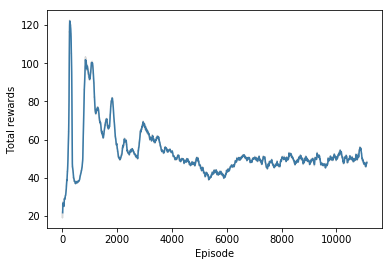

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

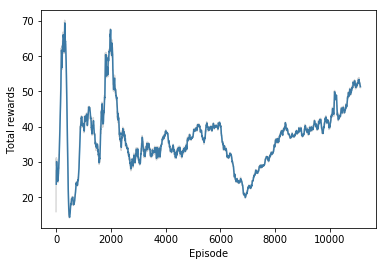

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

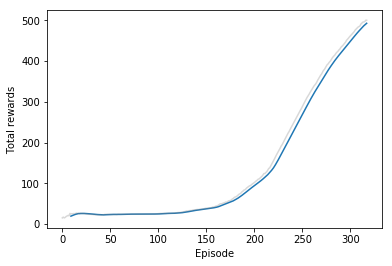

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

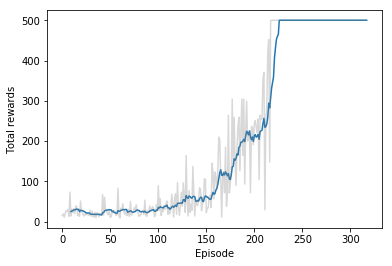

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

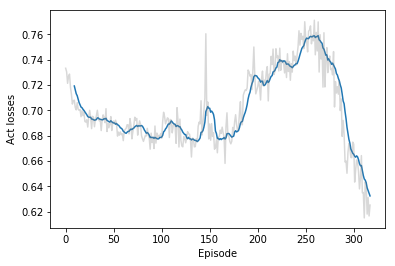

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

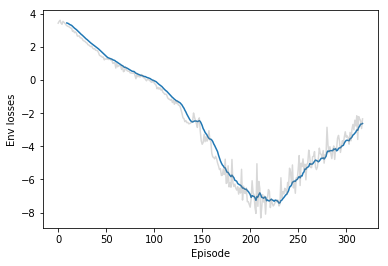

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

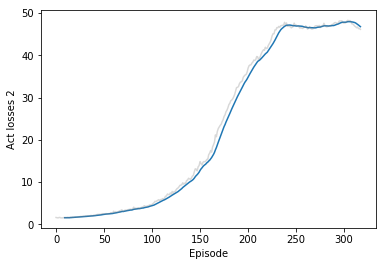

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
